In [28]:
import config
import sqlalchemy
import functions
import statsapi as mlb
import sql_alch_schema
from datetime import datetime

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String,DateTime,Date,Time,Boolean,func
from sqlalchemy import ForeignKey,and_
from sqlalchemy.orm import relationship
from sqlalchemy.schema import Table
from sqlalchemy import distinct

_sql_alchemy_connection = (
                                f'mysql+mysqlconnector://'
                                f'{config.user}:{config.password}'
                                f'@{config.host}:{config.port}'
                                f'/{config.schema}'
                           )
## Create the engine 
db = sqlalchemy.create_engine(_sql_alchemy_connection,
                              echo = False,
                              connect_args = {'ssl_disabled' : True,})

Base = sql_alch_schema.Base

Game = sql_alch_schema.Game
Play = sql_alch_schema.Play
Team = sql_alch_schema.Team
GameTeamLink = sql_alch_schema.GameTeamLink
Person = sql_alch_schema.Person


from sqlalchemy.orm import sessionmaker
Session = sessionmaker(bind=db)
session = Session()

#Base.metadata.create_all(db)

import sqlalchemy_schemadisplay
from sqlalchemy import MetaData

schema_viz = sqlalchemy_schemadisplay.create_schema_graph(metadata=MetaData(db))
schema_viz.write_png('dbschema.png')

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'

sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})

In [29]:
image_dir = "/Users/schlinkertc/code/mlb_predictions/mlb_predictions/images/"

## What's in our DB?


The yankees played the mets on my birthday, so obviously we're gonna look at that game

In [30]:
yankees = session.query(Team).filter(Team.teamName=='Yankees').one()
yankees.id

147

In [31]:
june_11 = datetime(2019,6,11)
yankees_mets6_11 = (session.query(Game)
                    .order_by(Game.dateTime.asc())
                    .filter(and_(Game.dateTime>june_11,
                                 Game.homeTeam_id==yankees.id))
                    .first())

In [32]:
yankees_mets6_11

<Game(pk='567491',id='2019/06/11/nynmlb-nyamlb-1')>

In [33]:
# we won!
home_score = max([x.homeScore for x in yankees_mets6_11.plays])
away_score = max([x.awayScore for x in yankees_mets6_11.plays])
print(home_score,away_score)

12 5


## Import Dataset

In [34]:
cat_df=functions.getGame_df()
df=functions.load_dataset(session)

grand_df=pd.merge(left=df,
                  right=cat_df,
                  left_on='ID',
                  right_on='id')

In [36]:
grand_df.shape

(4859, 127)

## Let's go exploring

First, we'll look at the numerical features.

- Where do individual players' avgs lie on univariate distributions of features
- compare/contrast feature distributions by winning/losing teams

In [ ]:
df_homeWin=df[df['home_score']>df['away_score']]
df_awayWin=df[df['home_score']<df['away_score']]

#### seperate stats by winning/losing teams

In [26]:
# e.g. home OBP when home wins,away OBP when home loses
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
def compare_stat_distro(df):
    
    stats = {x.split("_",1)[1] for x in df.columns.tolist() if x != 'ID'}
    
    df_homeWin=df[df['home_score']>df['away_score']]
    df_awayWin=df[df['home_score']<df['away_score']]
    
    df_homeWin.replace(to_replace=0,value=np.nan,inplace=True)
    df_awayWin.replace(to_replace=0,value=np.nan,inplace=True)
    
    df_homeWin.dropna(inplace=True)
    df_awayWin.dropna(inplace=True)
    
    for stat in stats:
        winnerStat=df_homeWin[f'home_{stat}'].append(df_awayWin[f'away_{stat}'])
        loserStat=df_homeWin[f'away_{stat}'].append(df_awayWin[f'home_{stat}'])
        
        sns.distplot(winnerStat,label='Winners',)
        sns.distplot(loserStat,label='Losers')
        
        plt.title(stat)

        plt.legend()
        plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


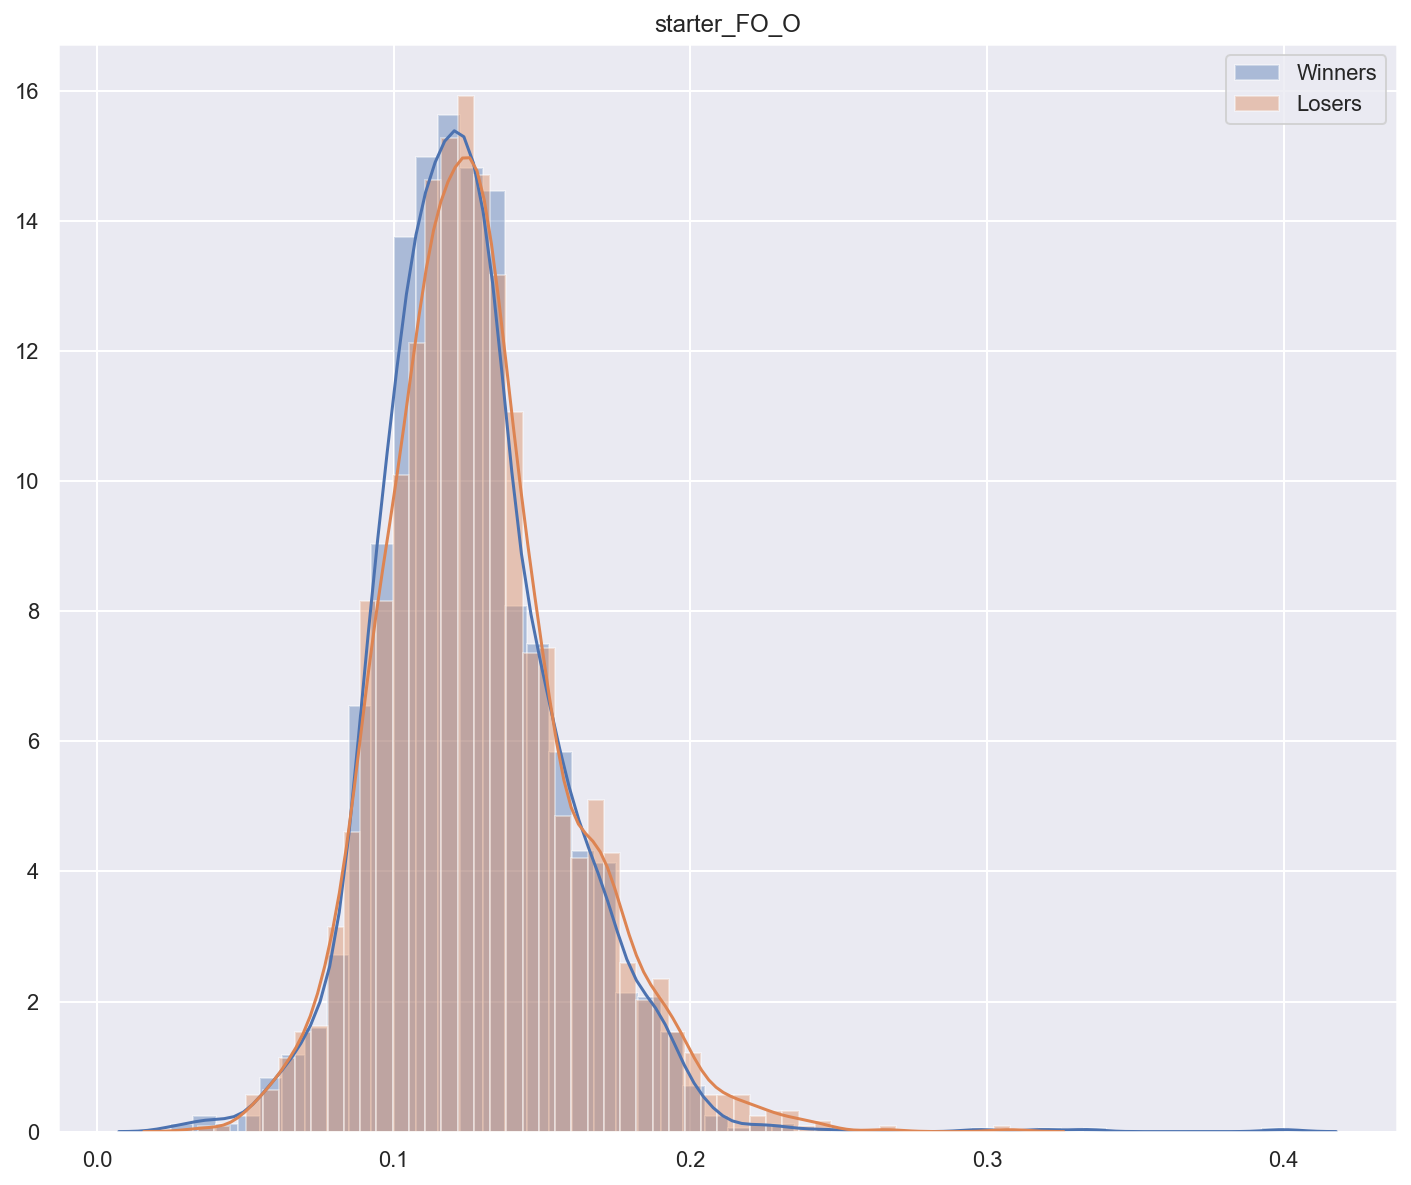

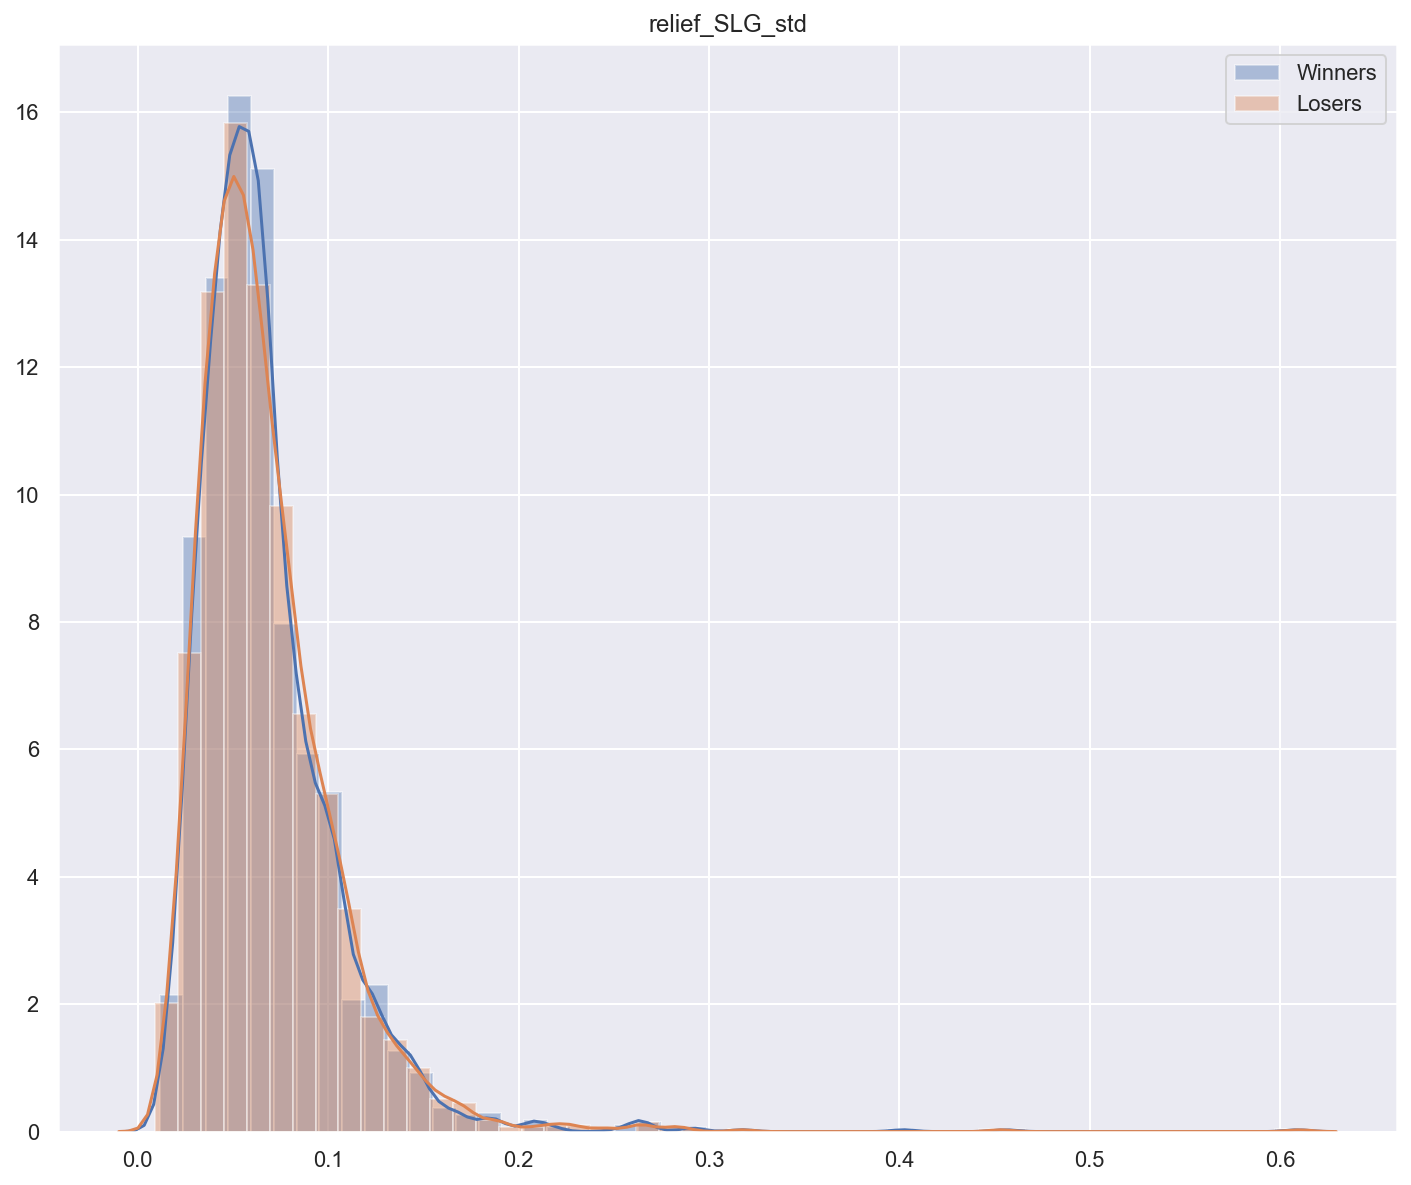

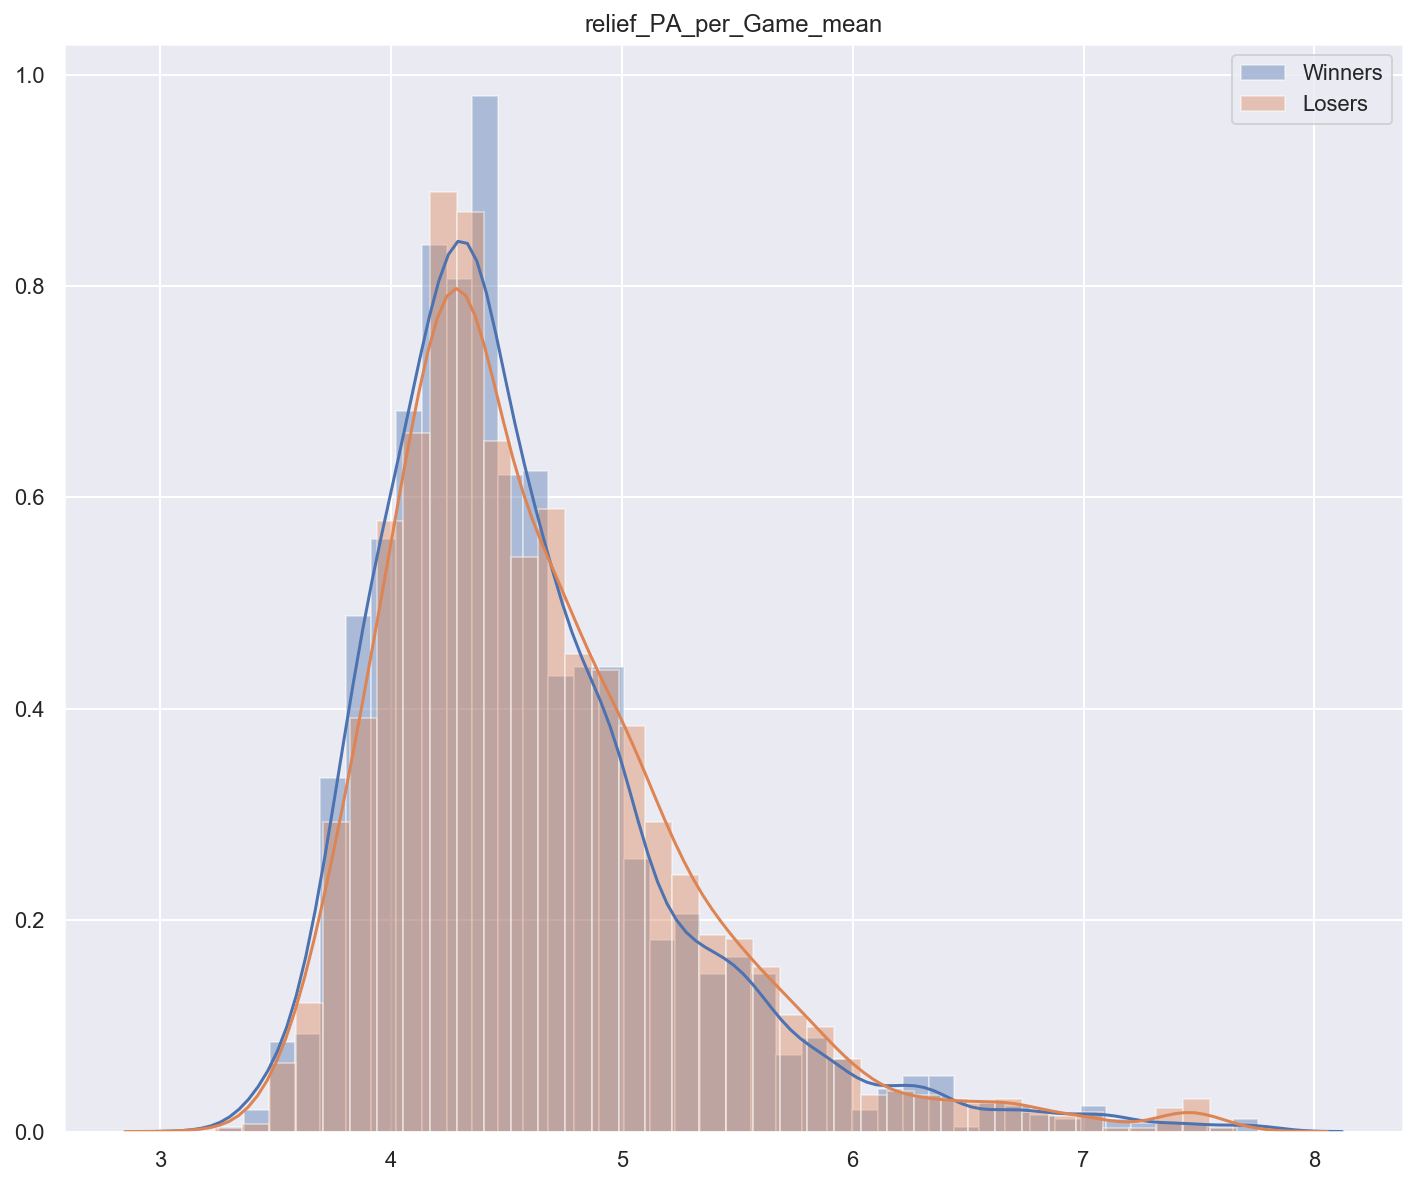

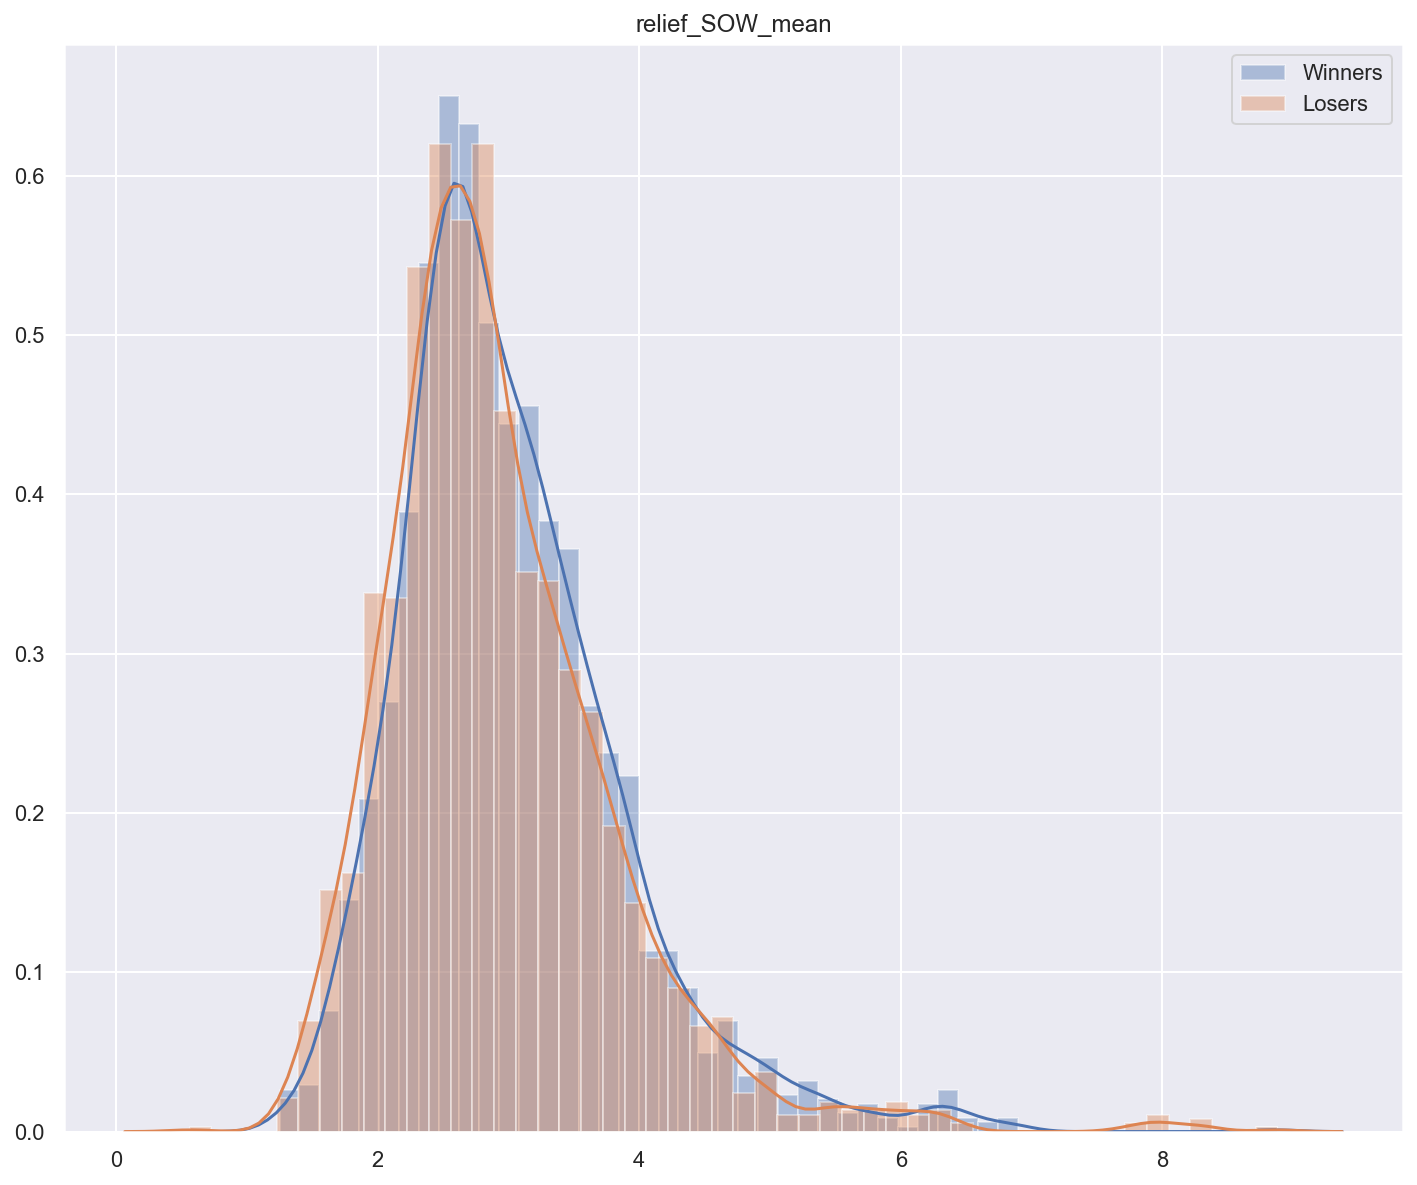

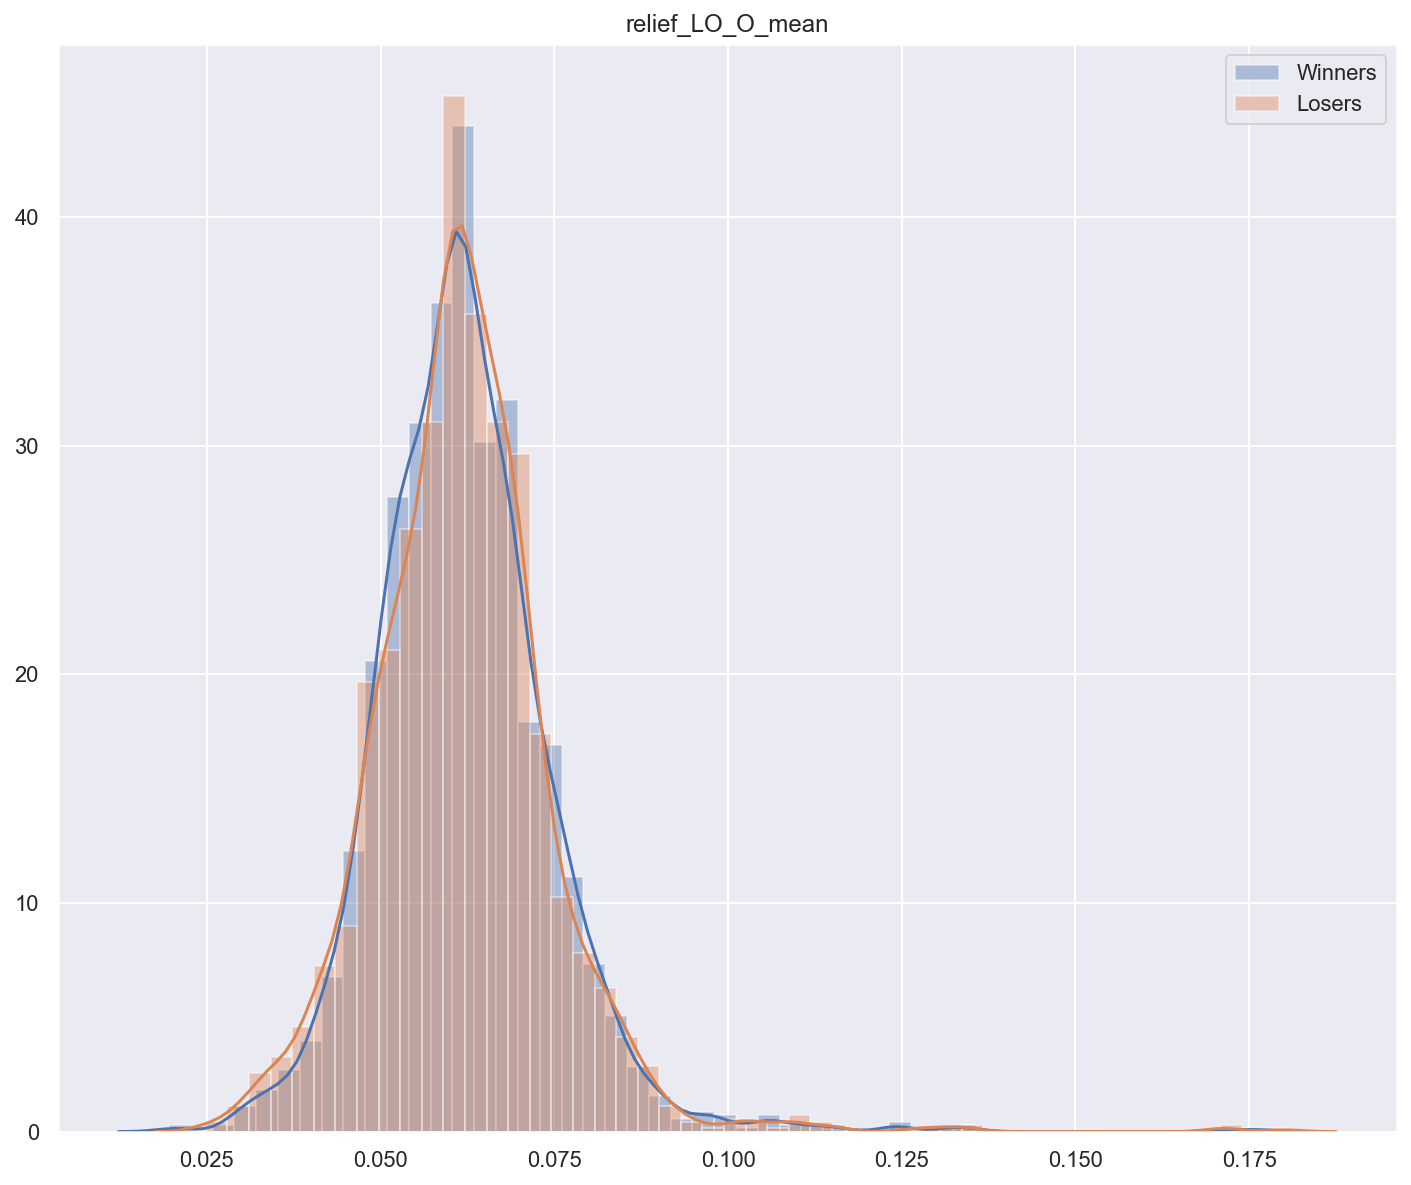

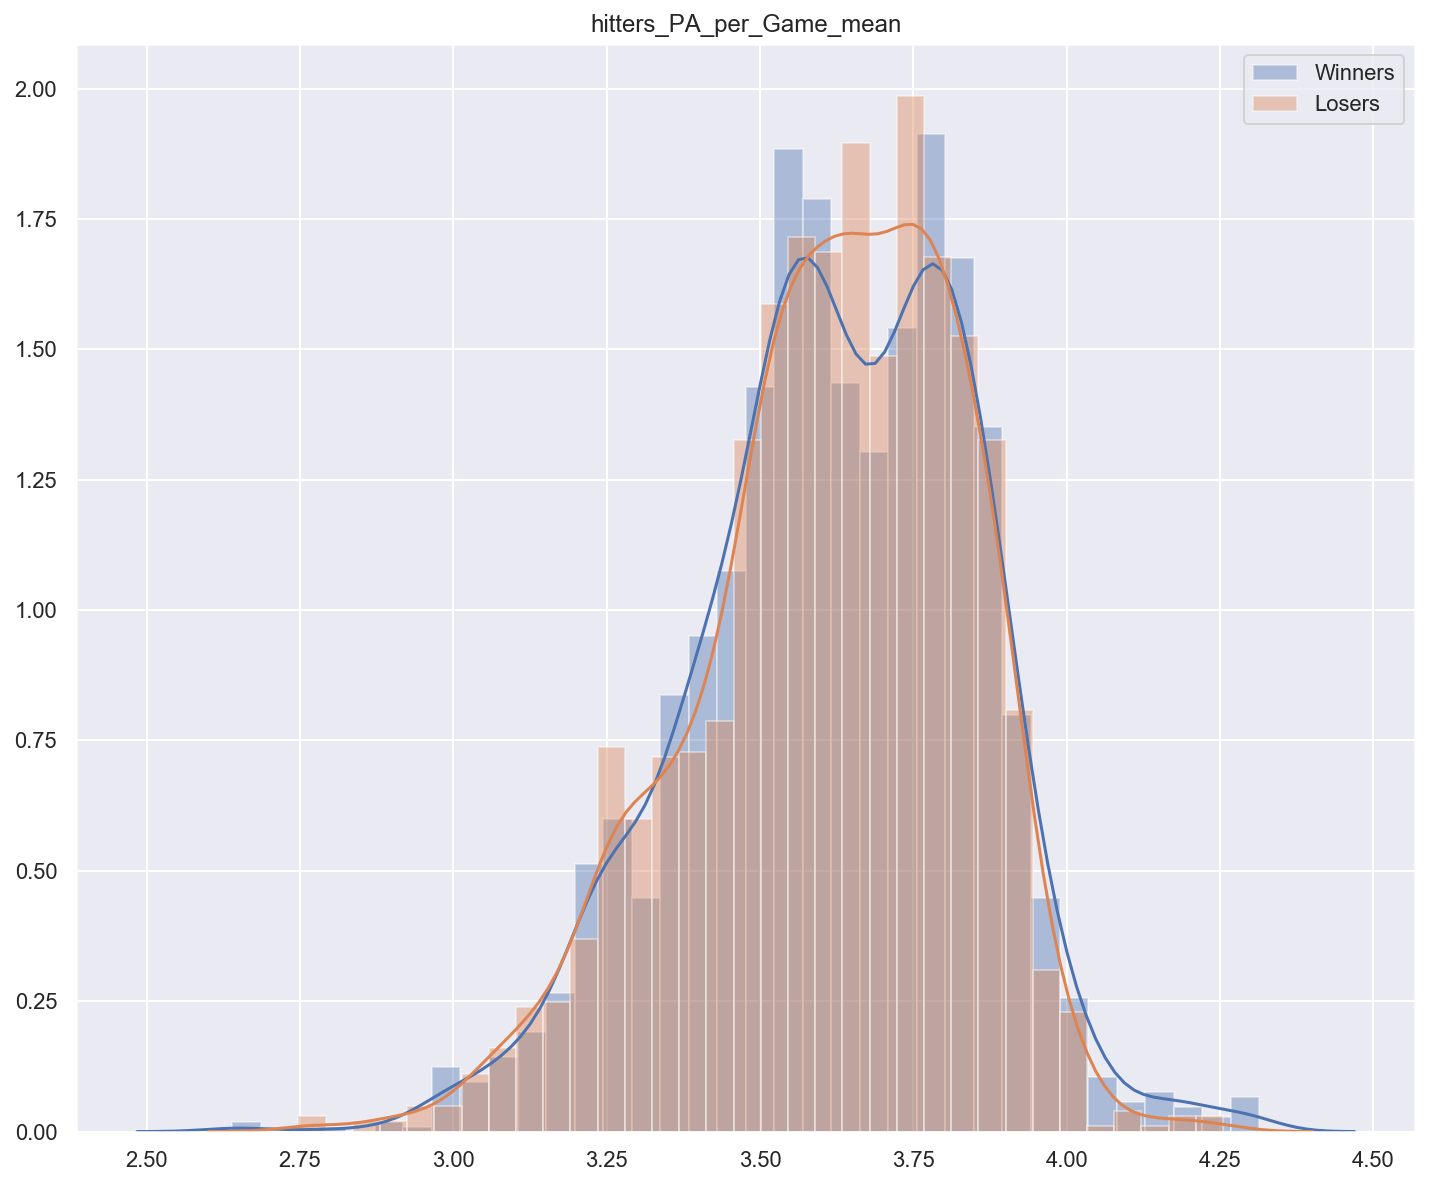

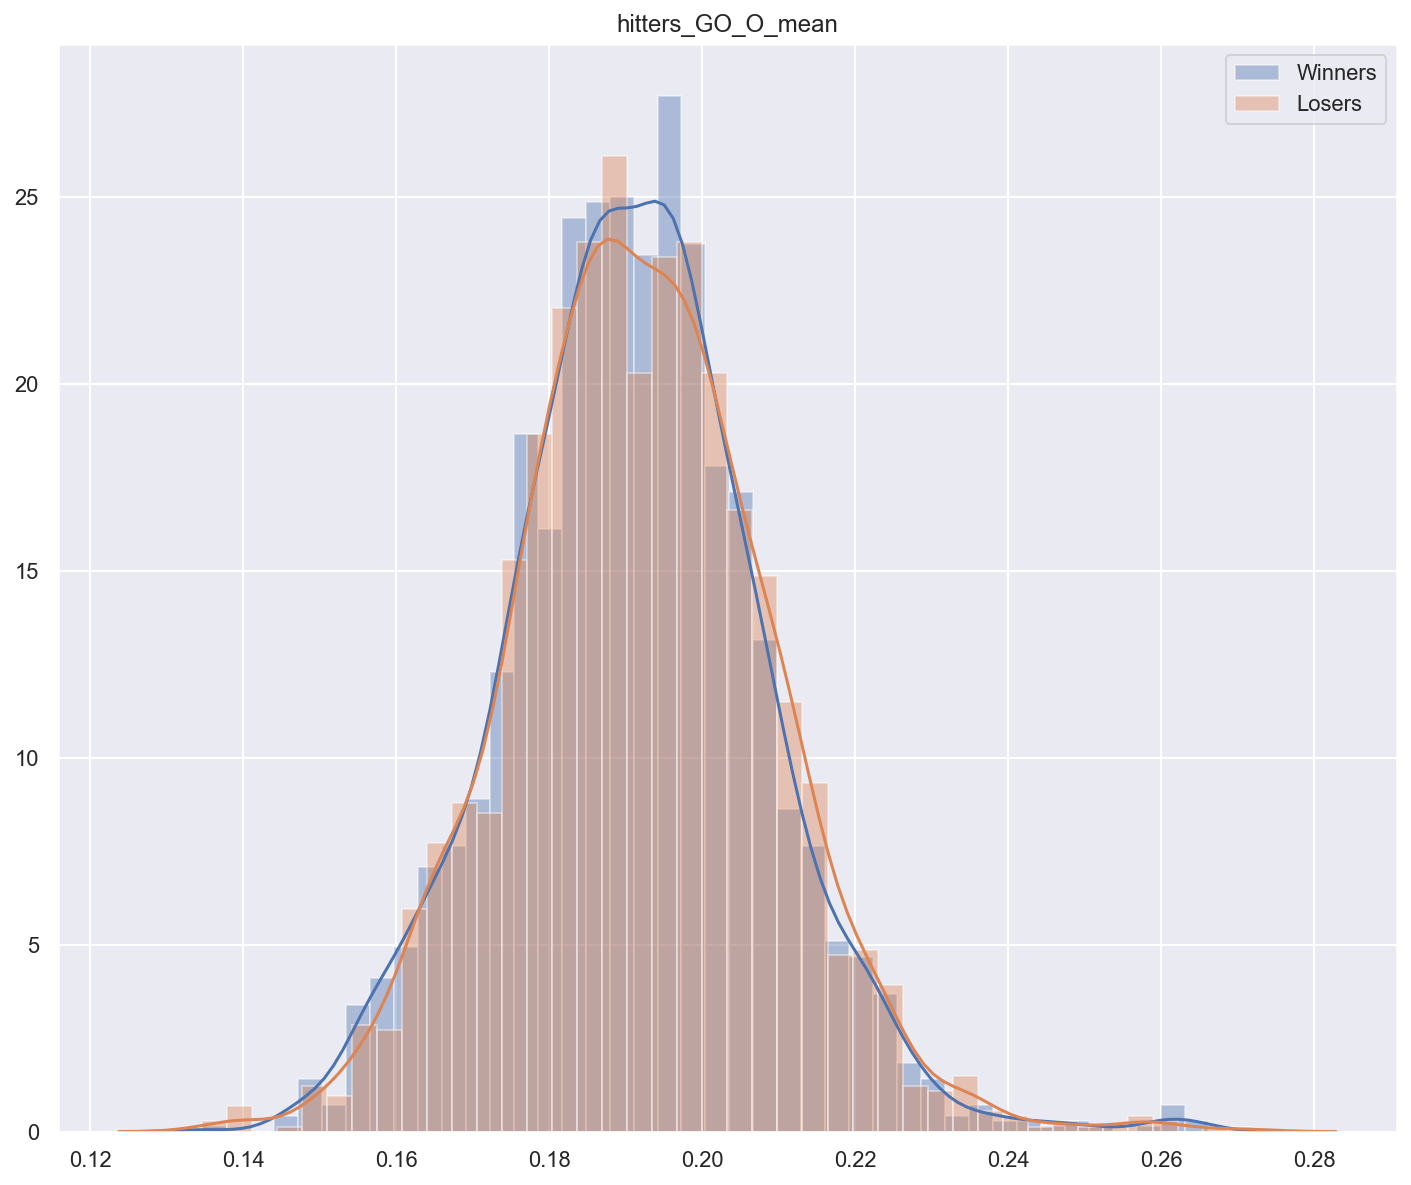

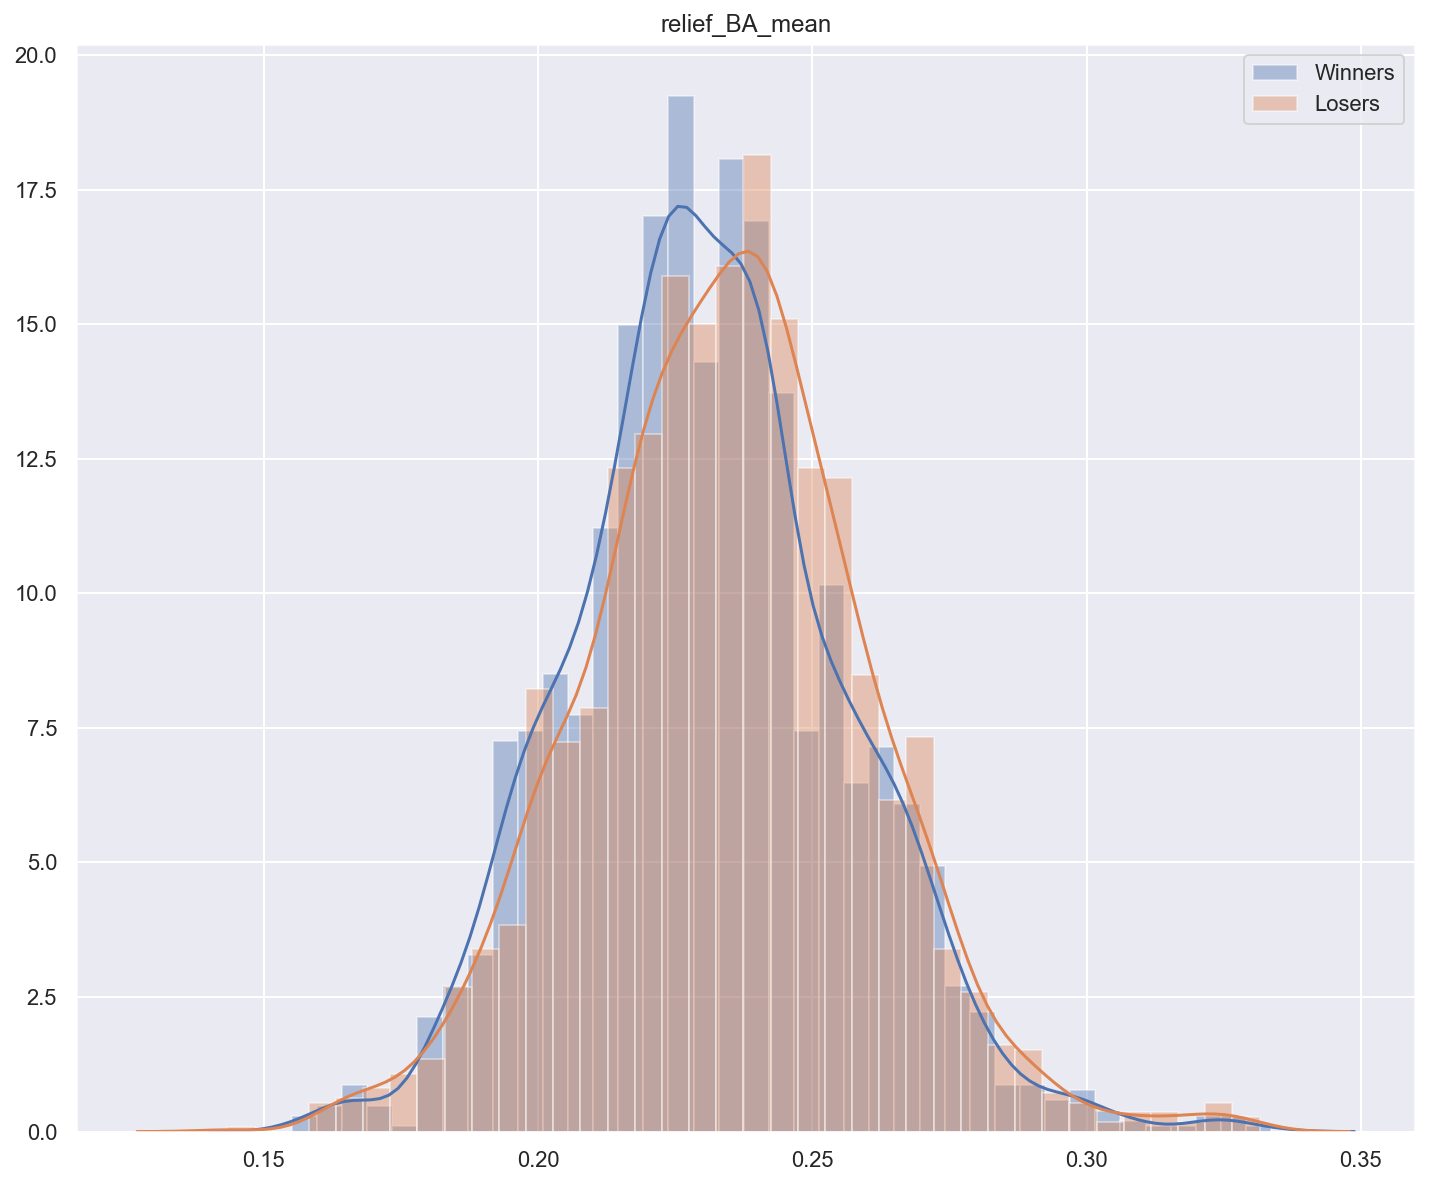

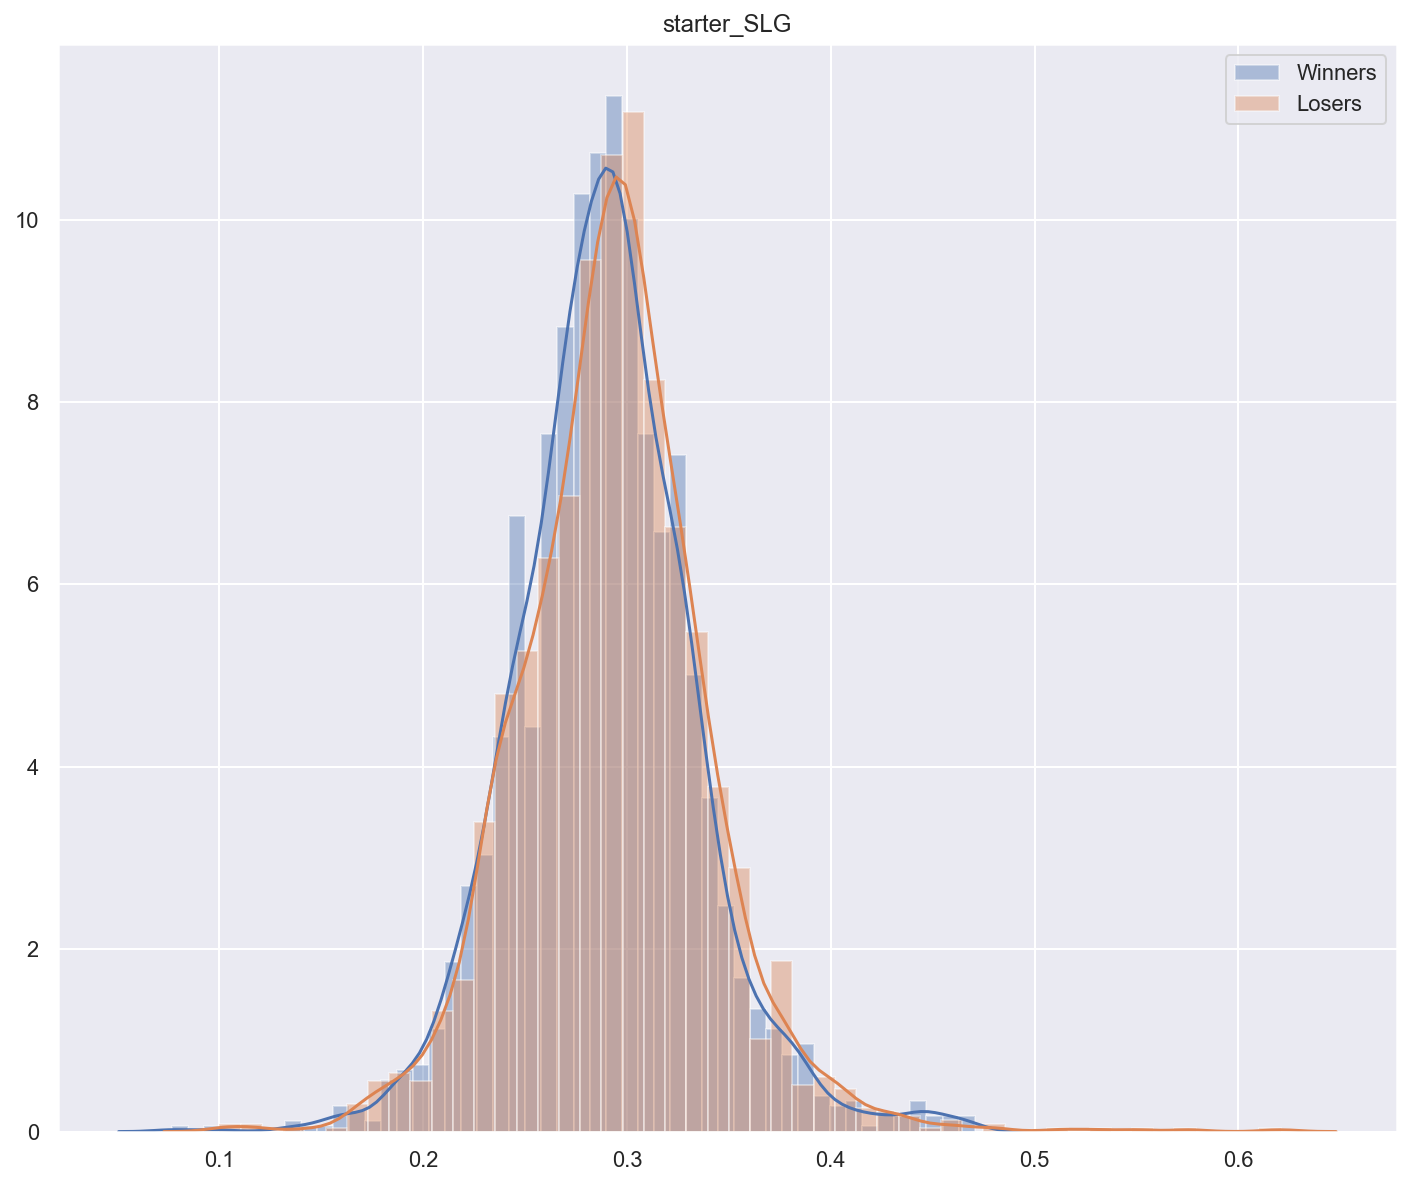

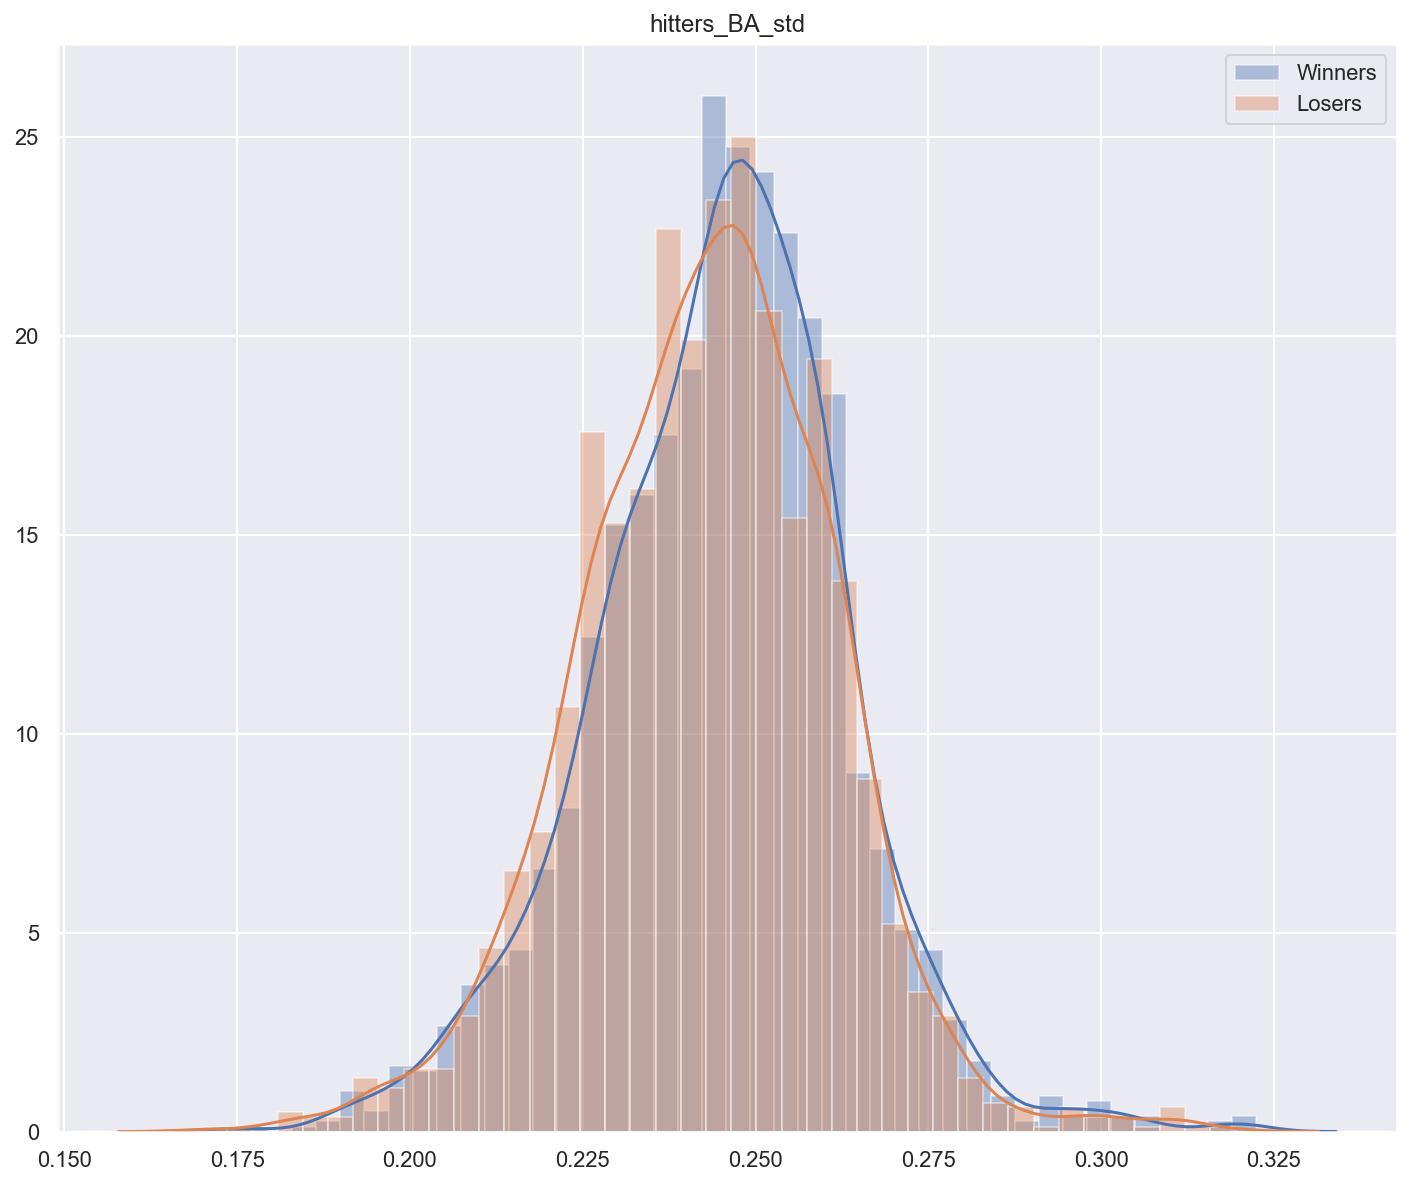

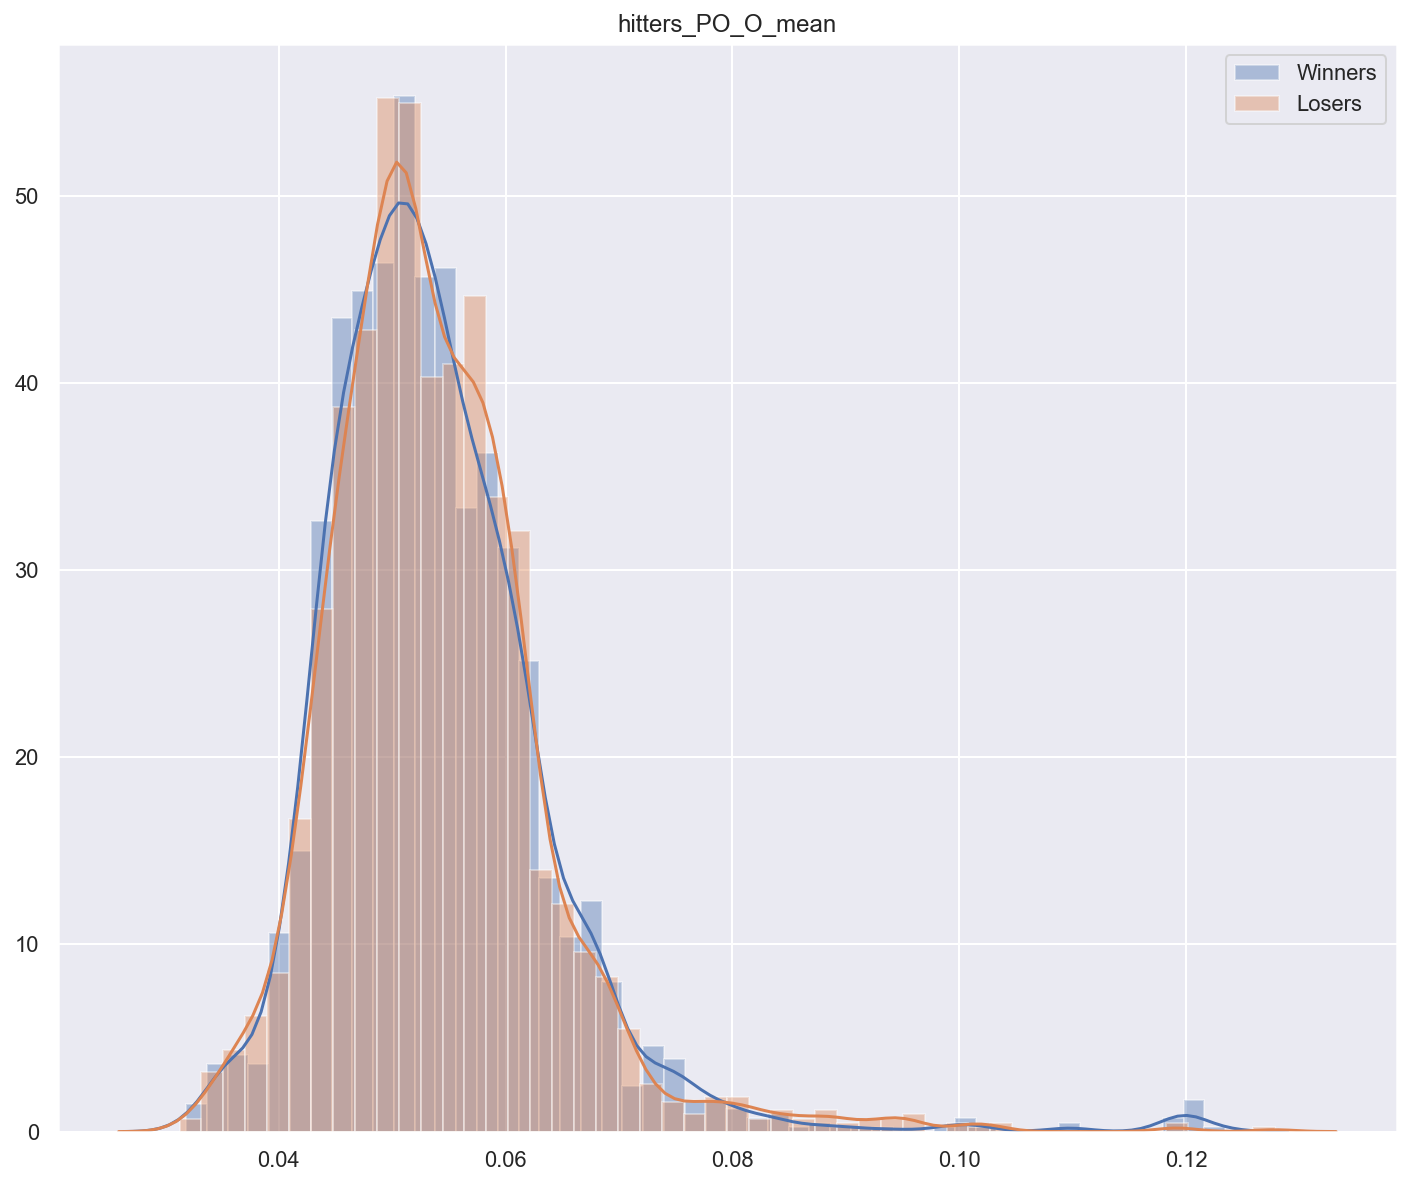

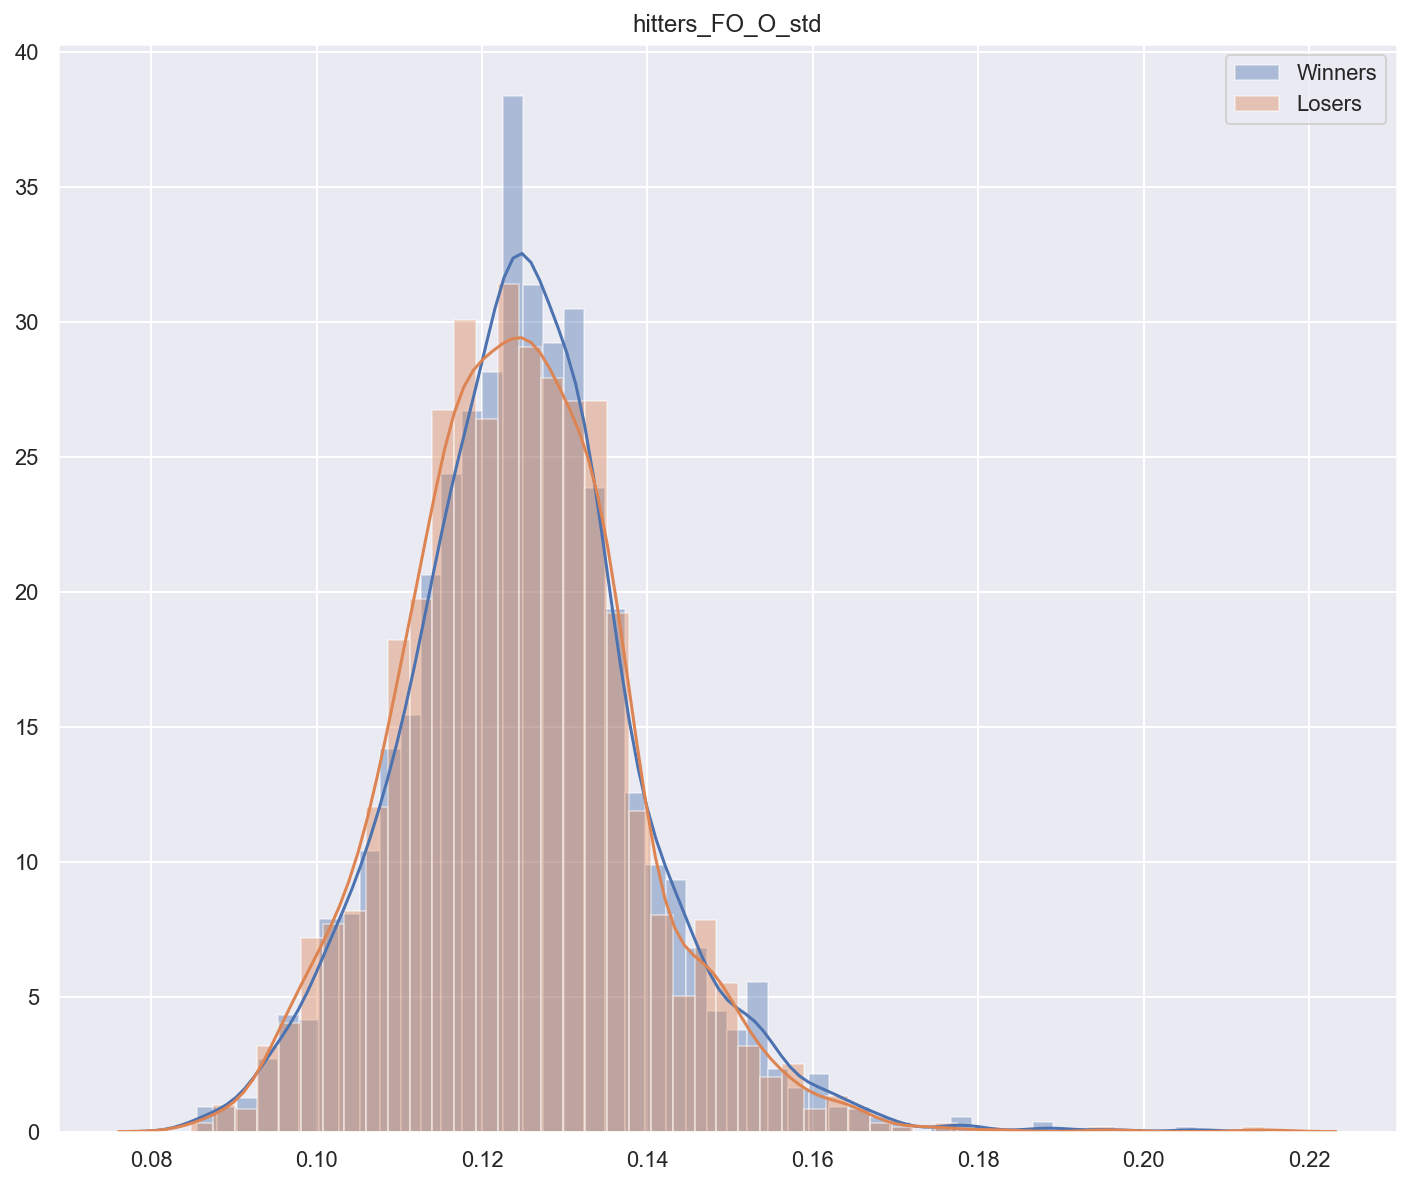

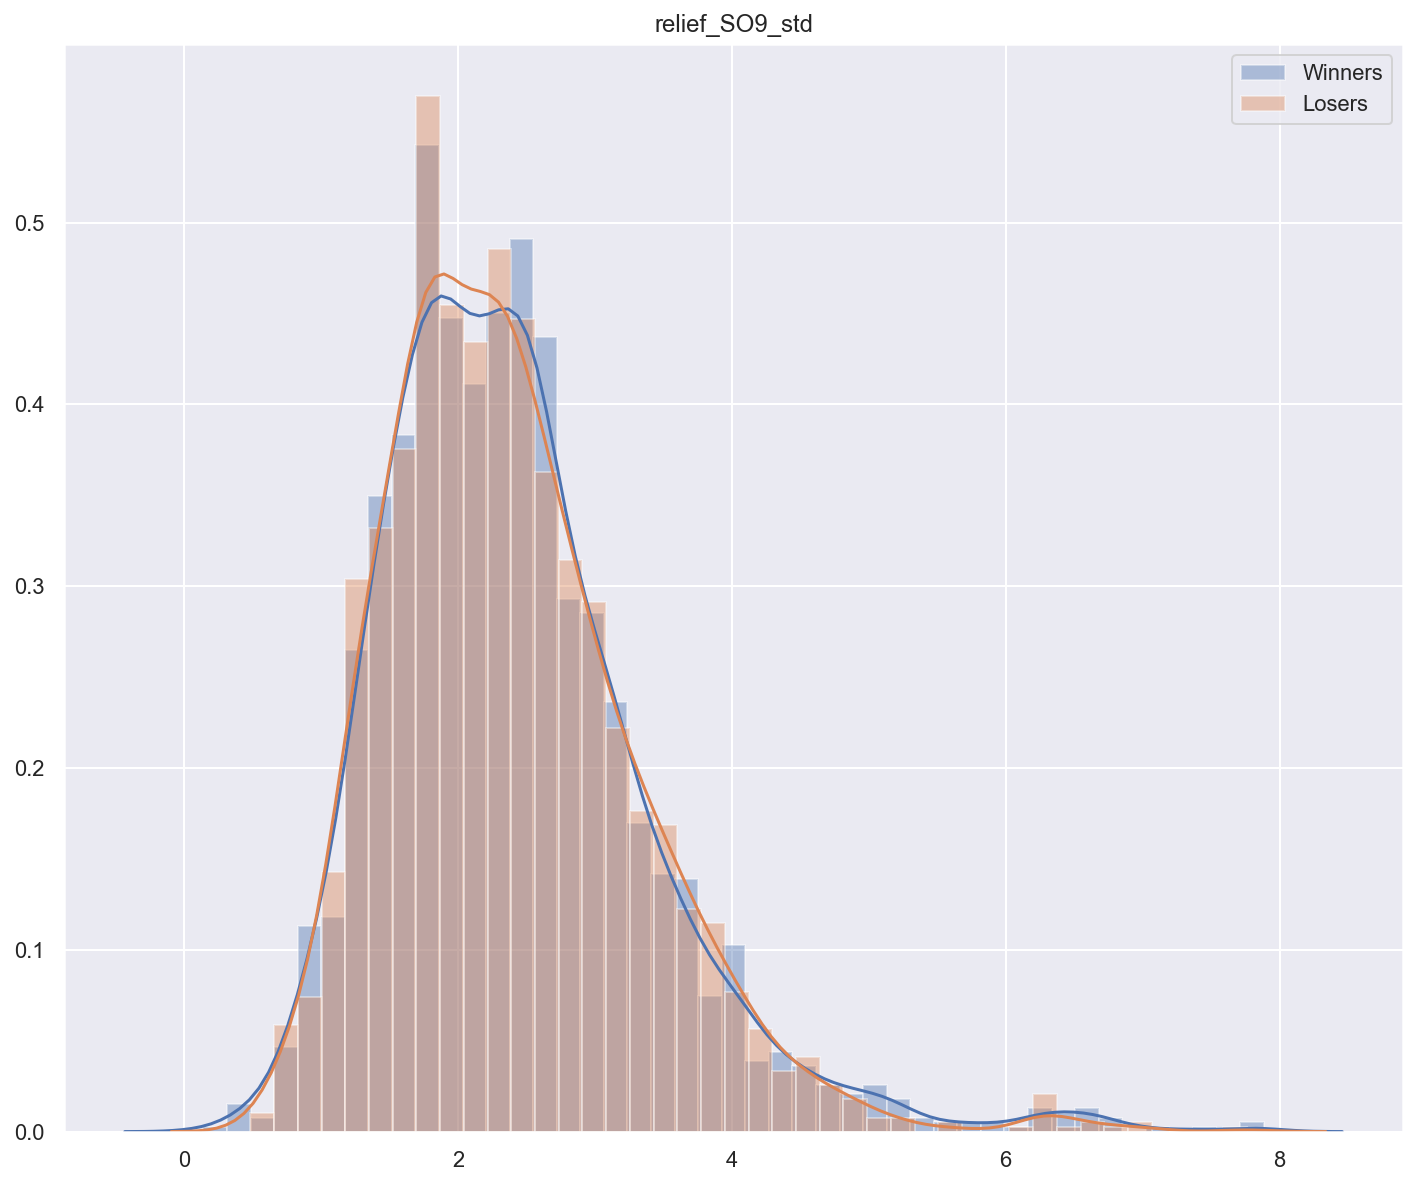

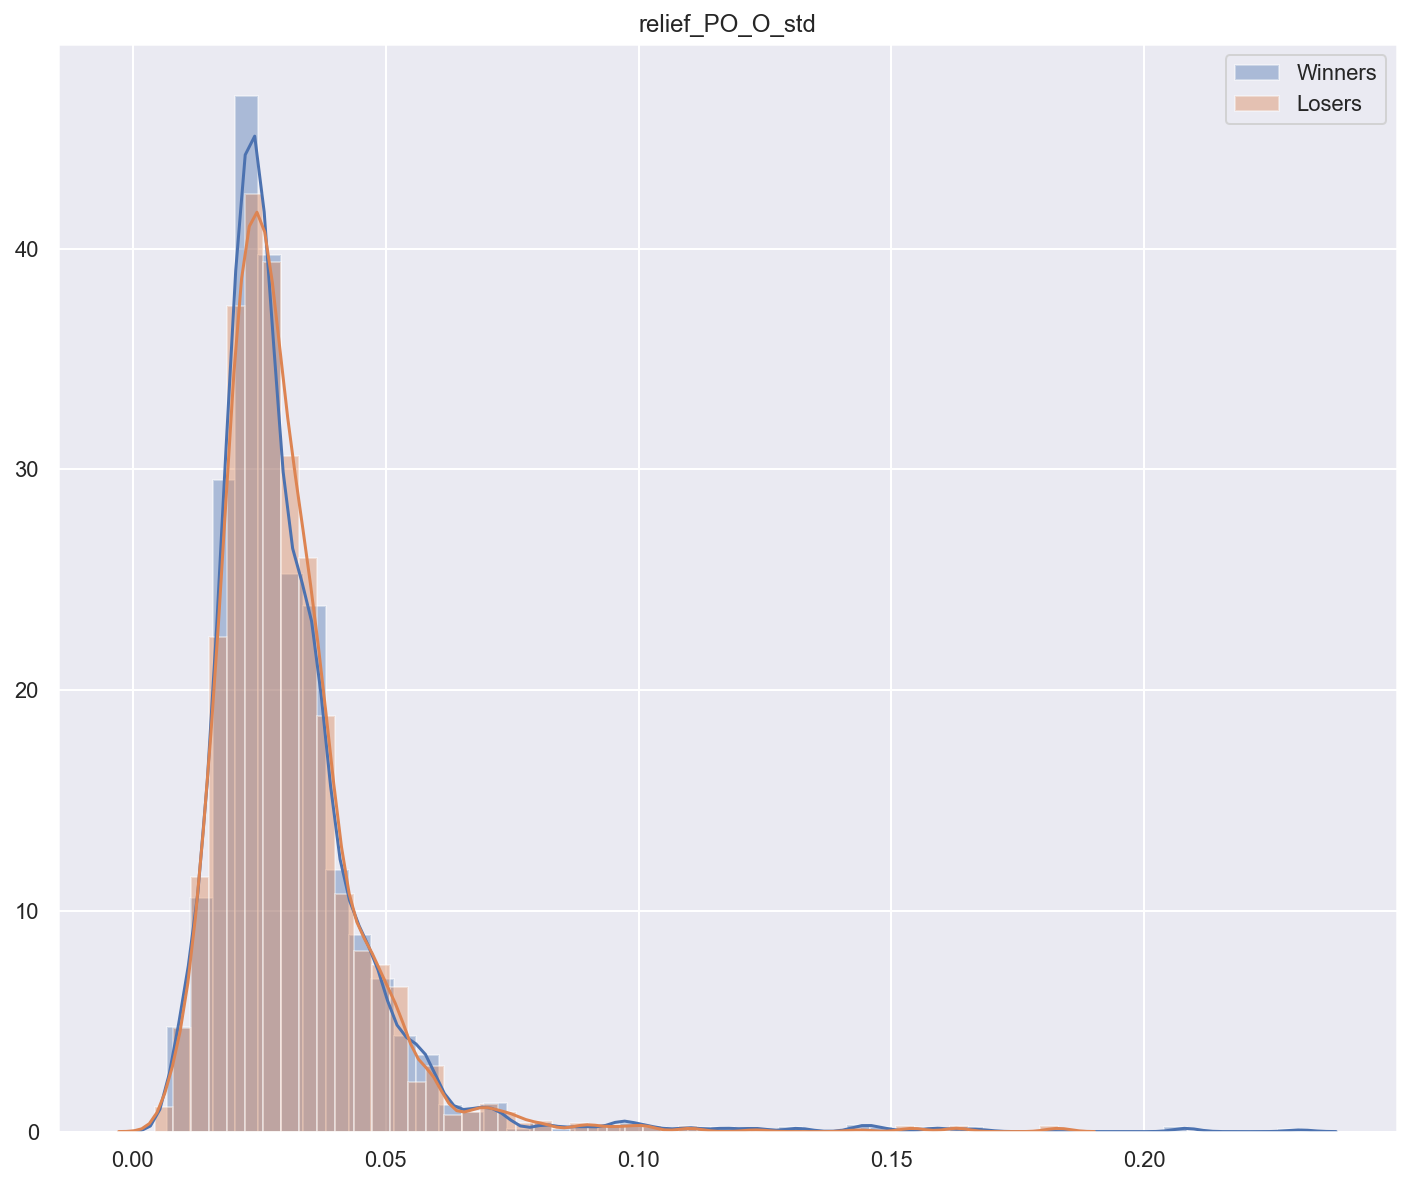

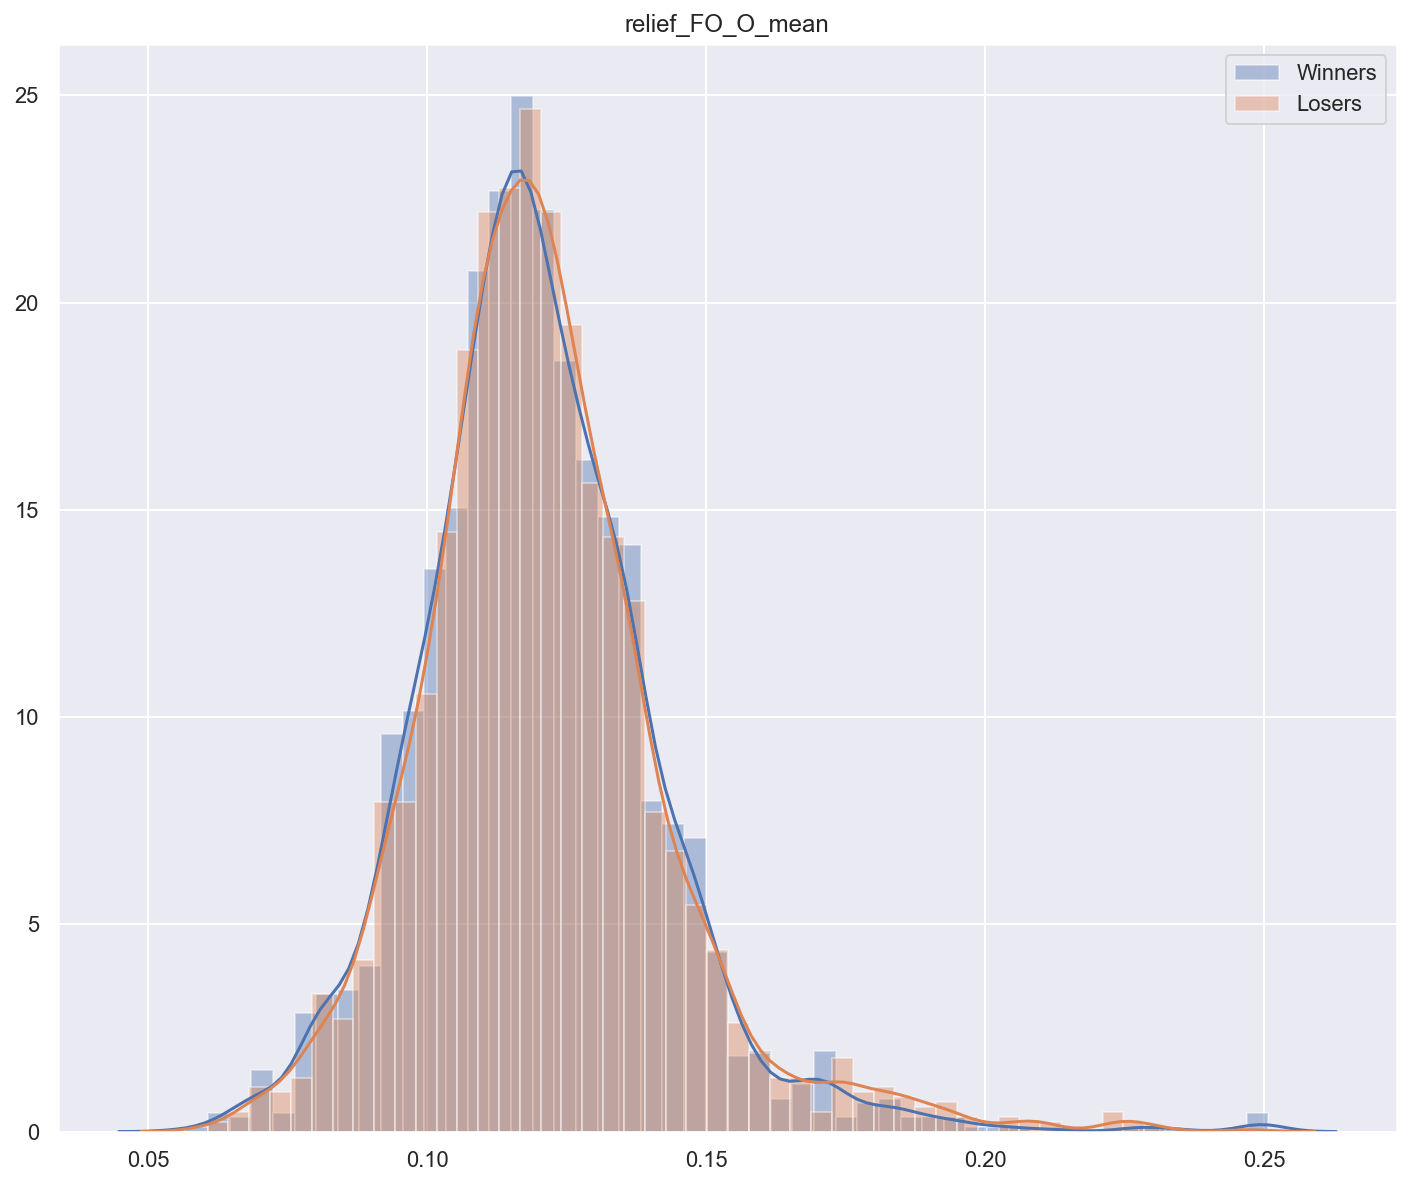

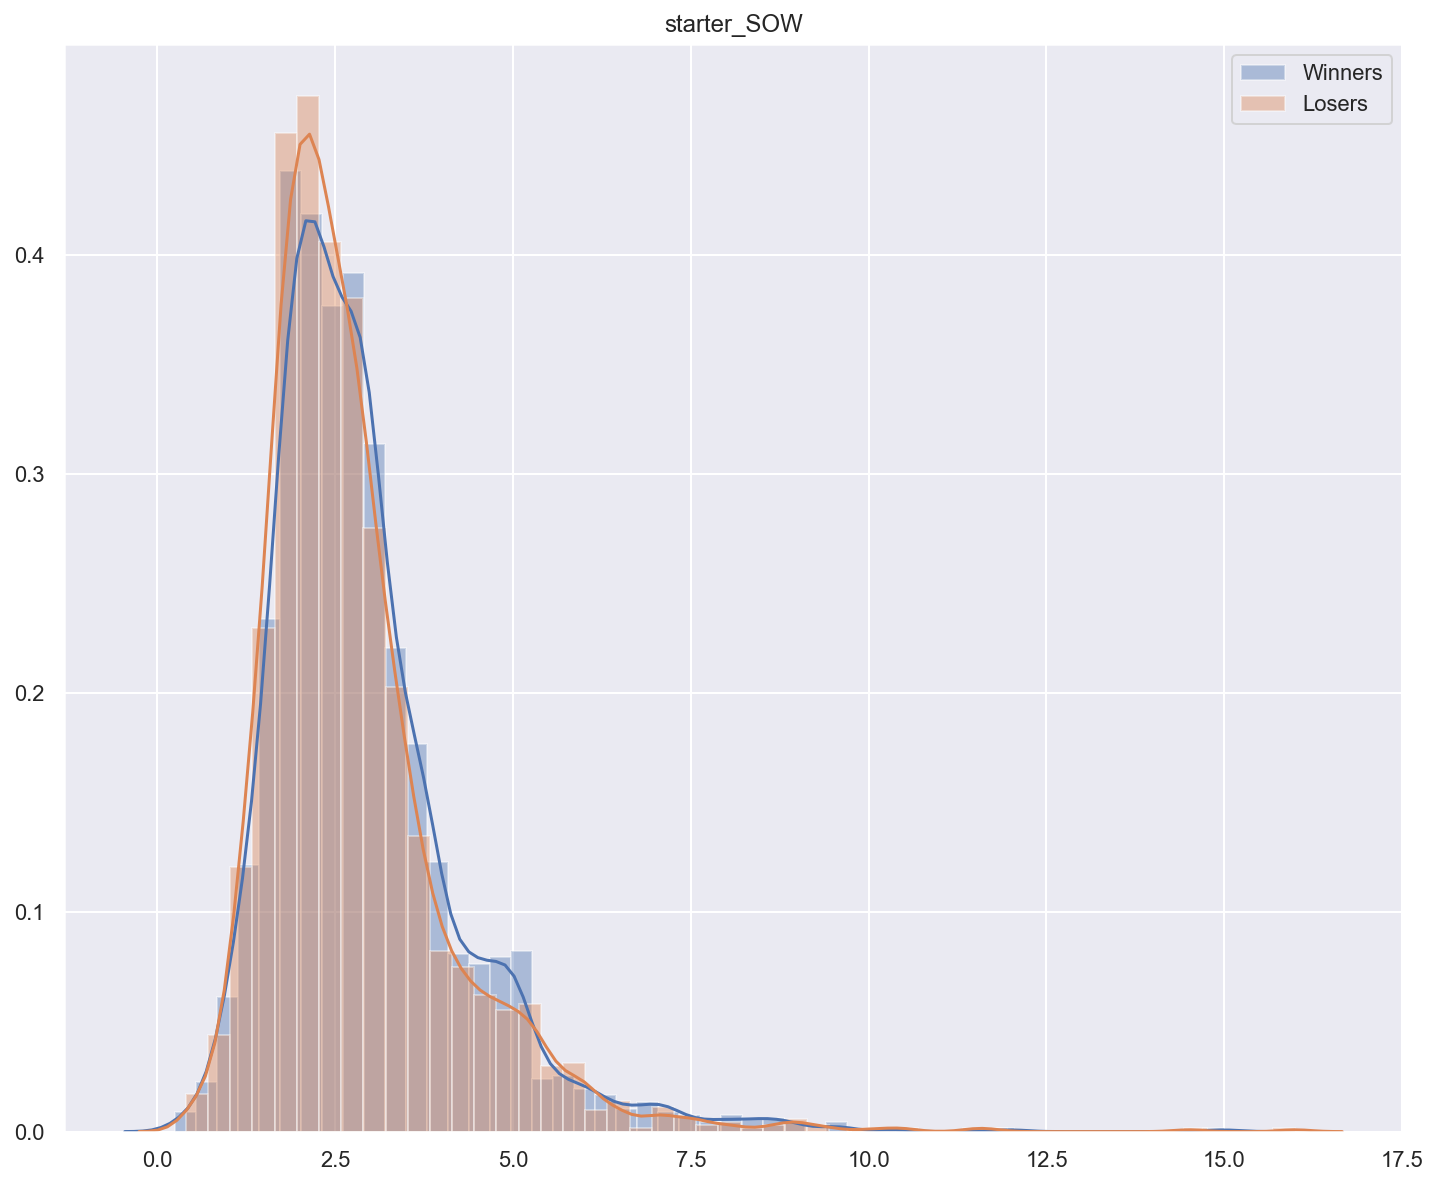

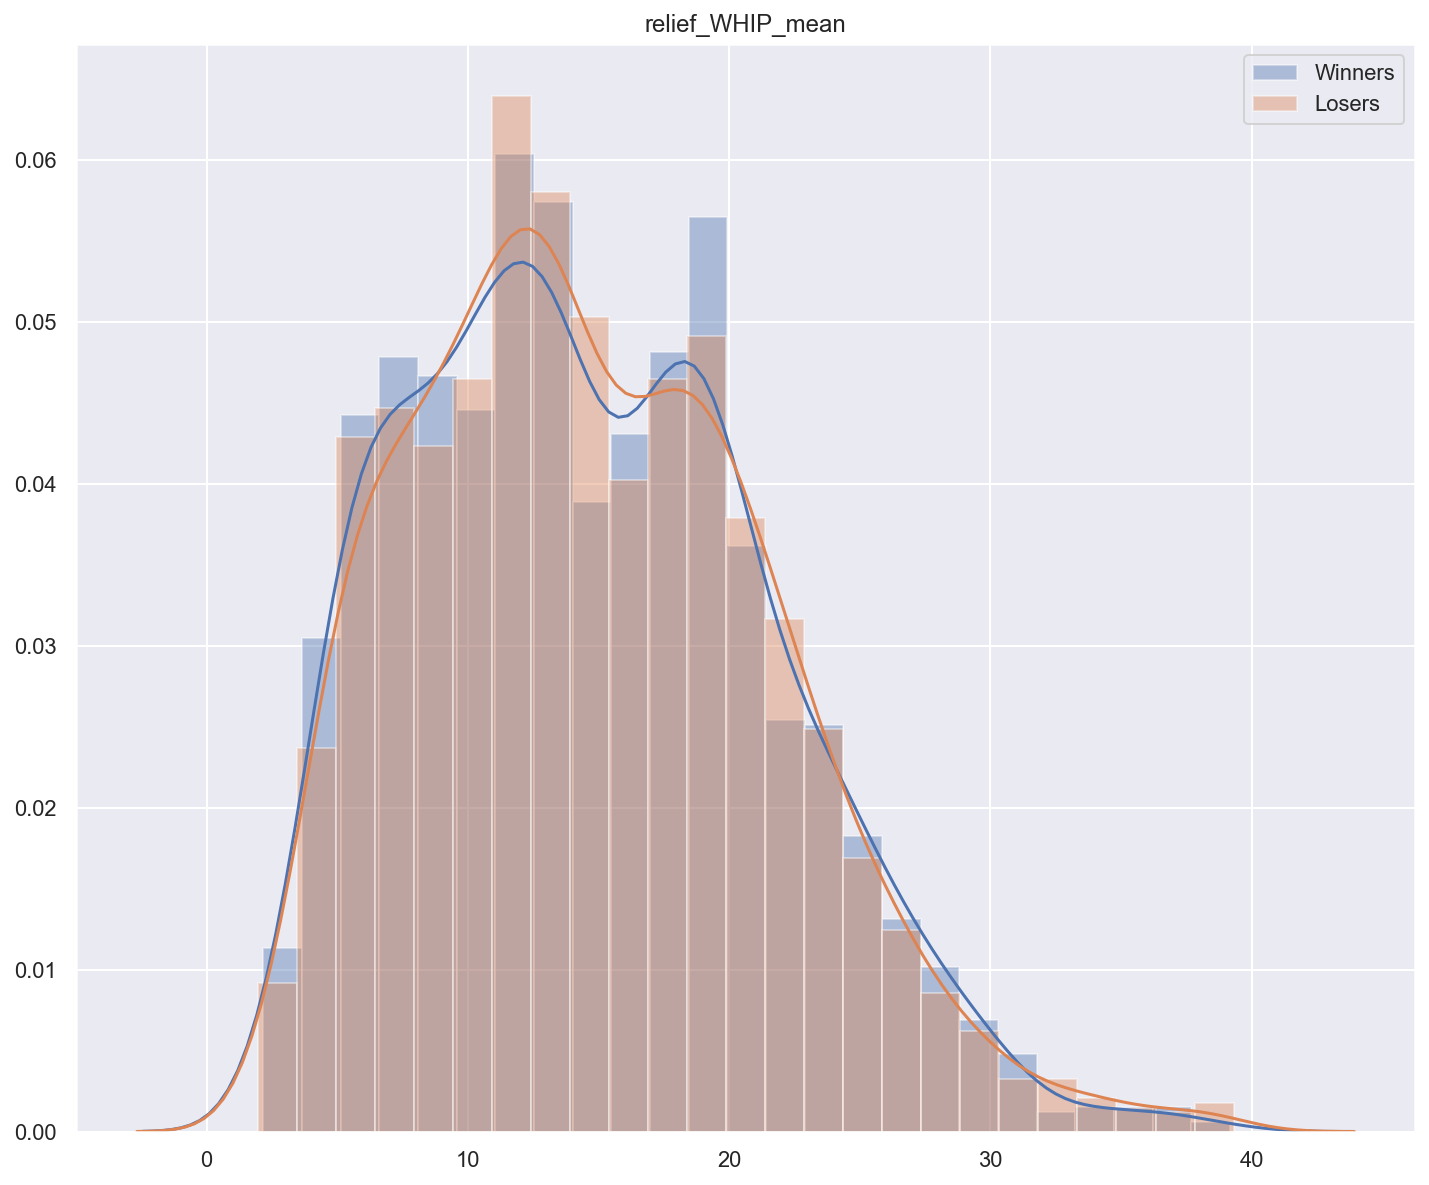

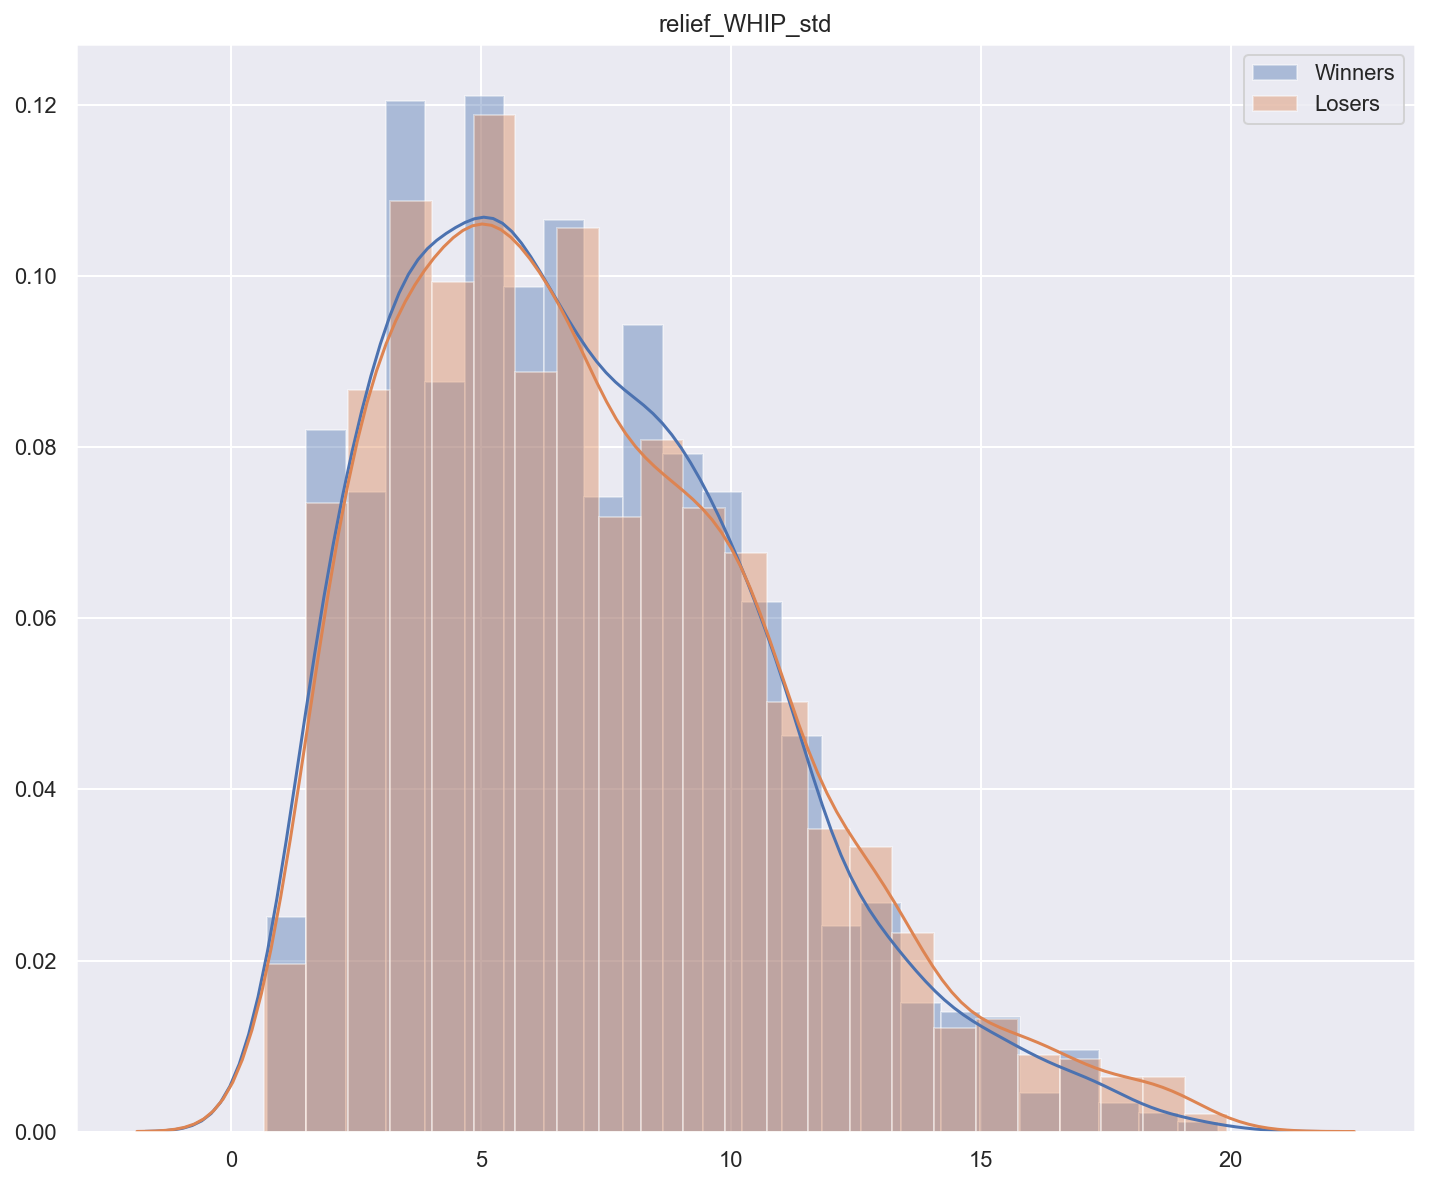

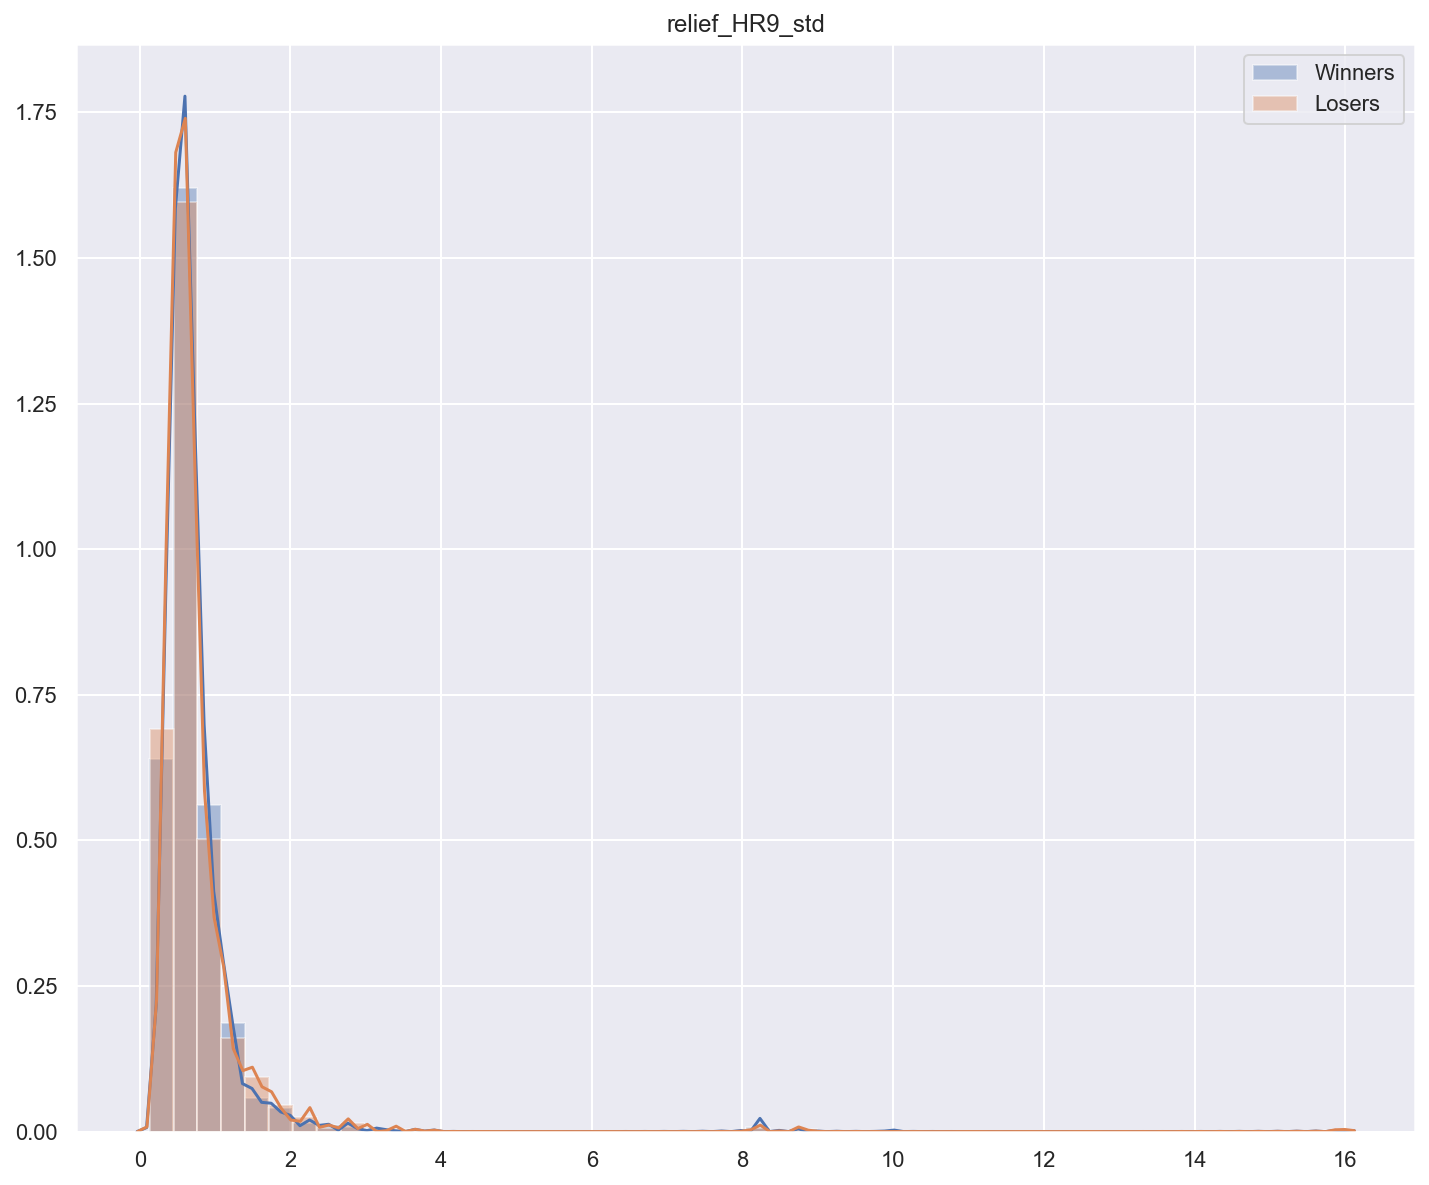

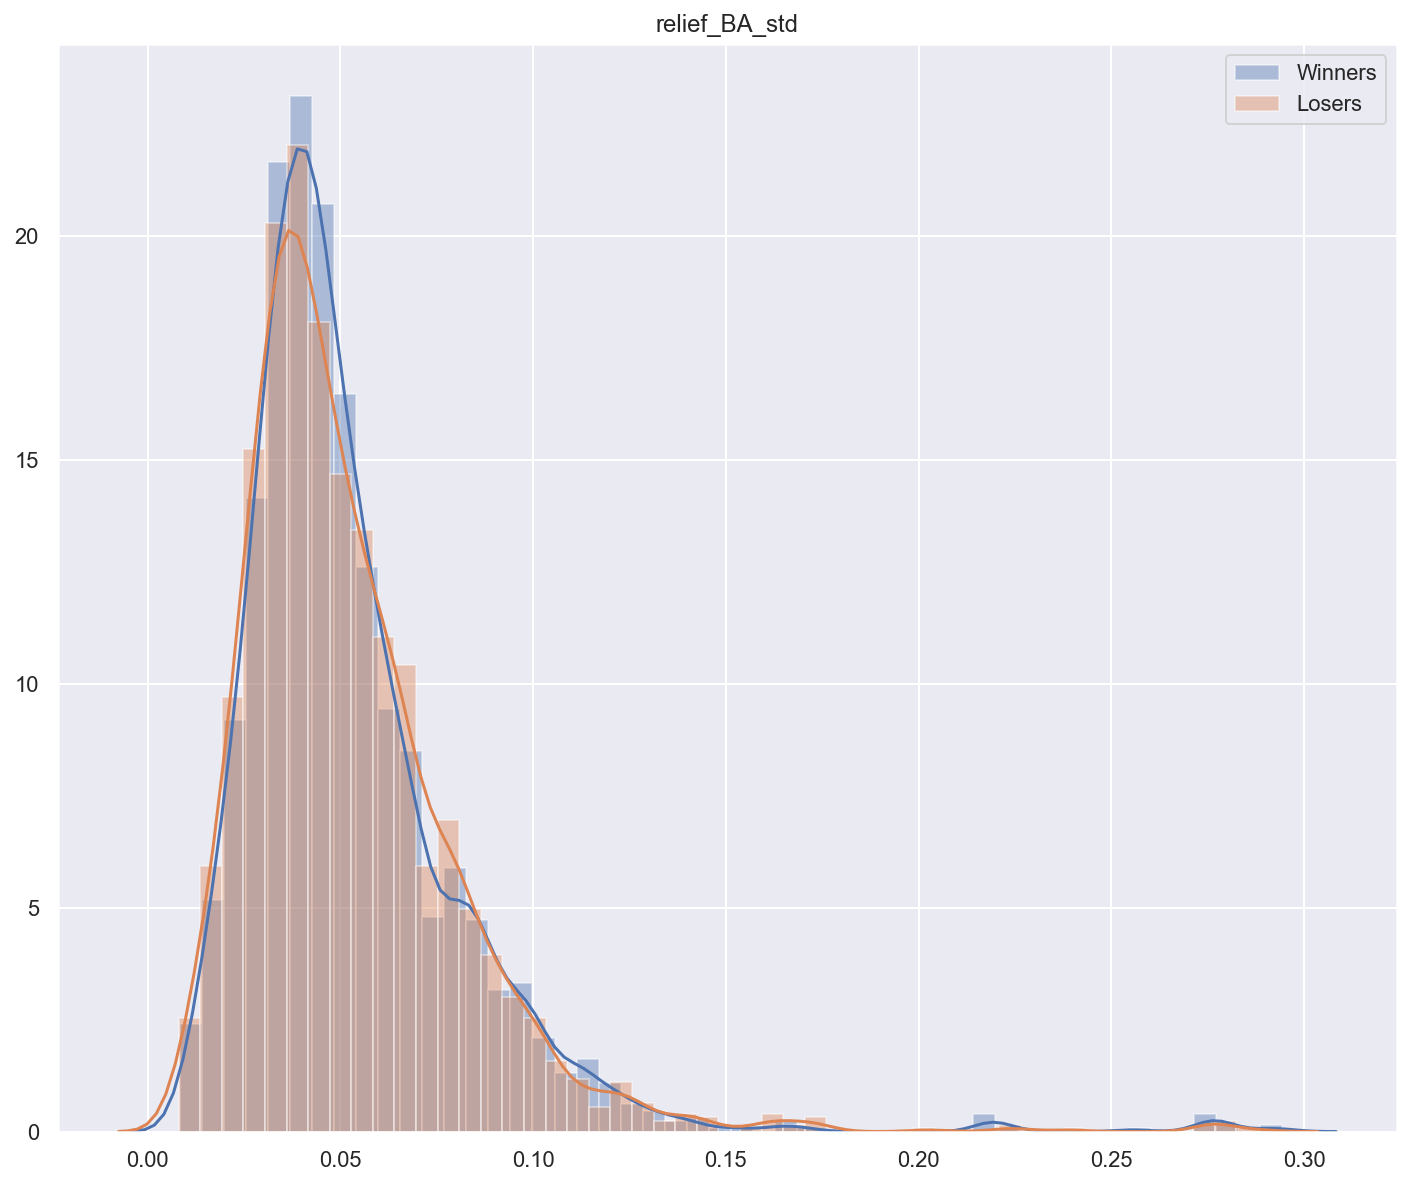

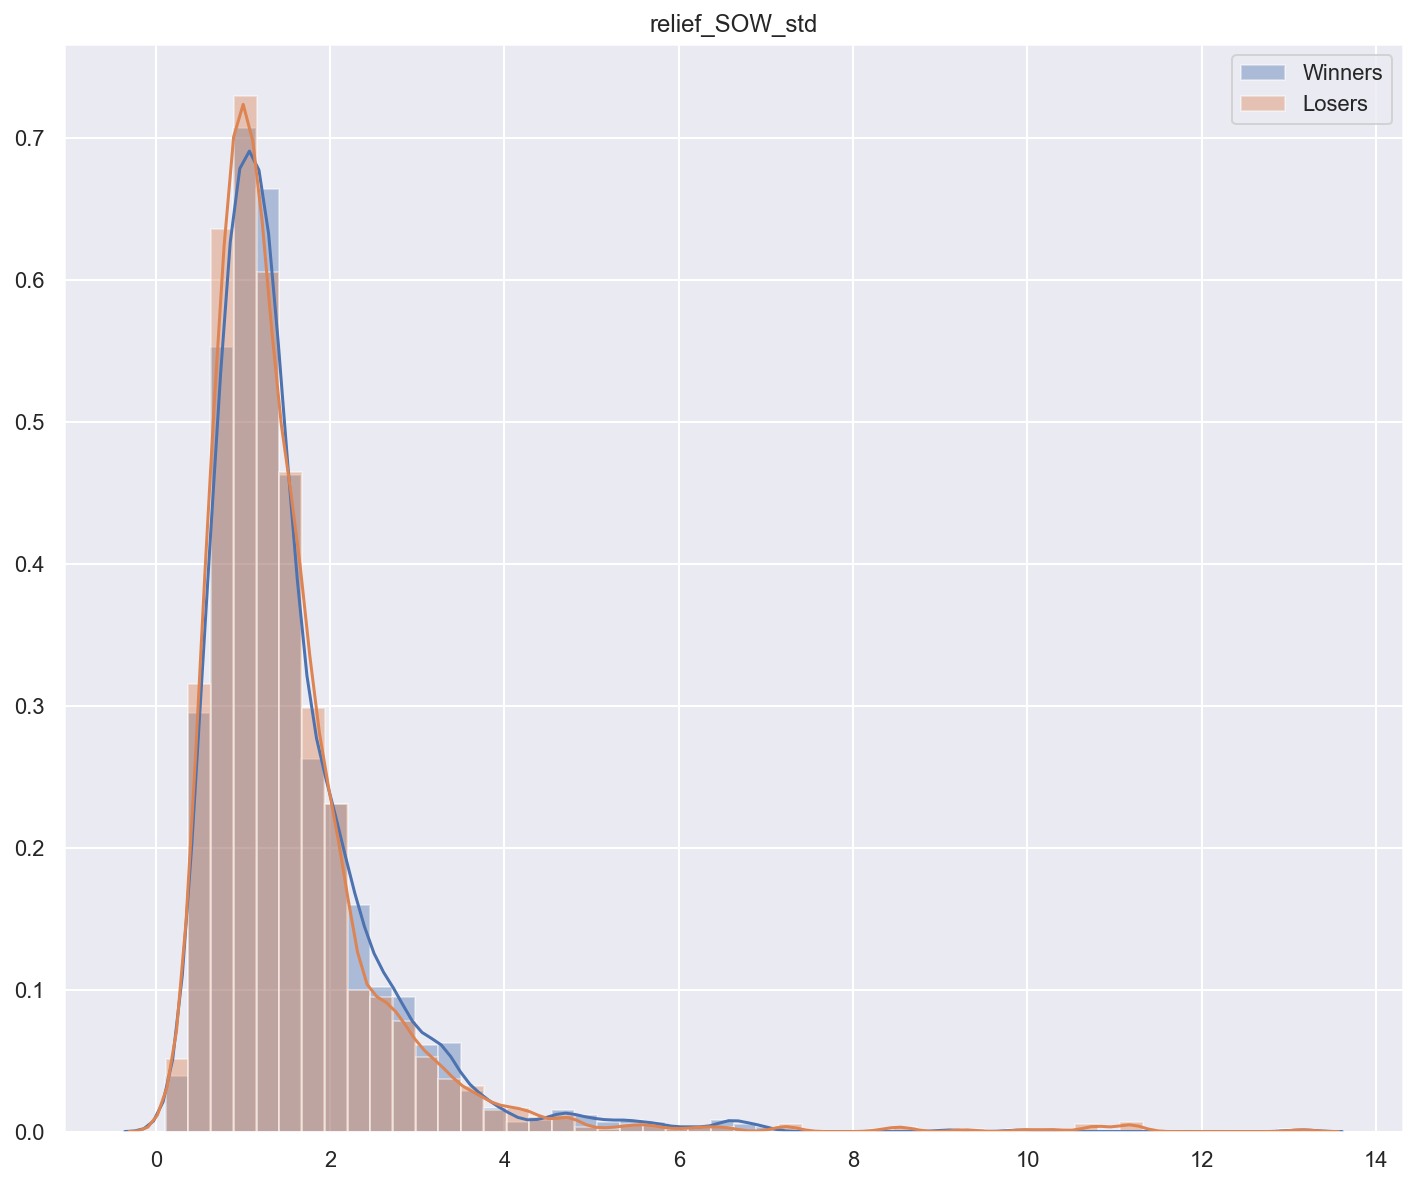

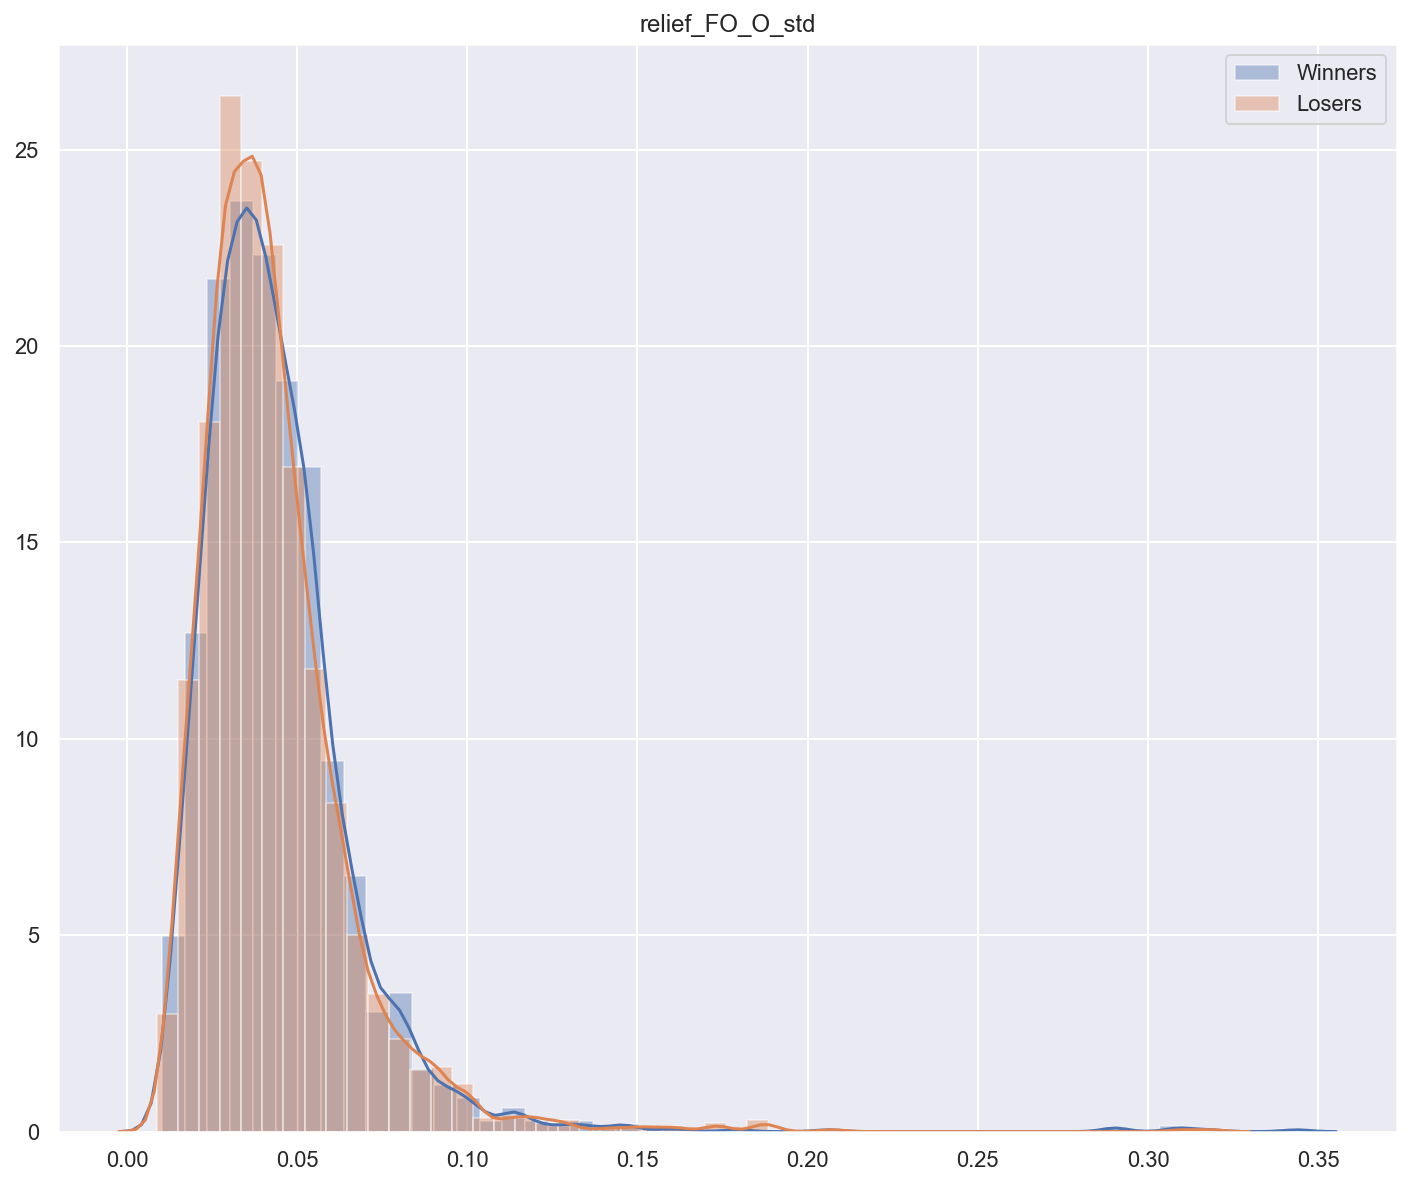

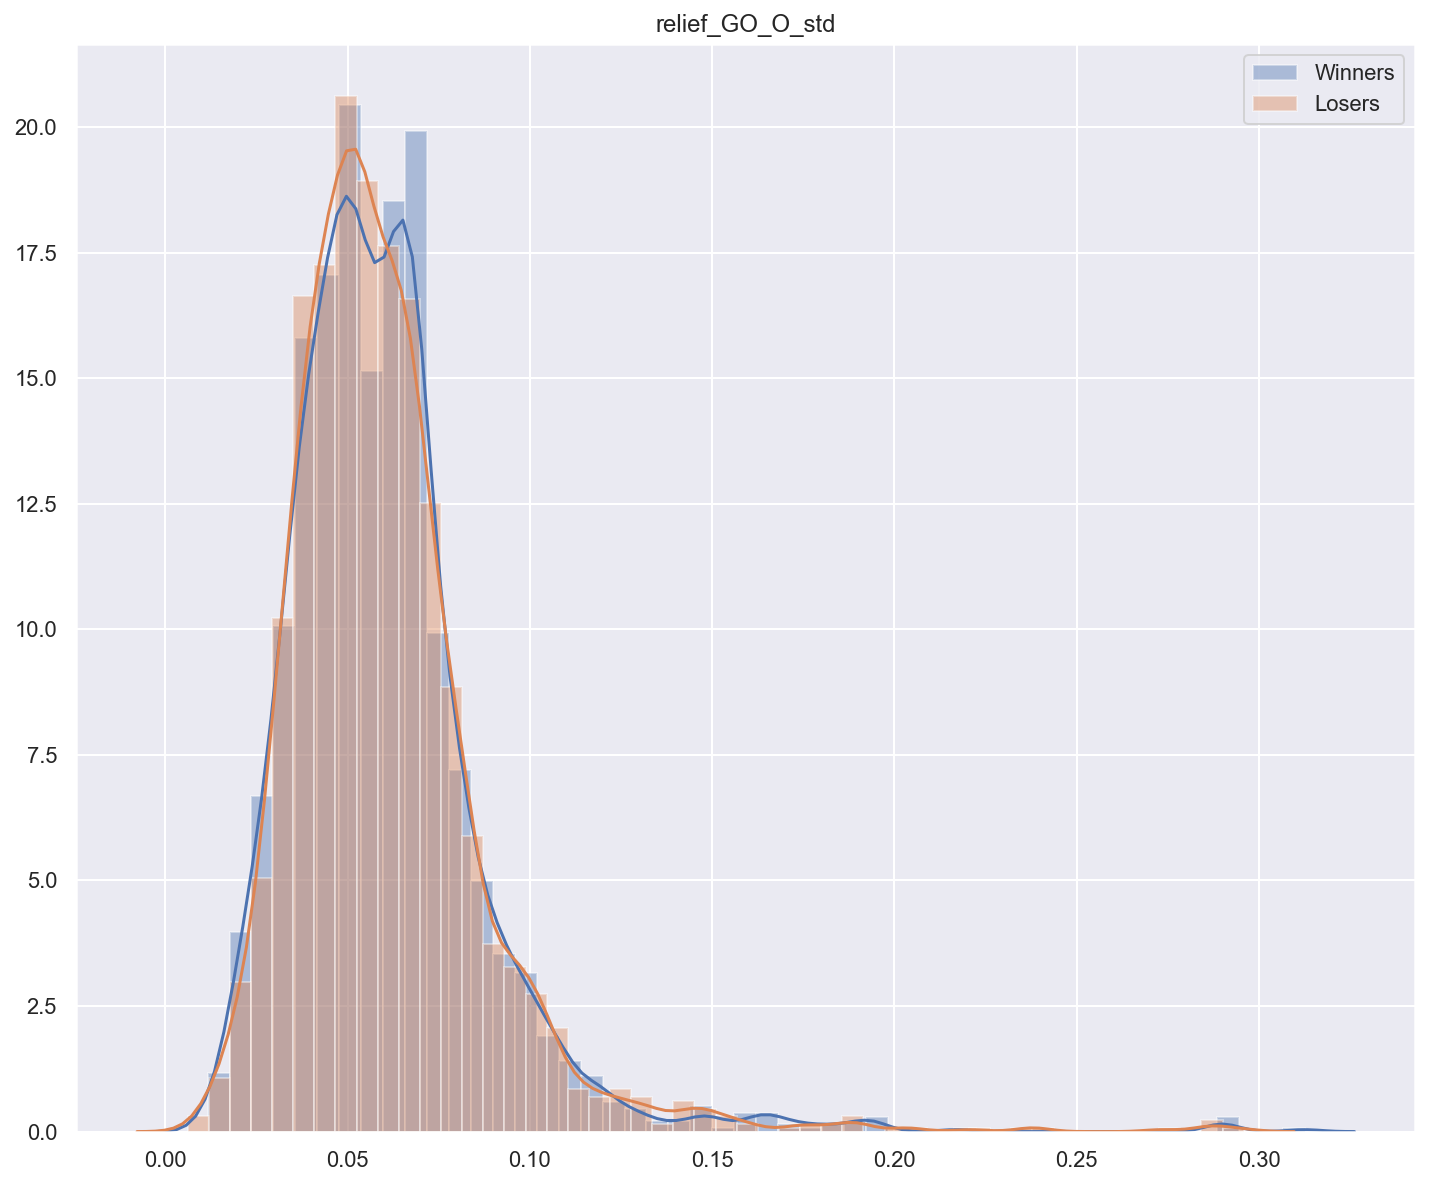

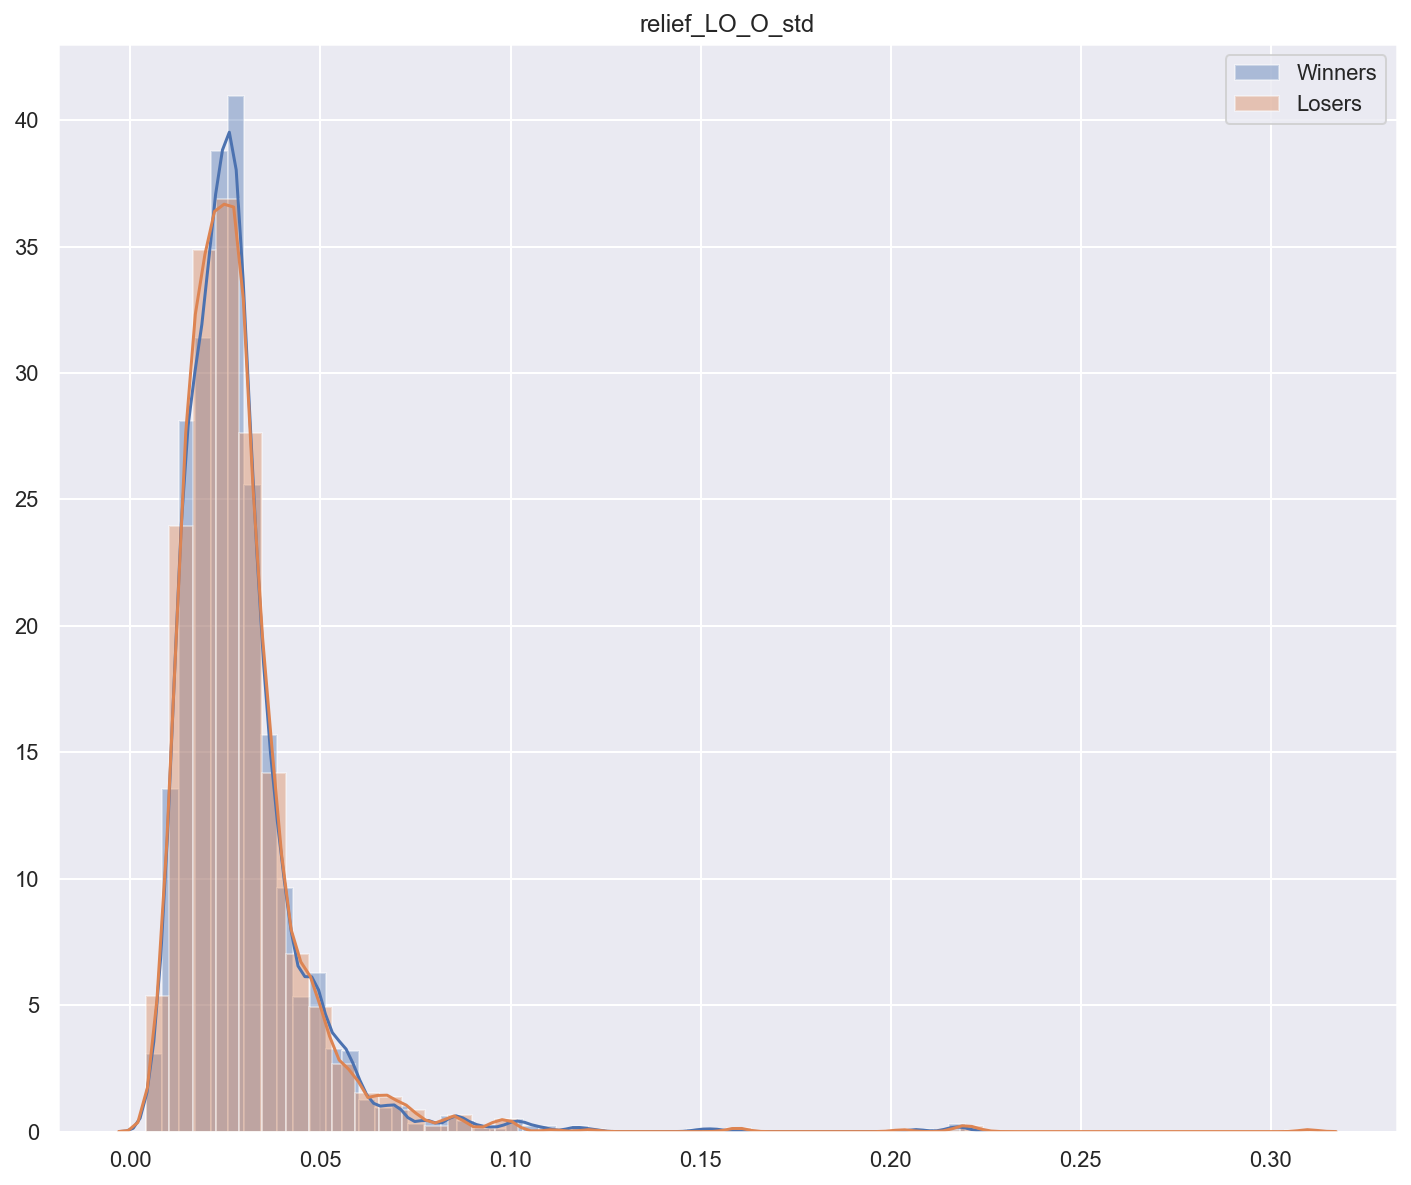

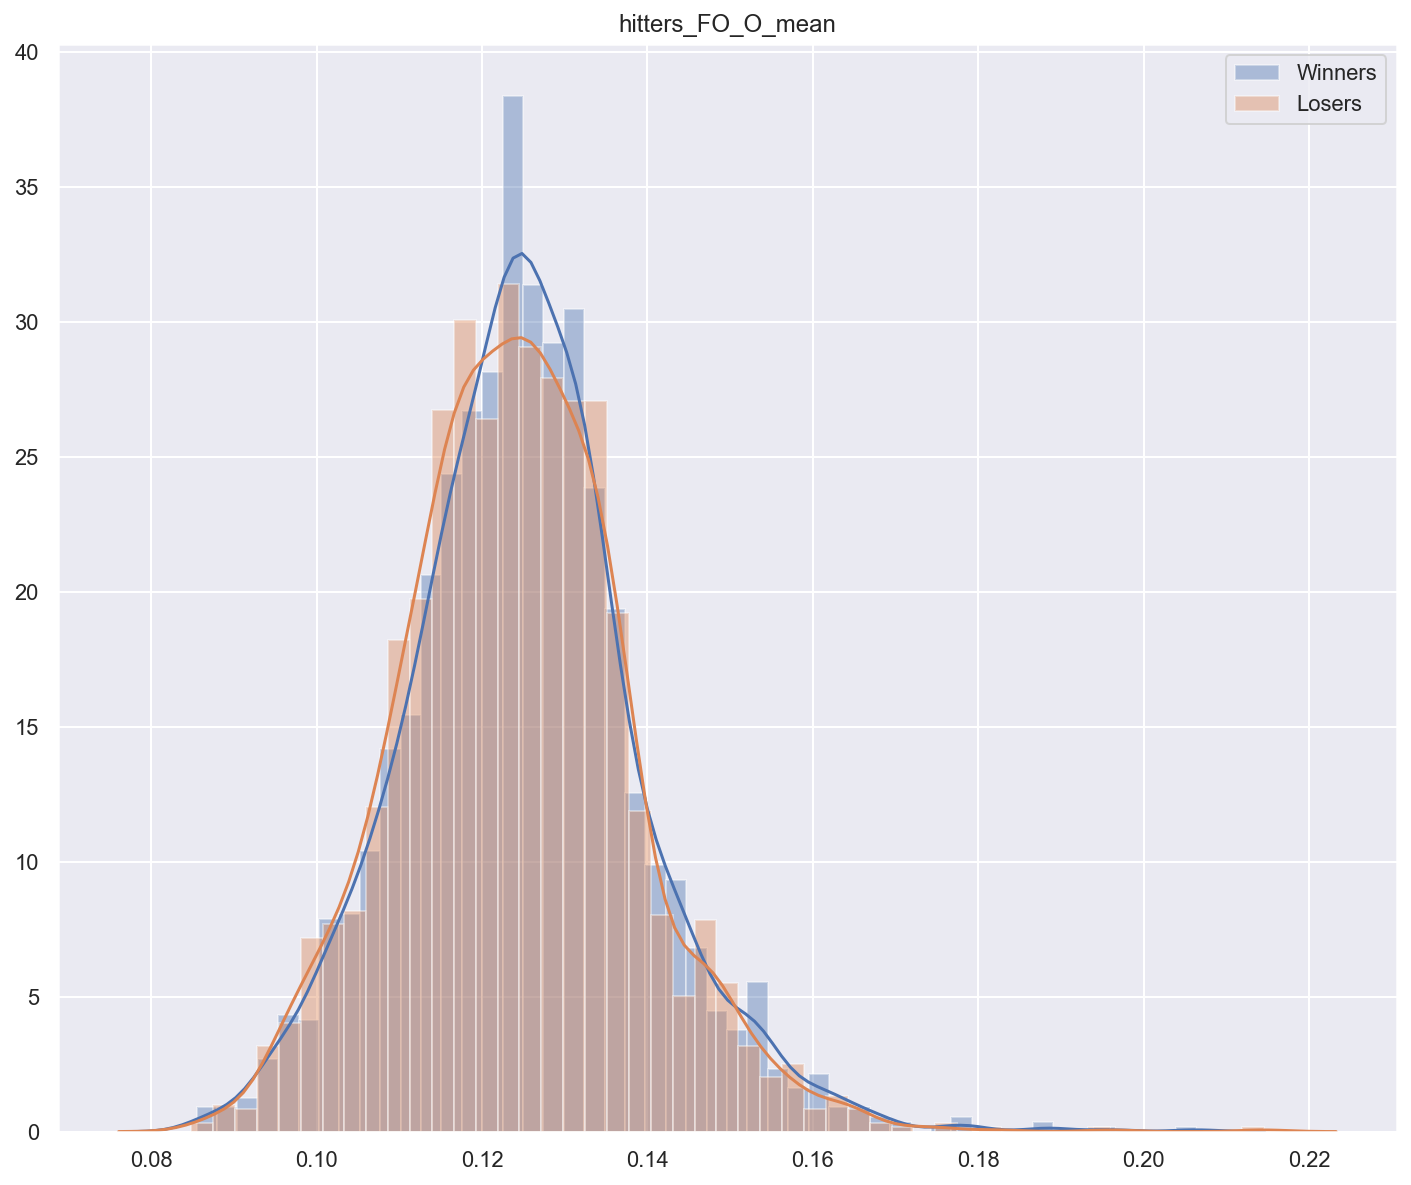

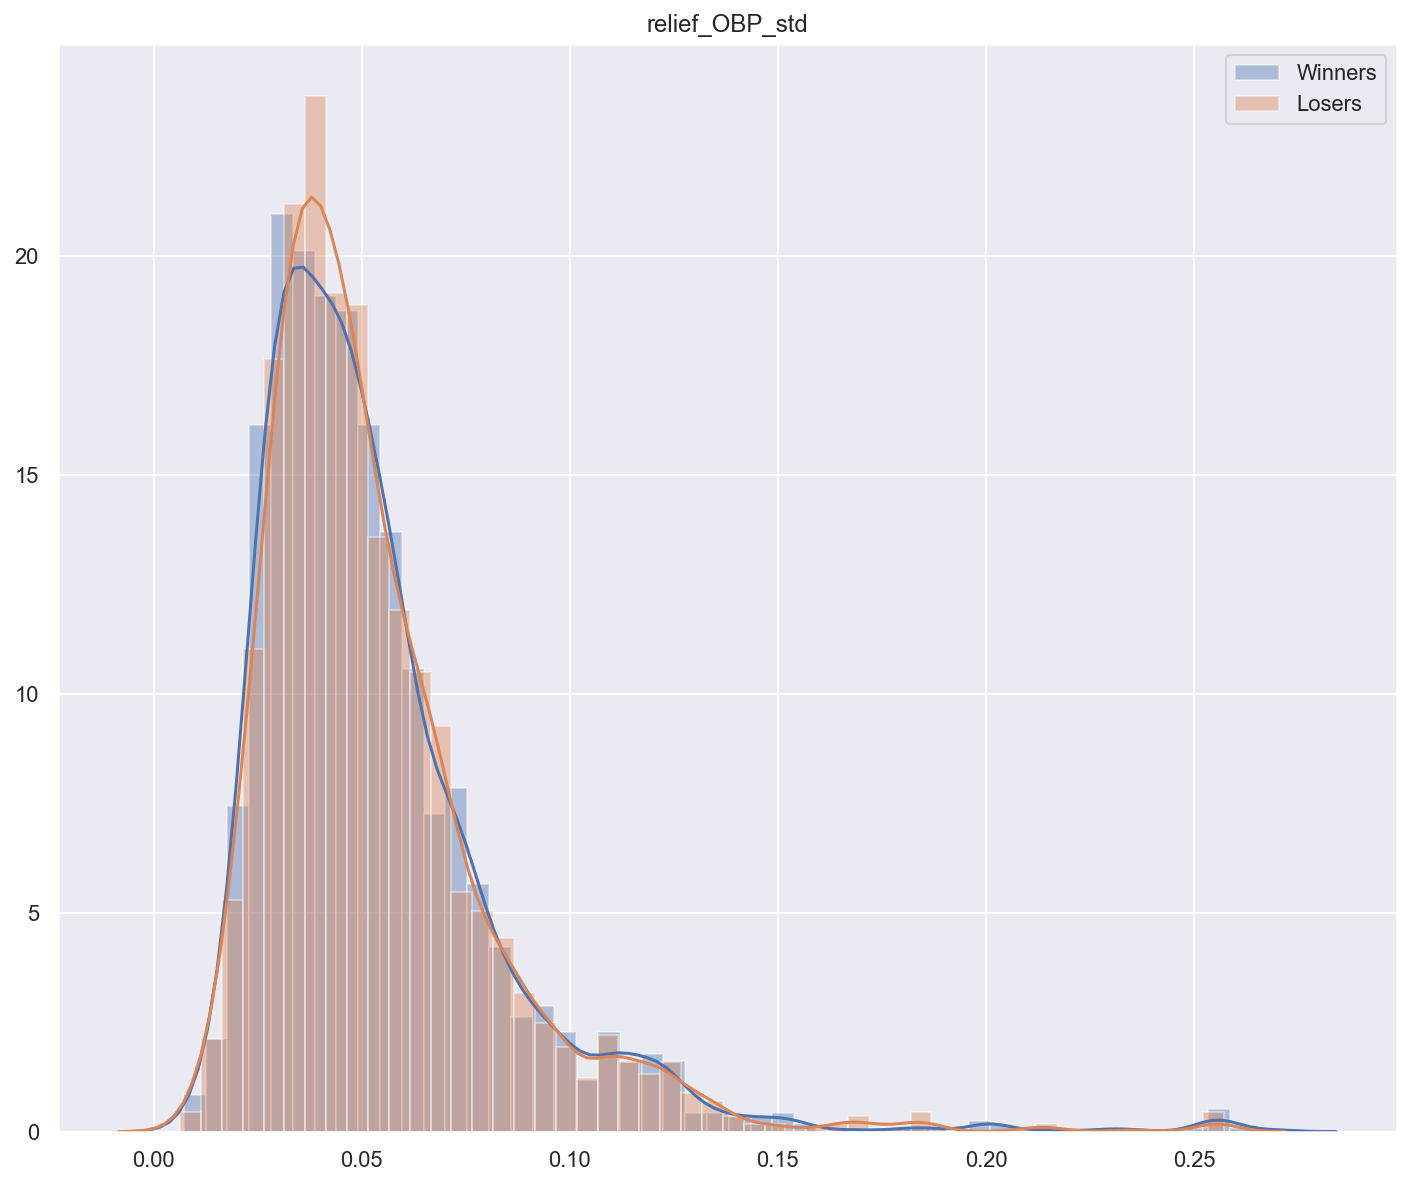

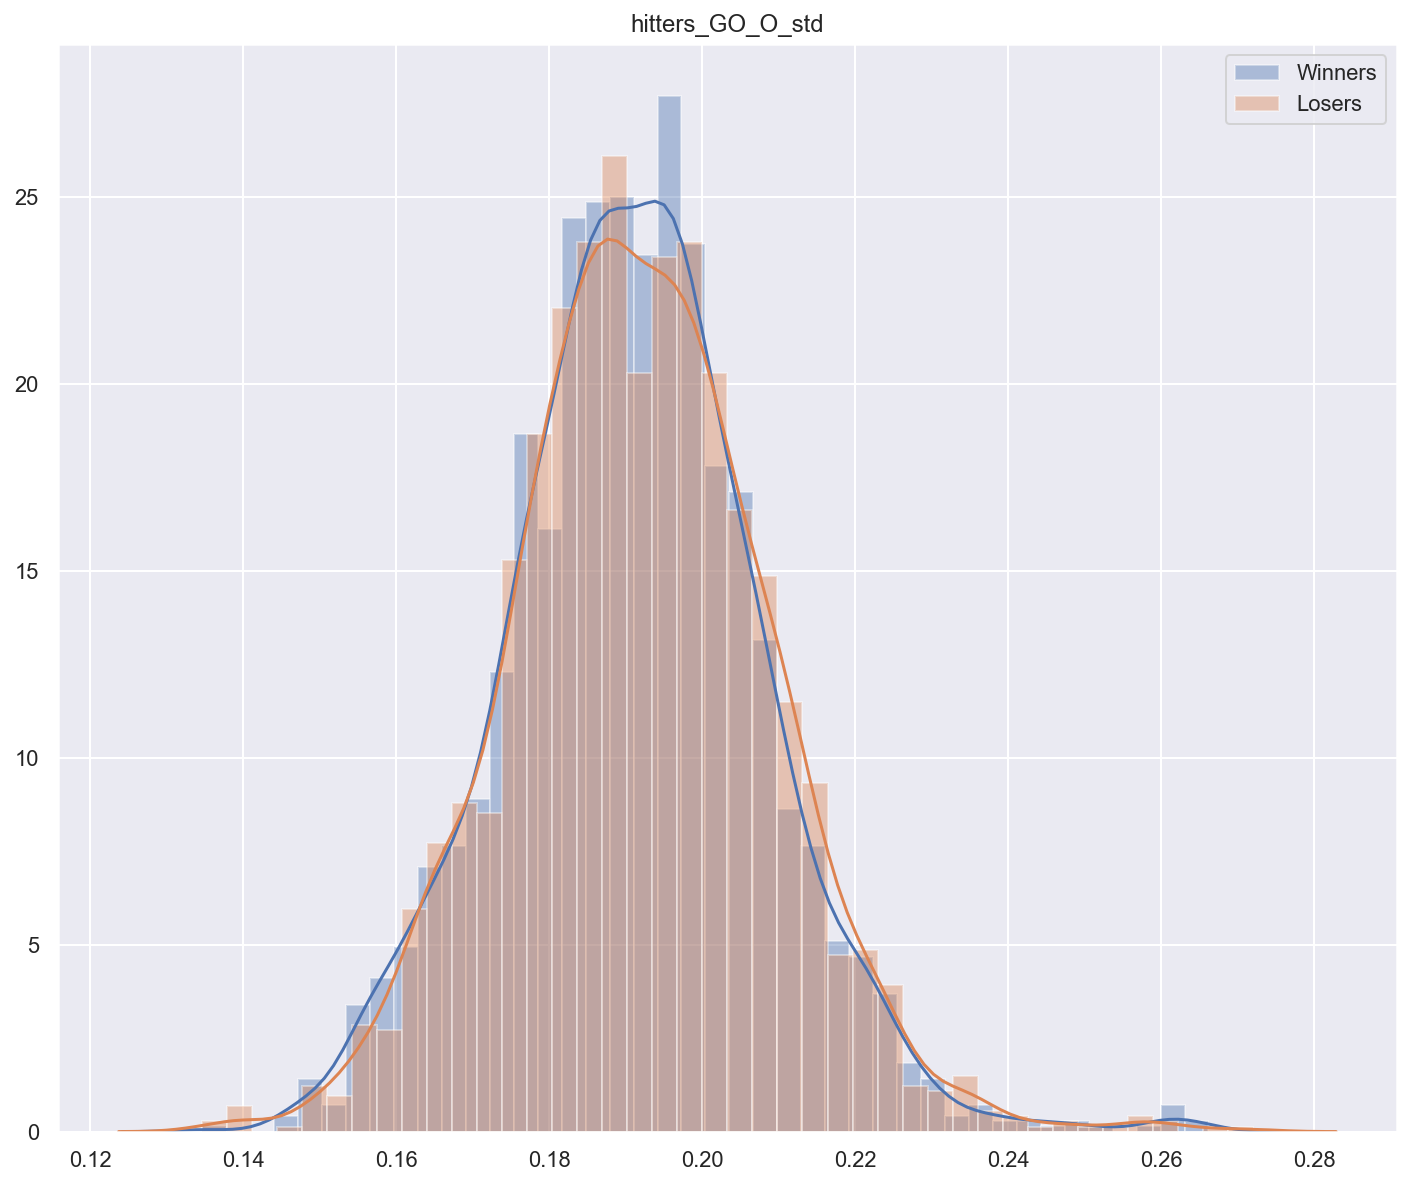

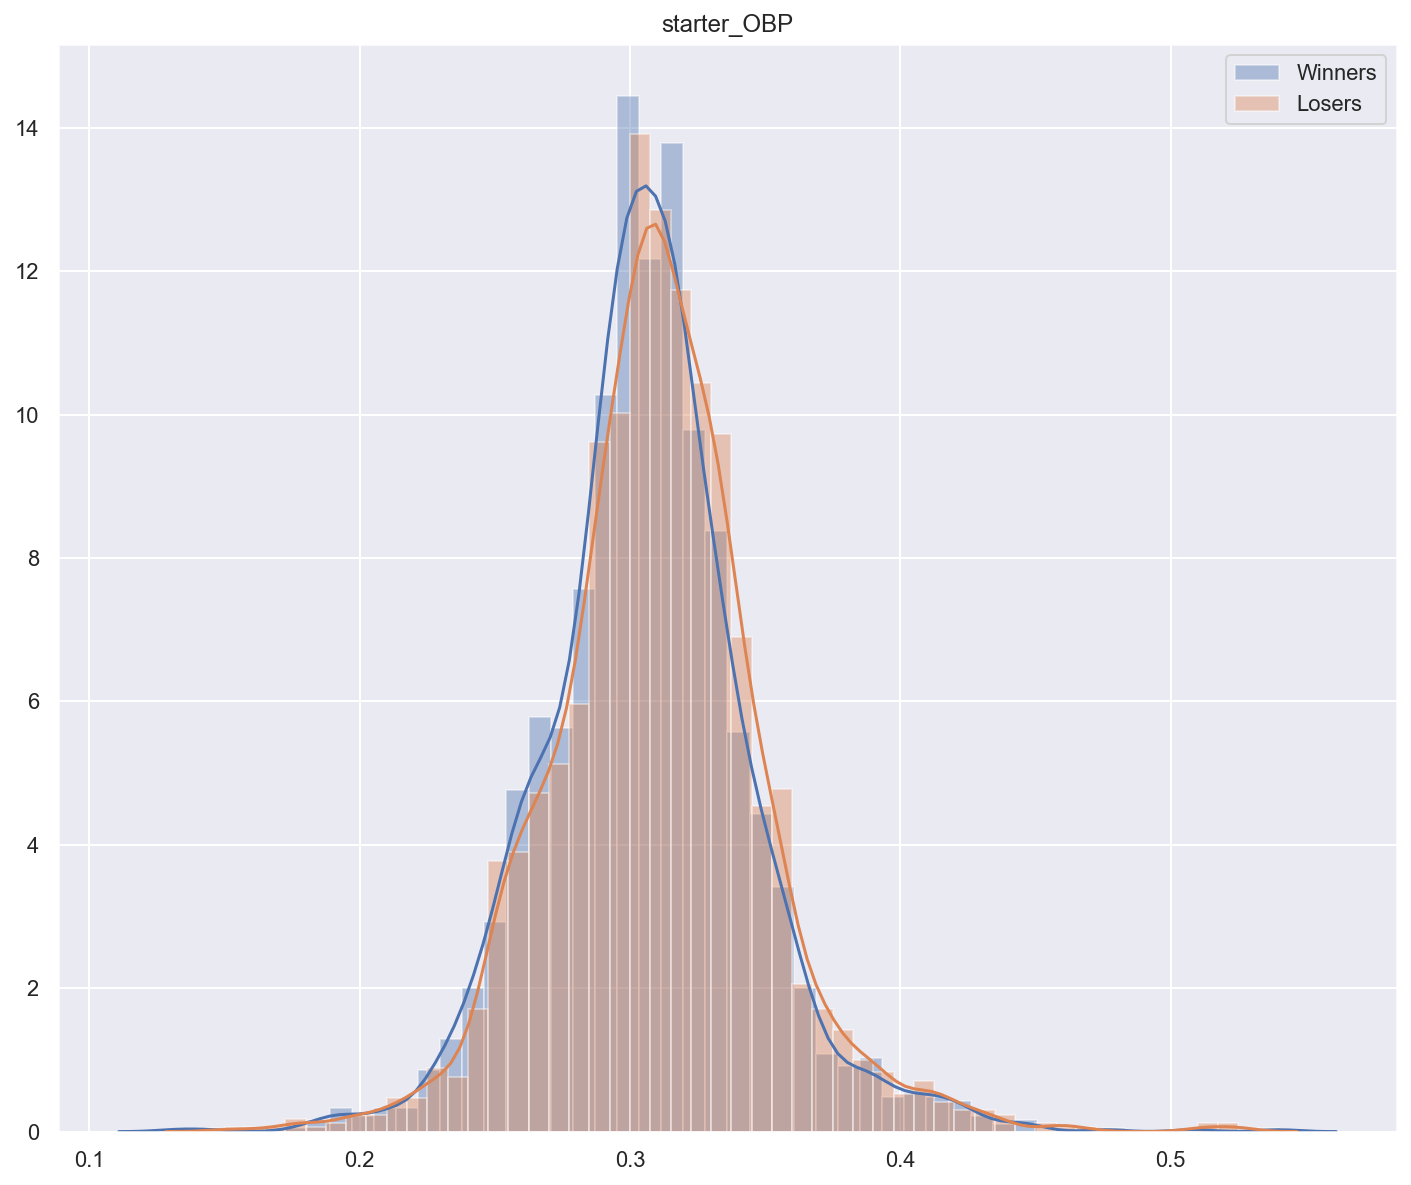

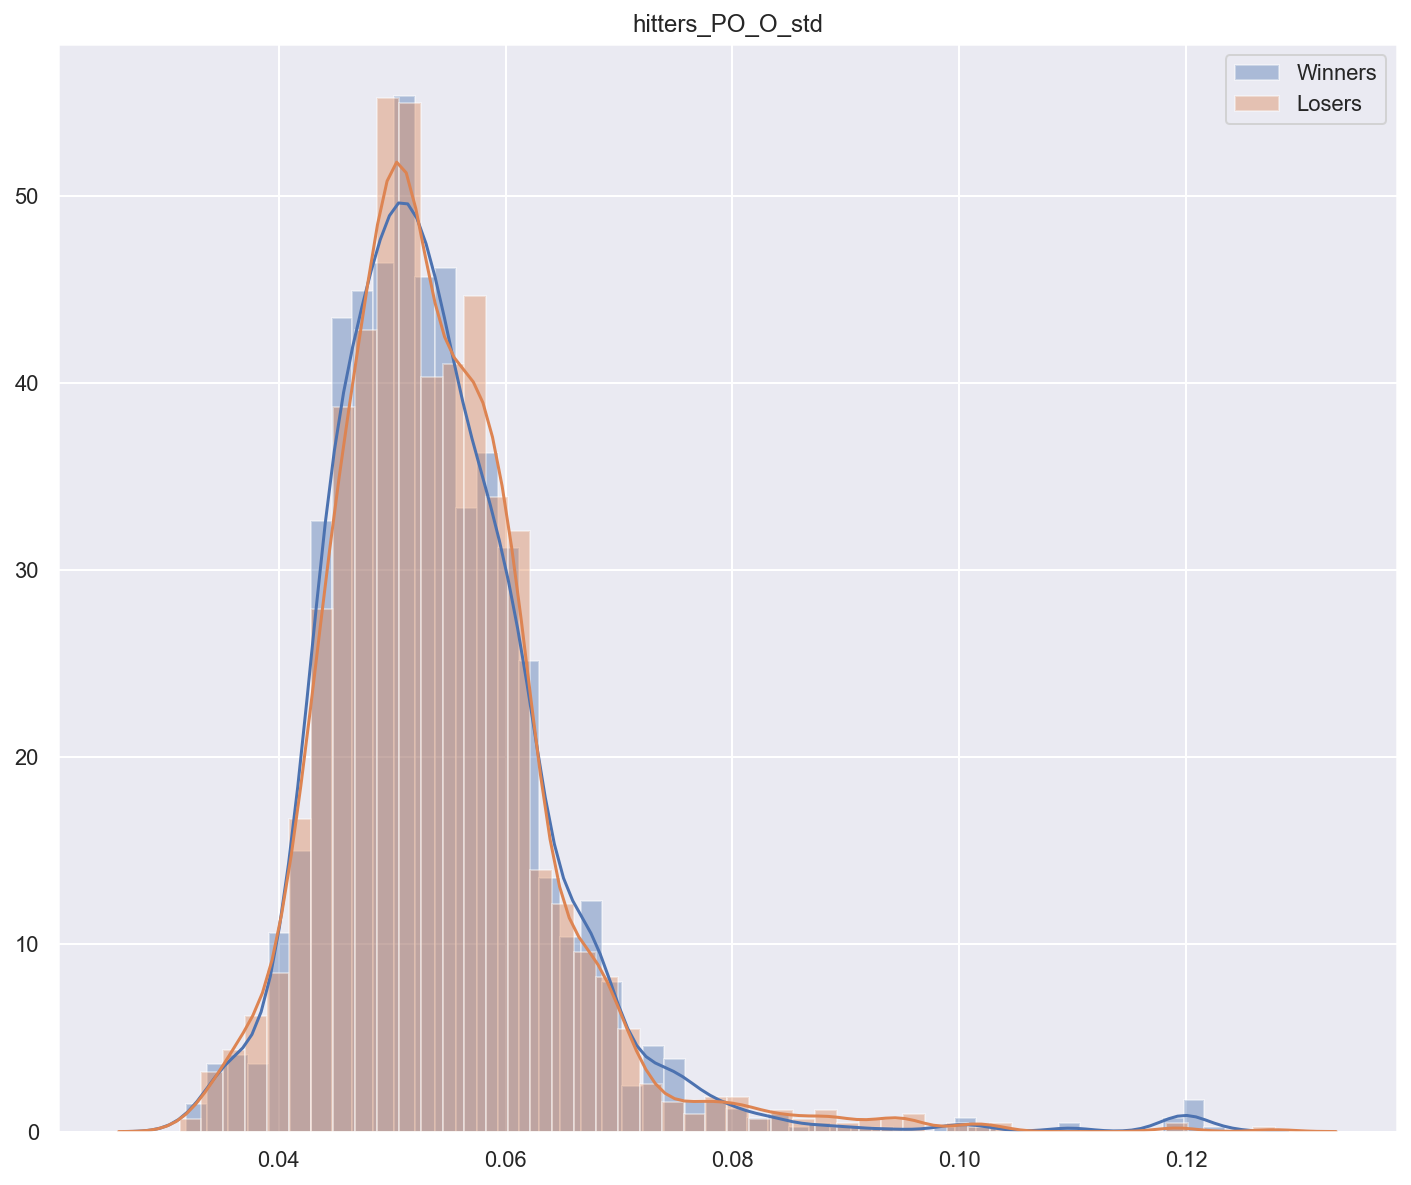

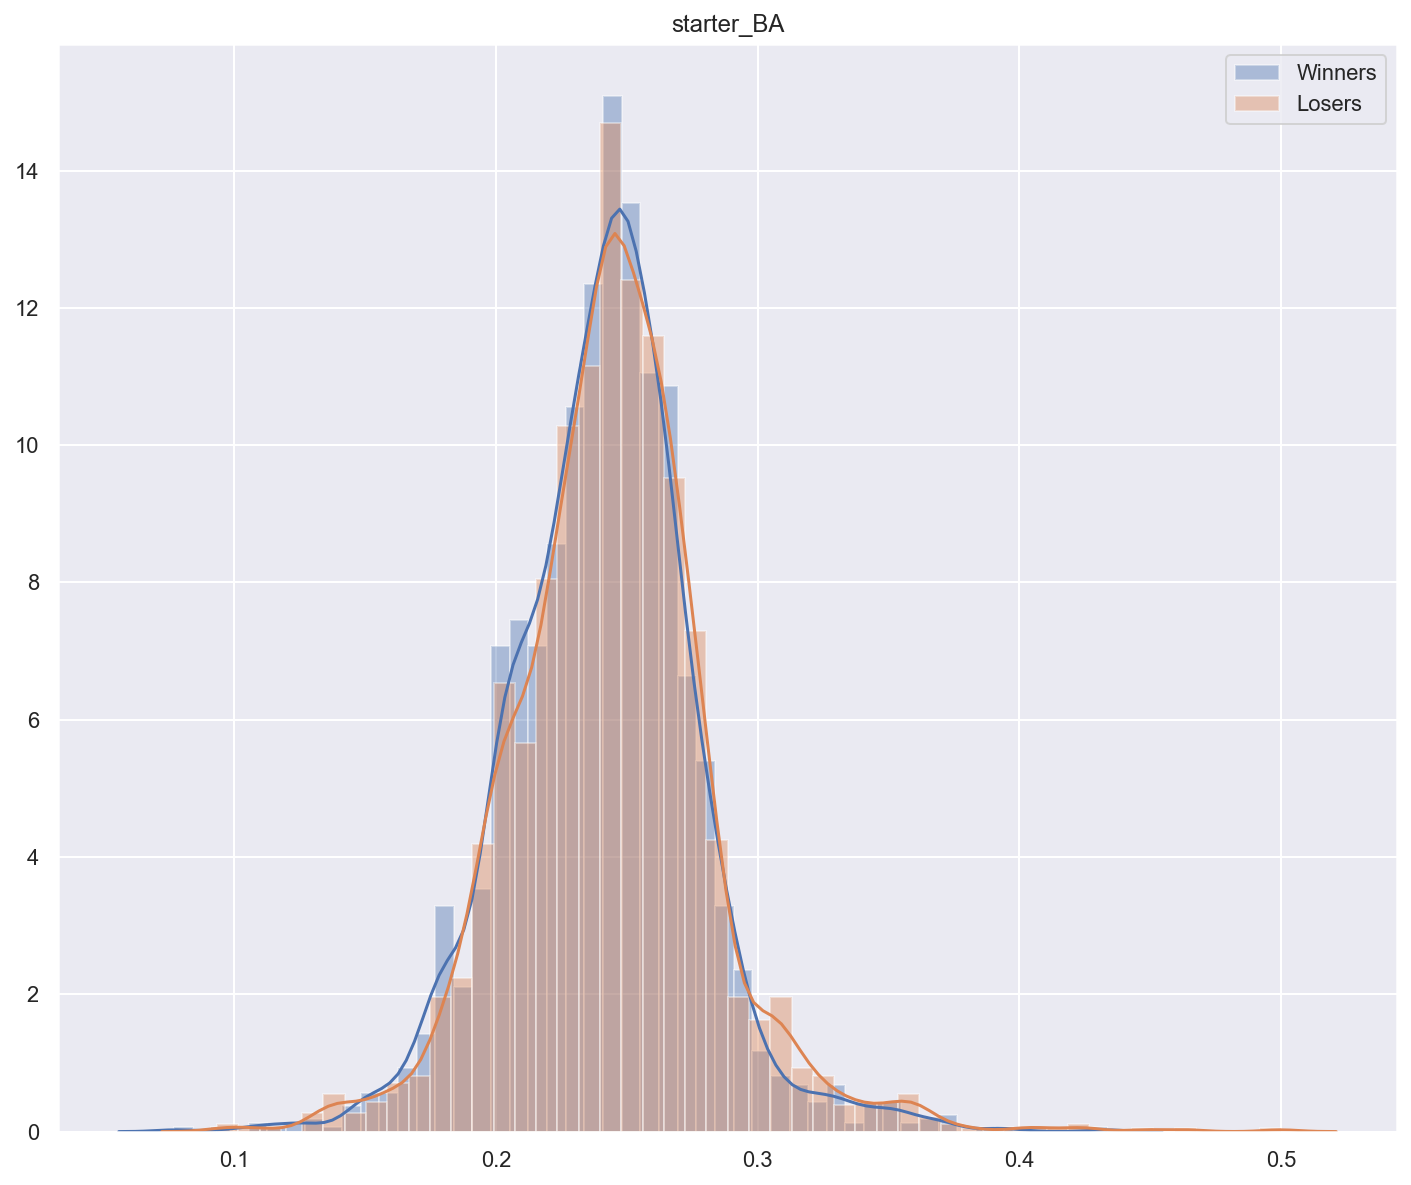

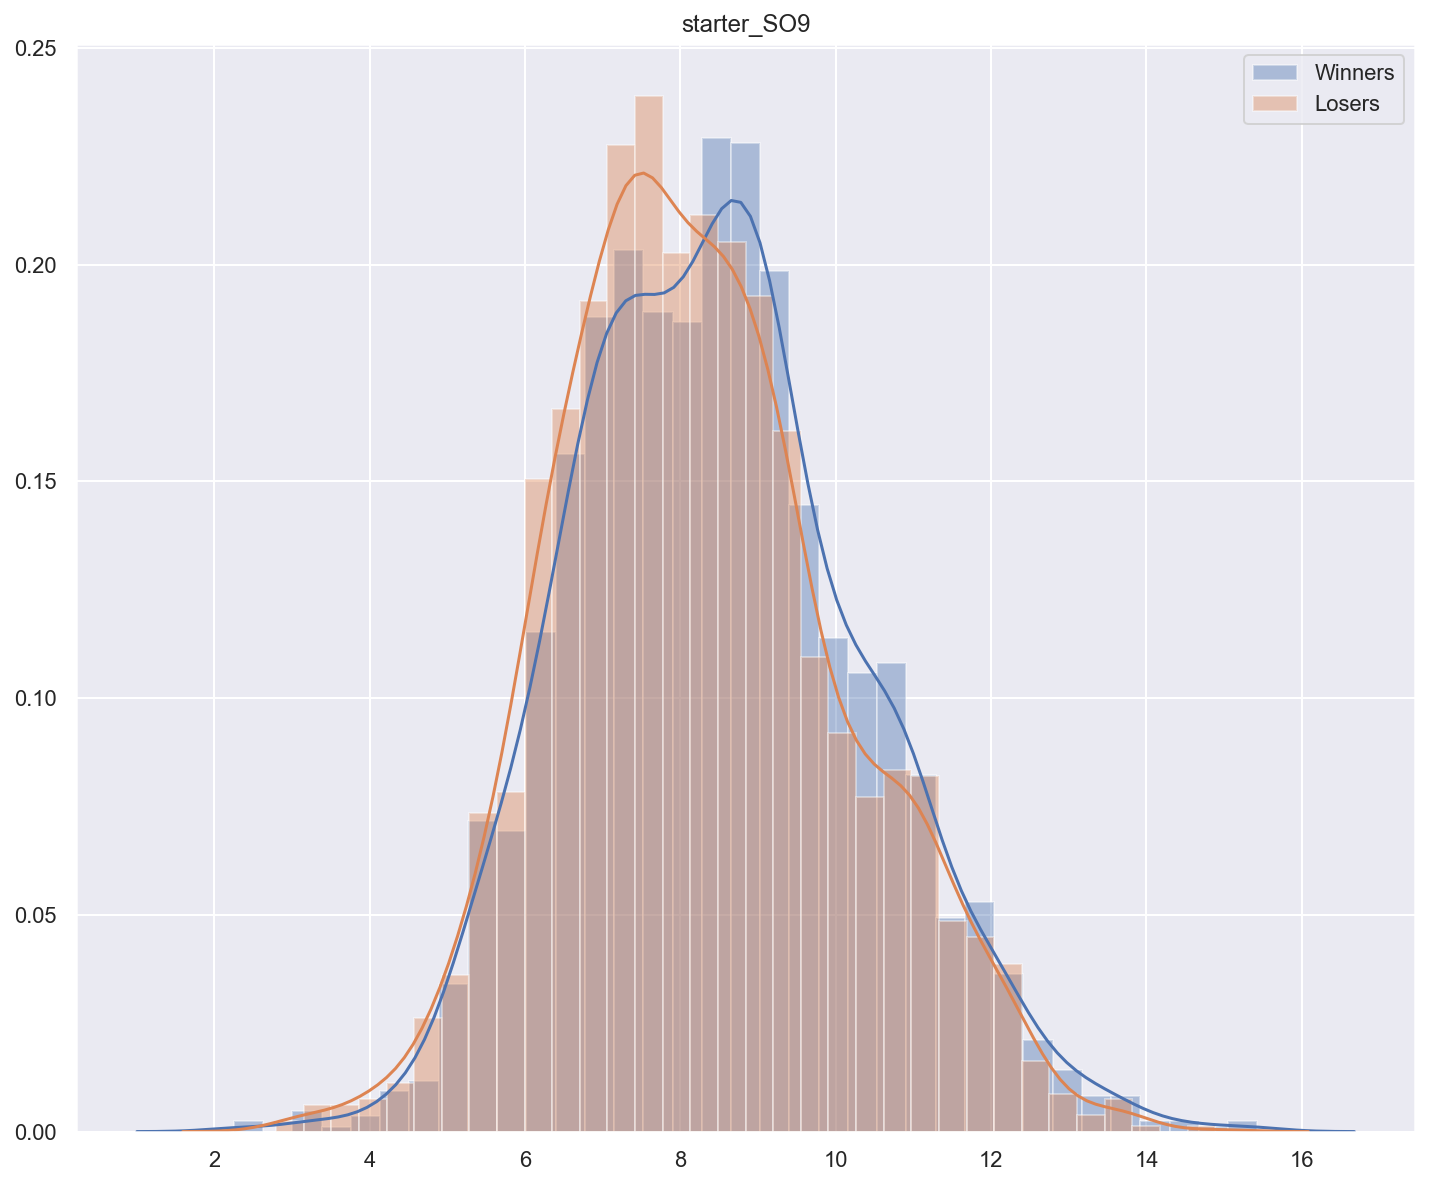

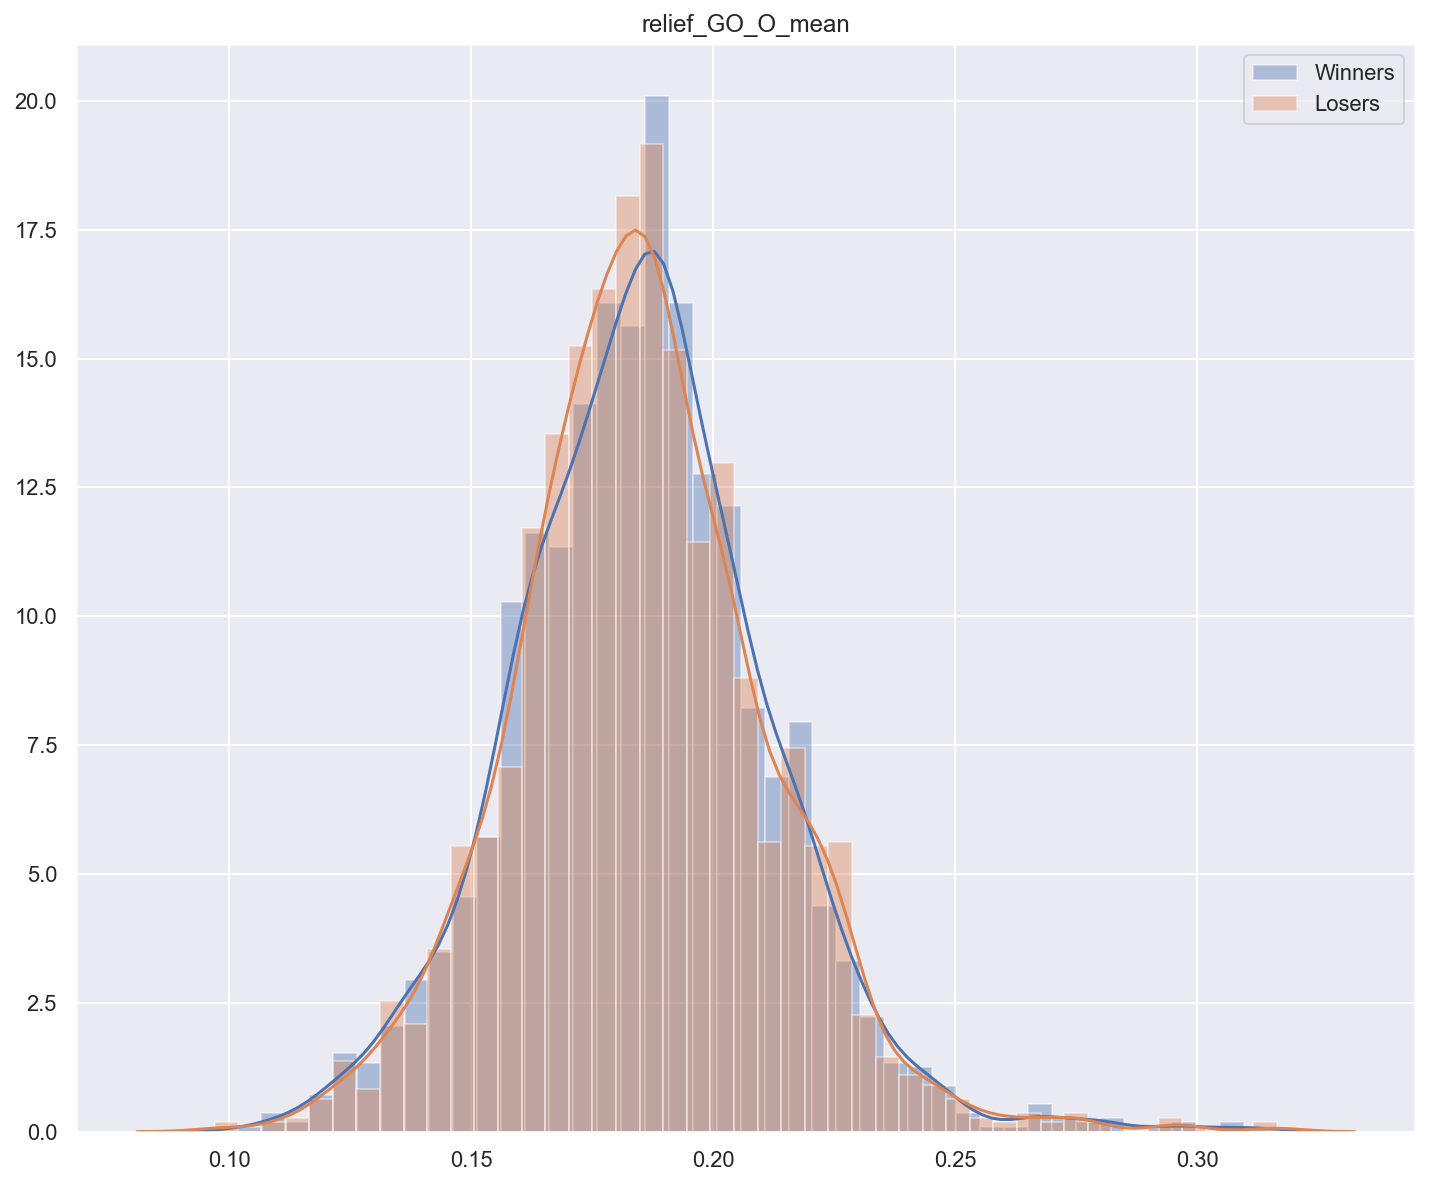

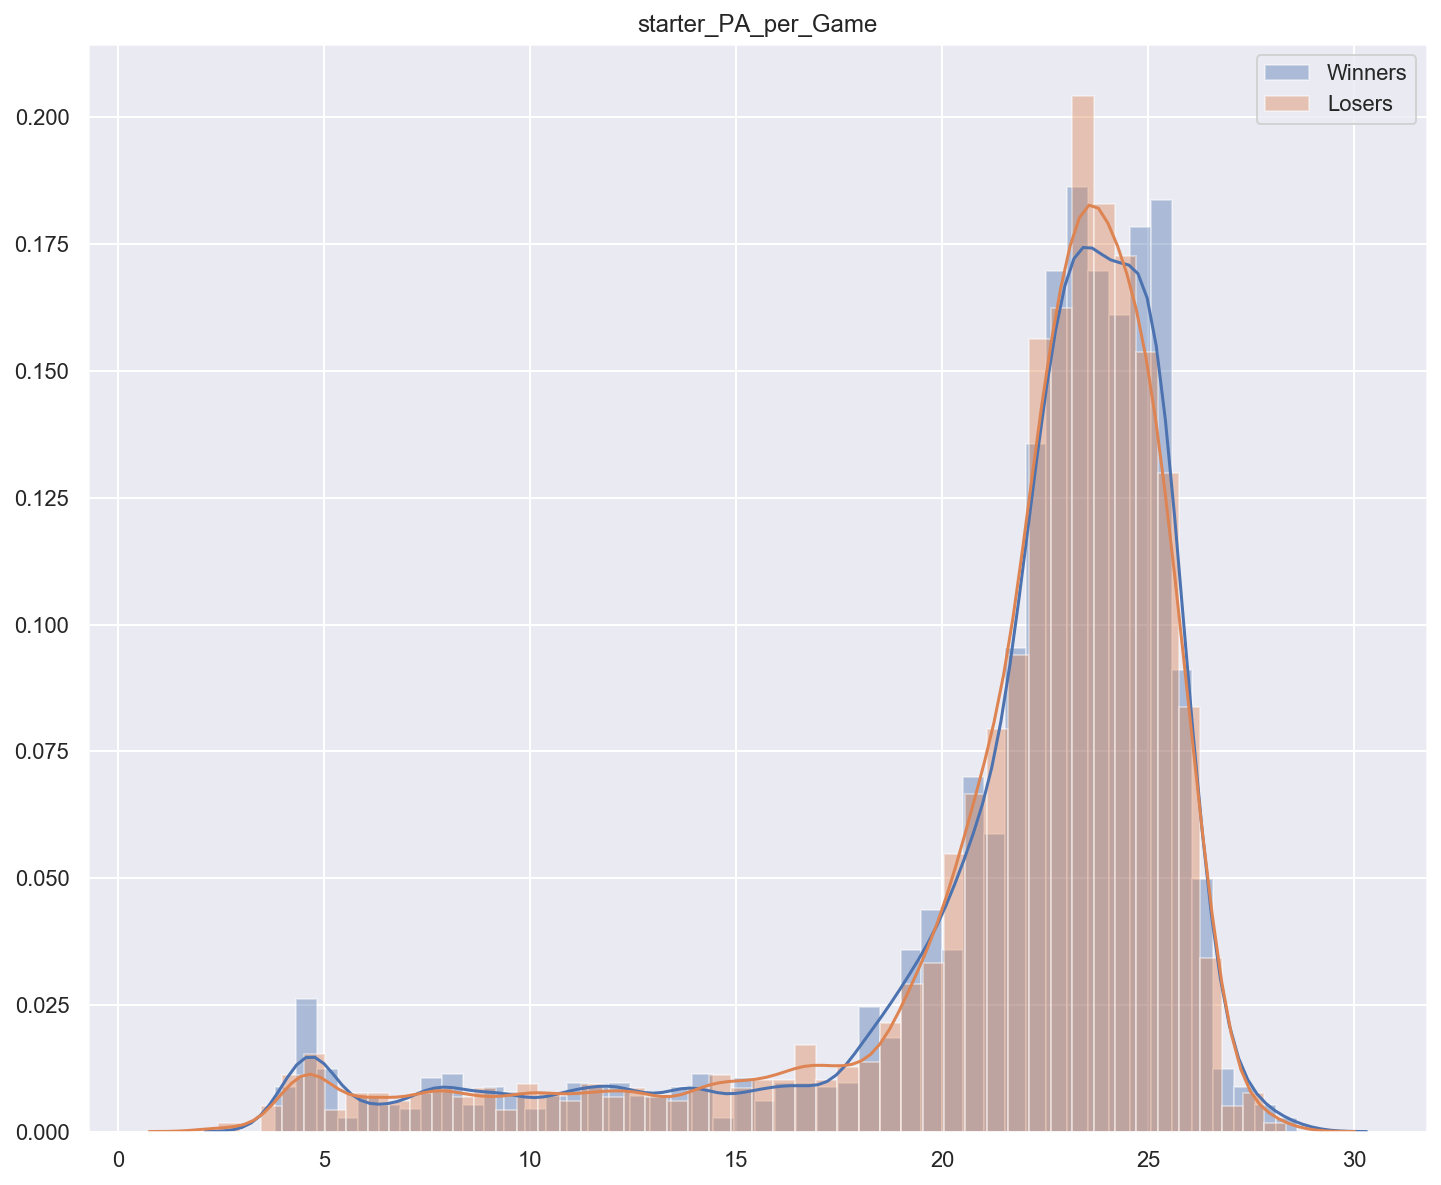

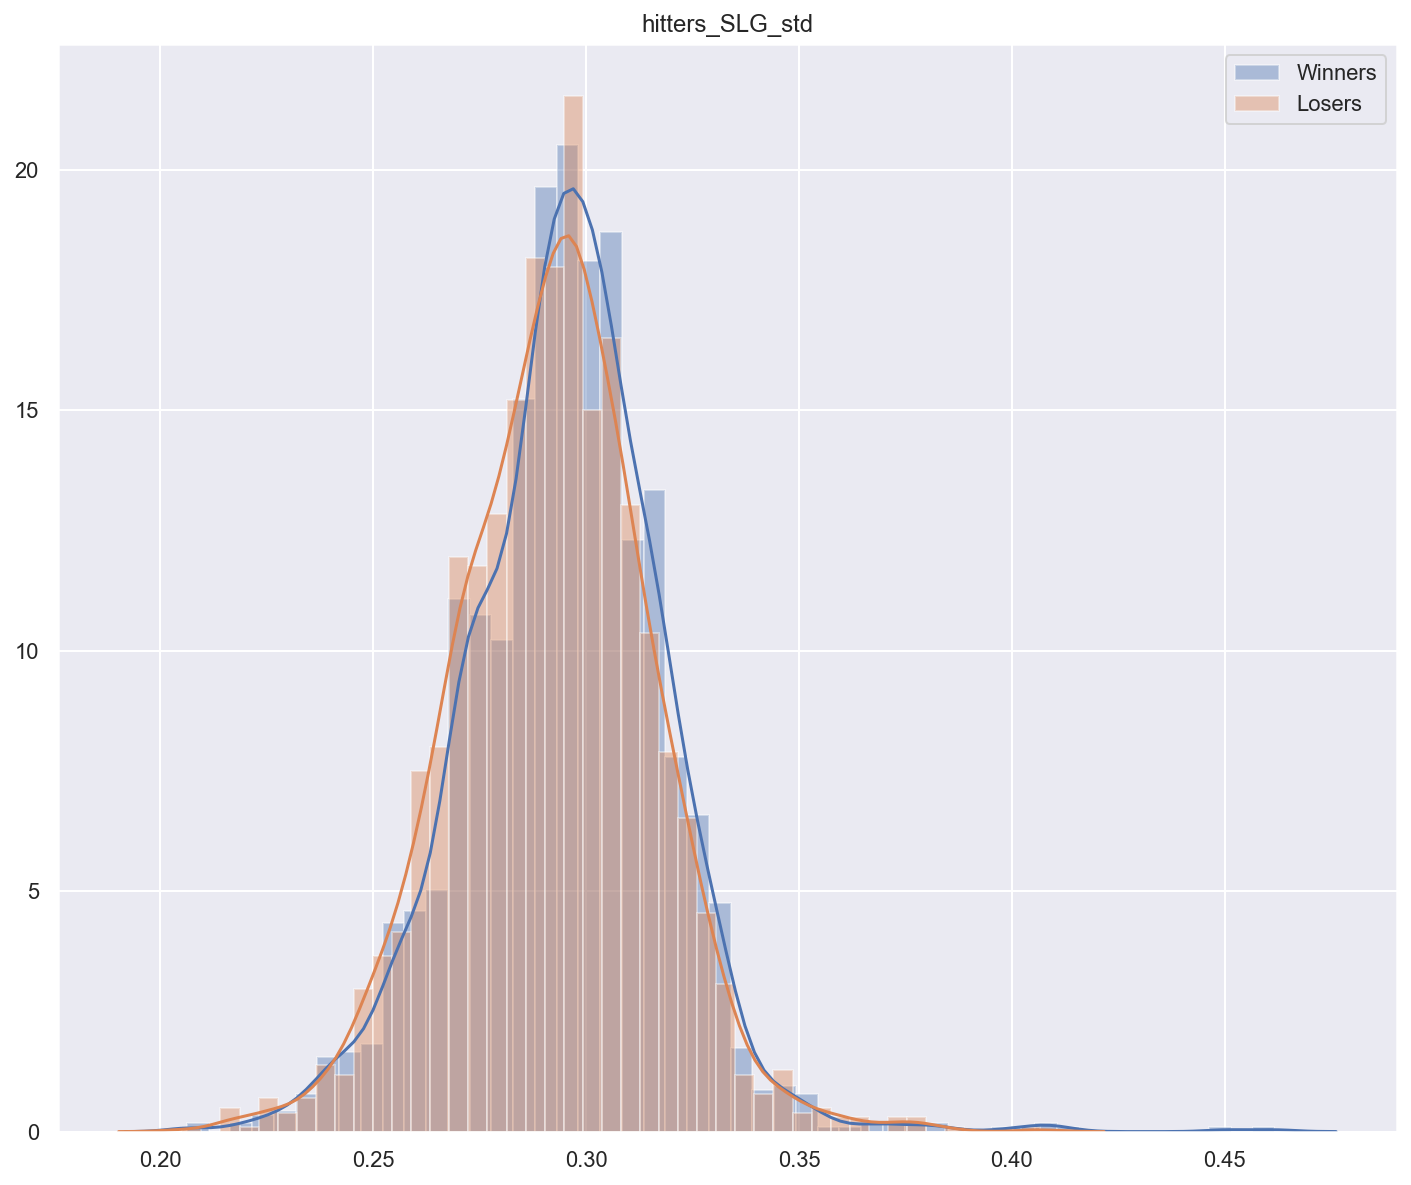

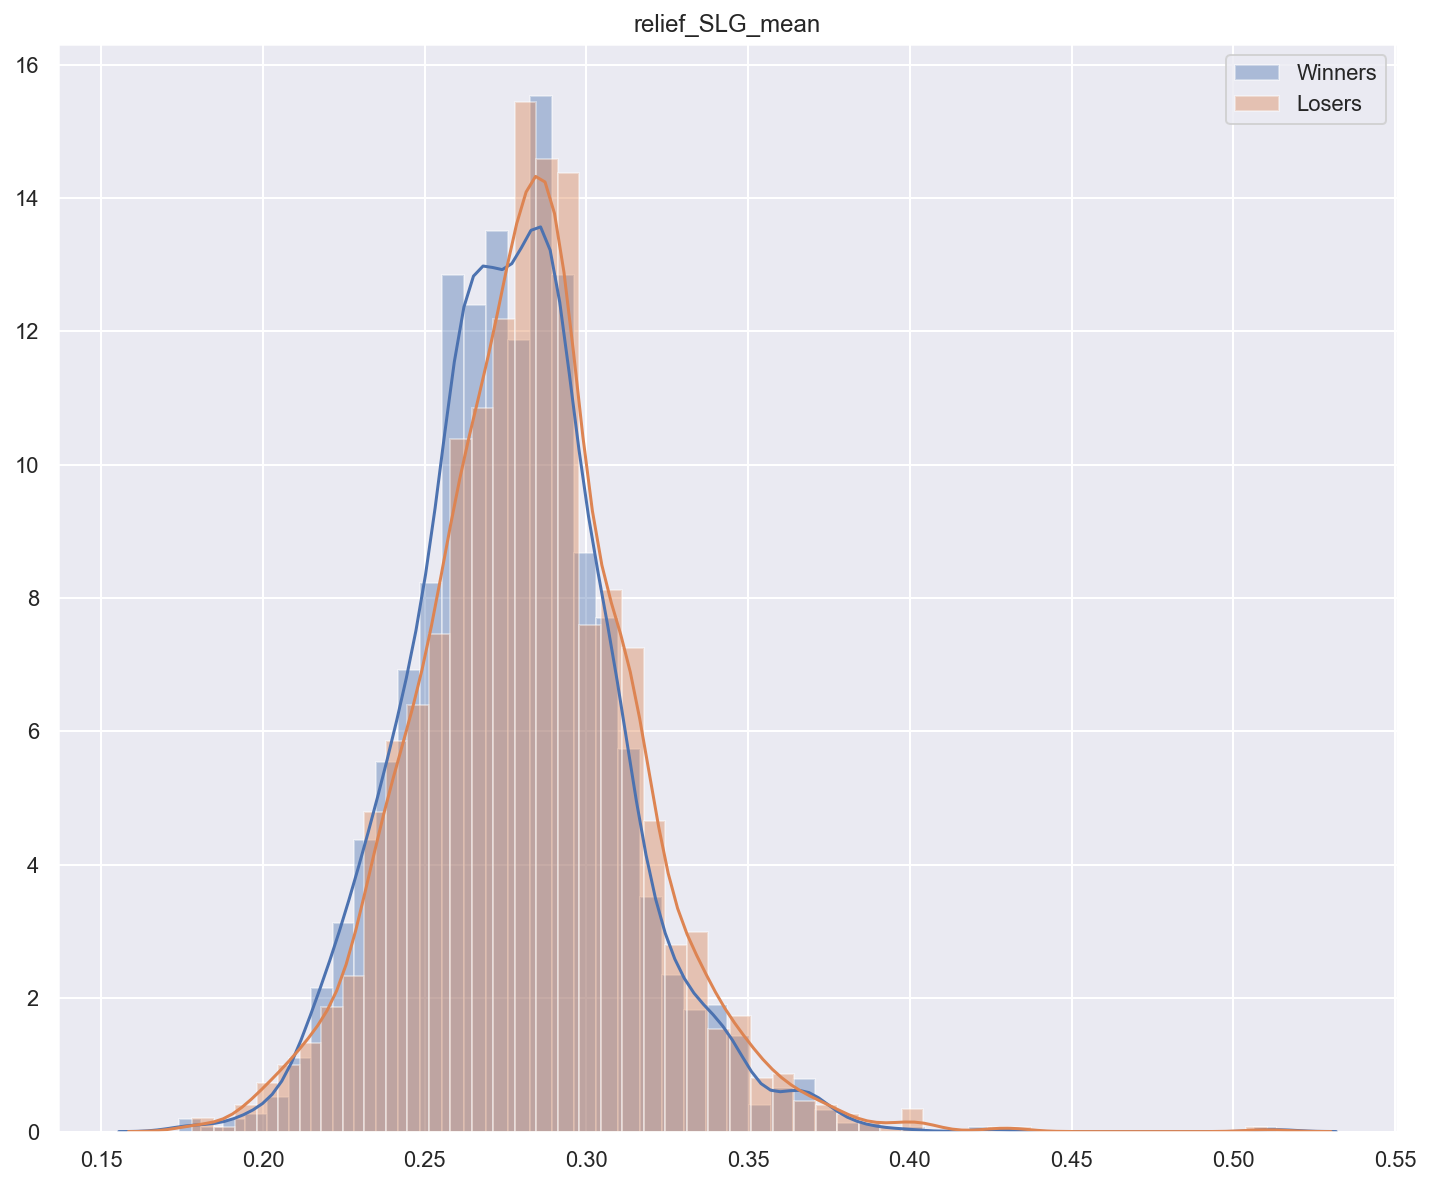

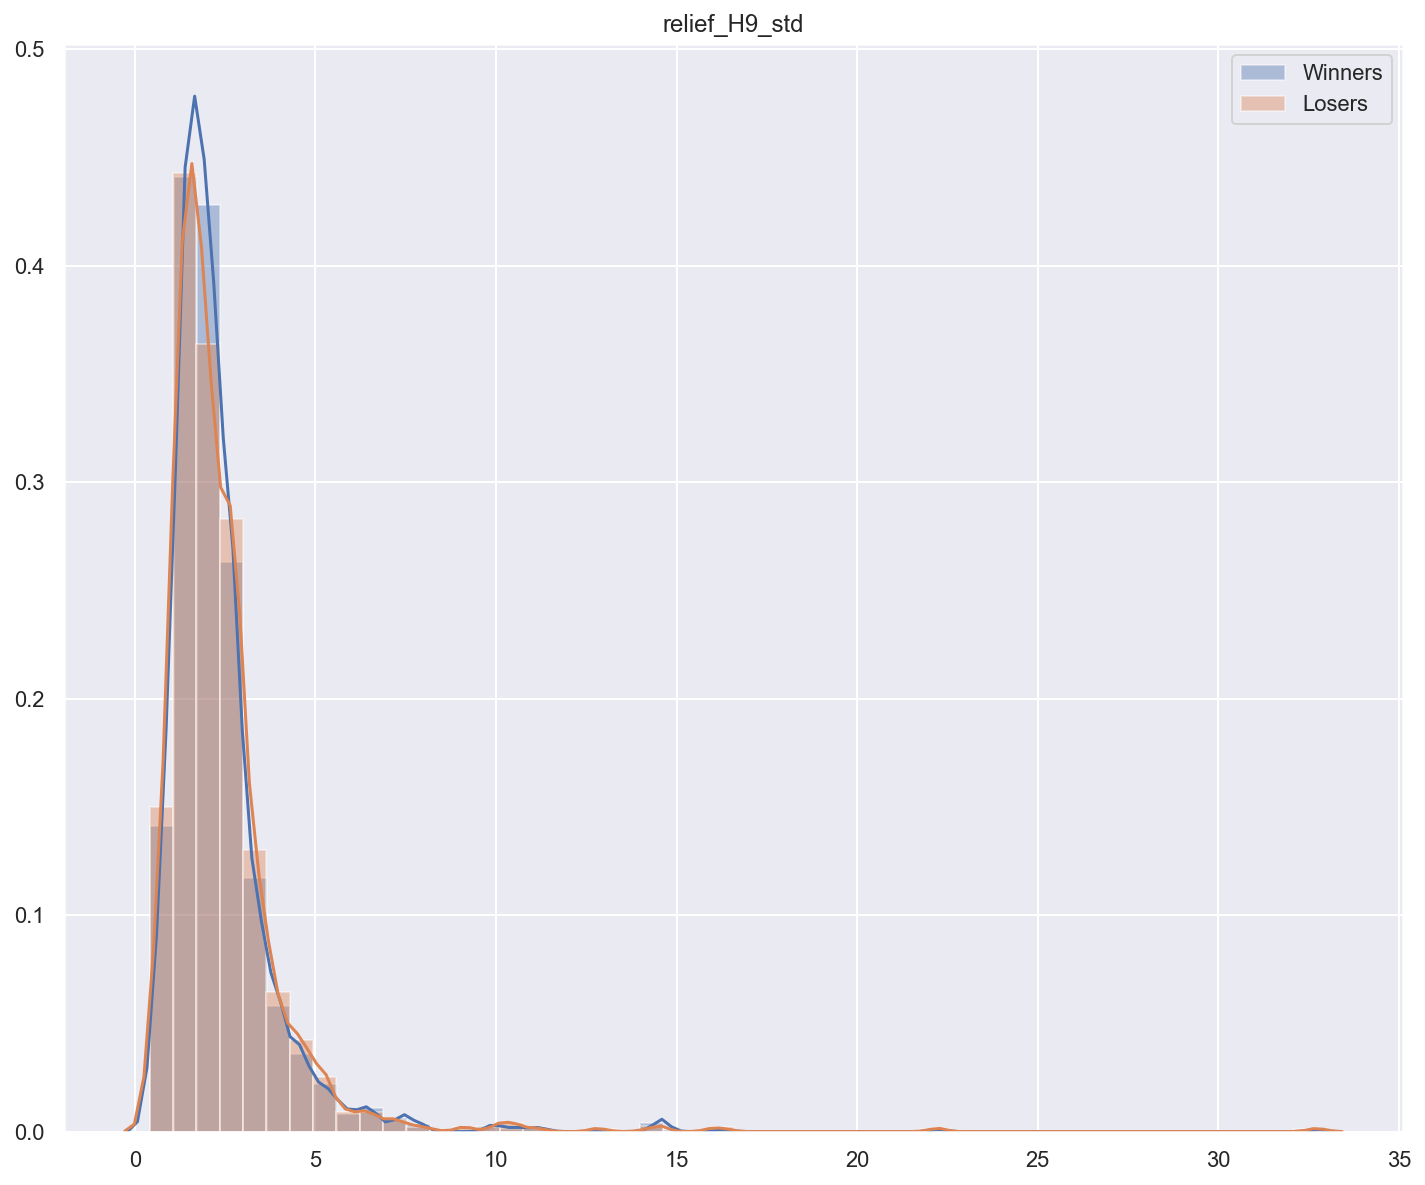

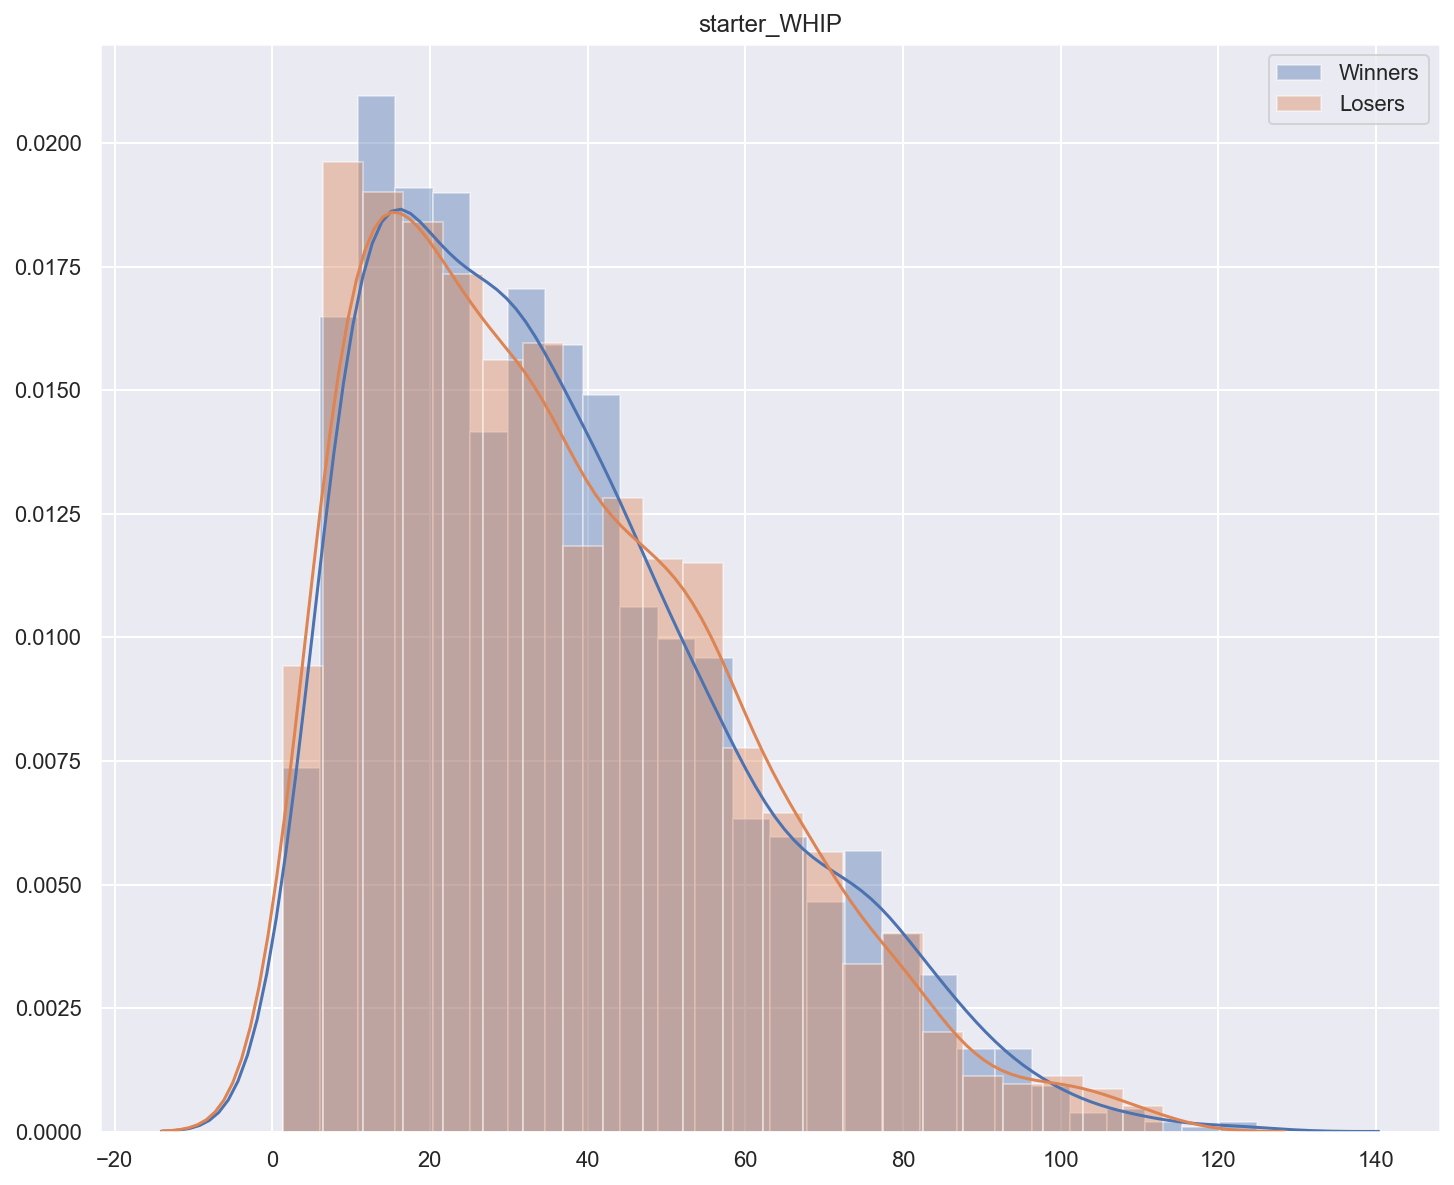

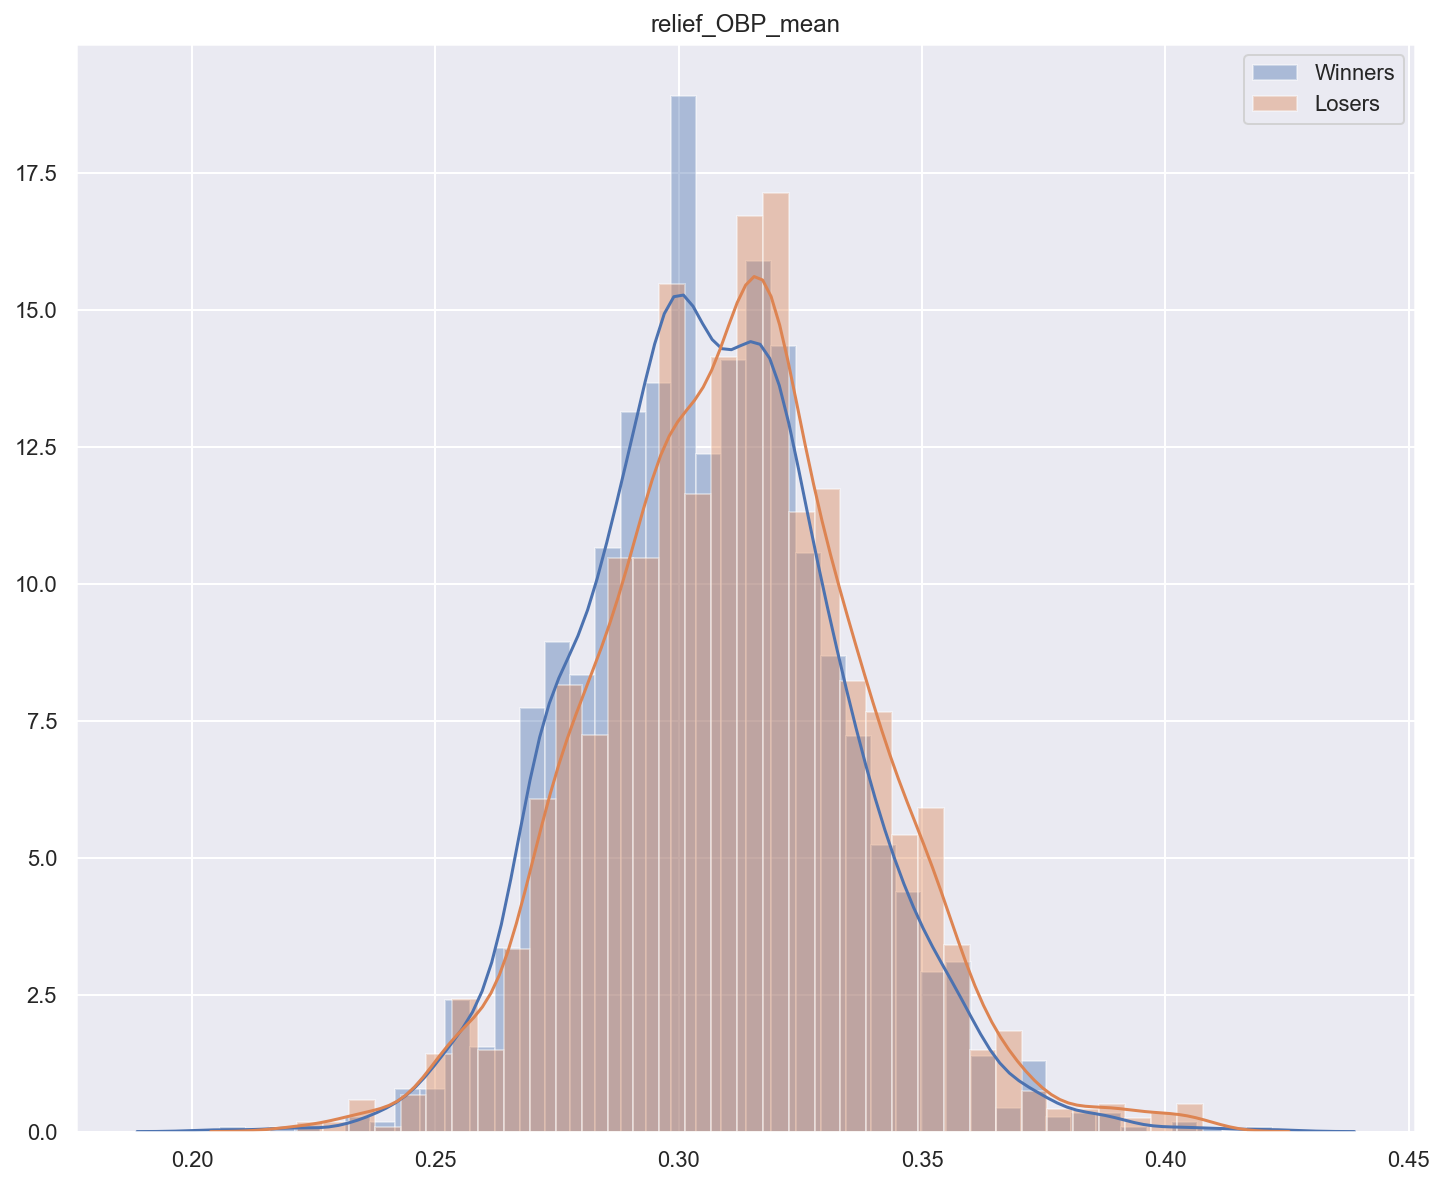

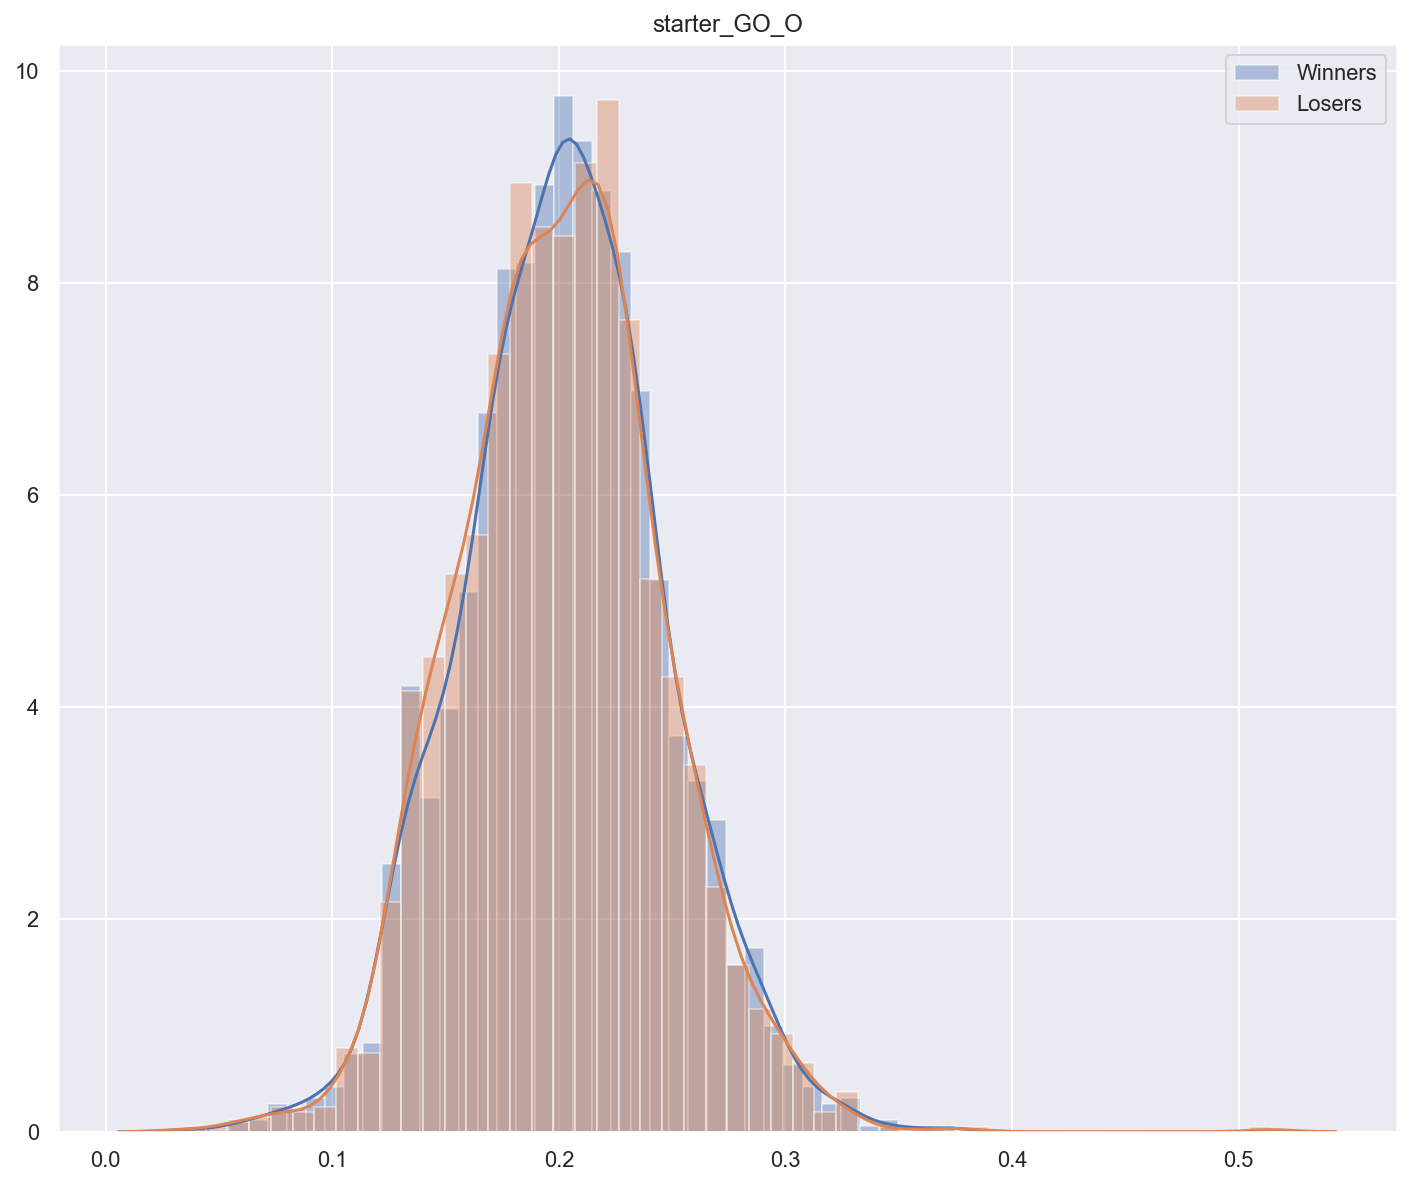

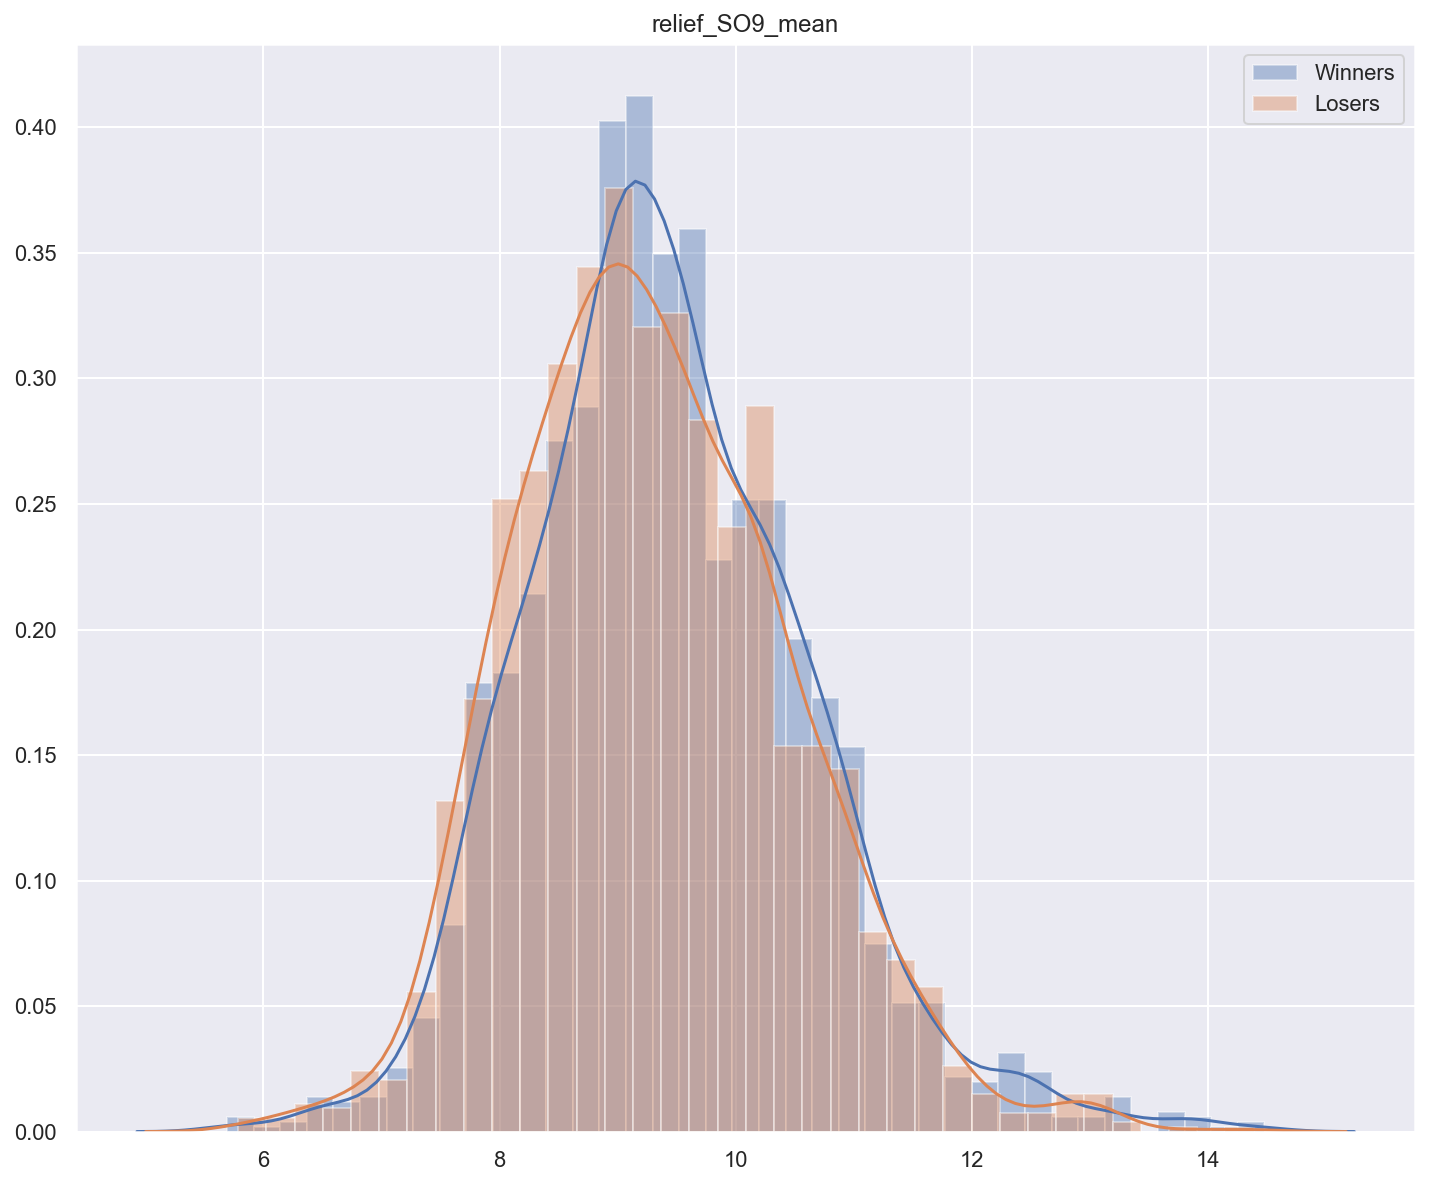

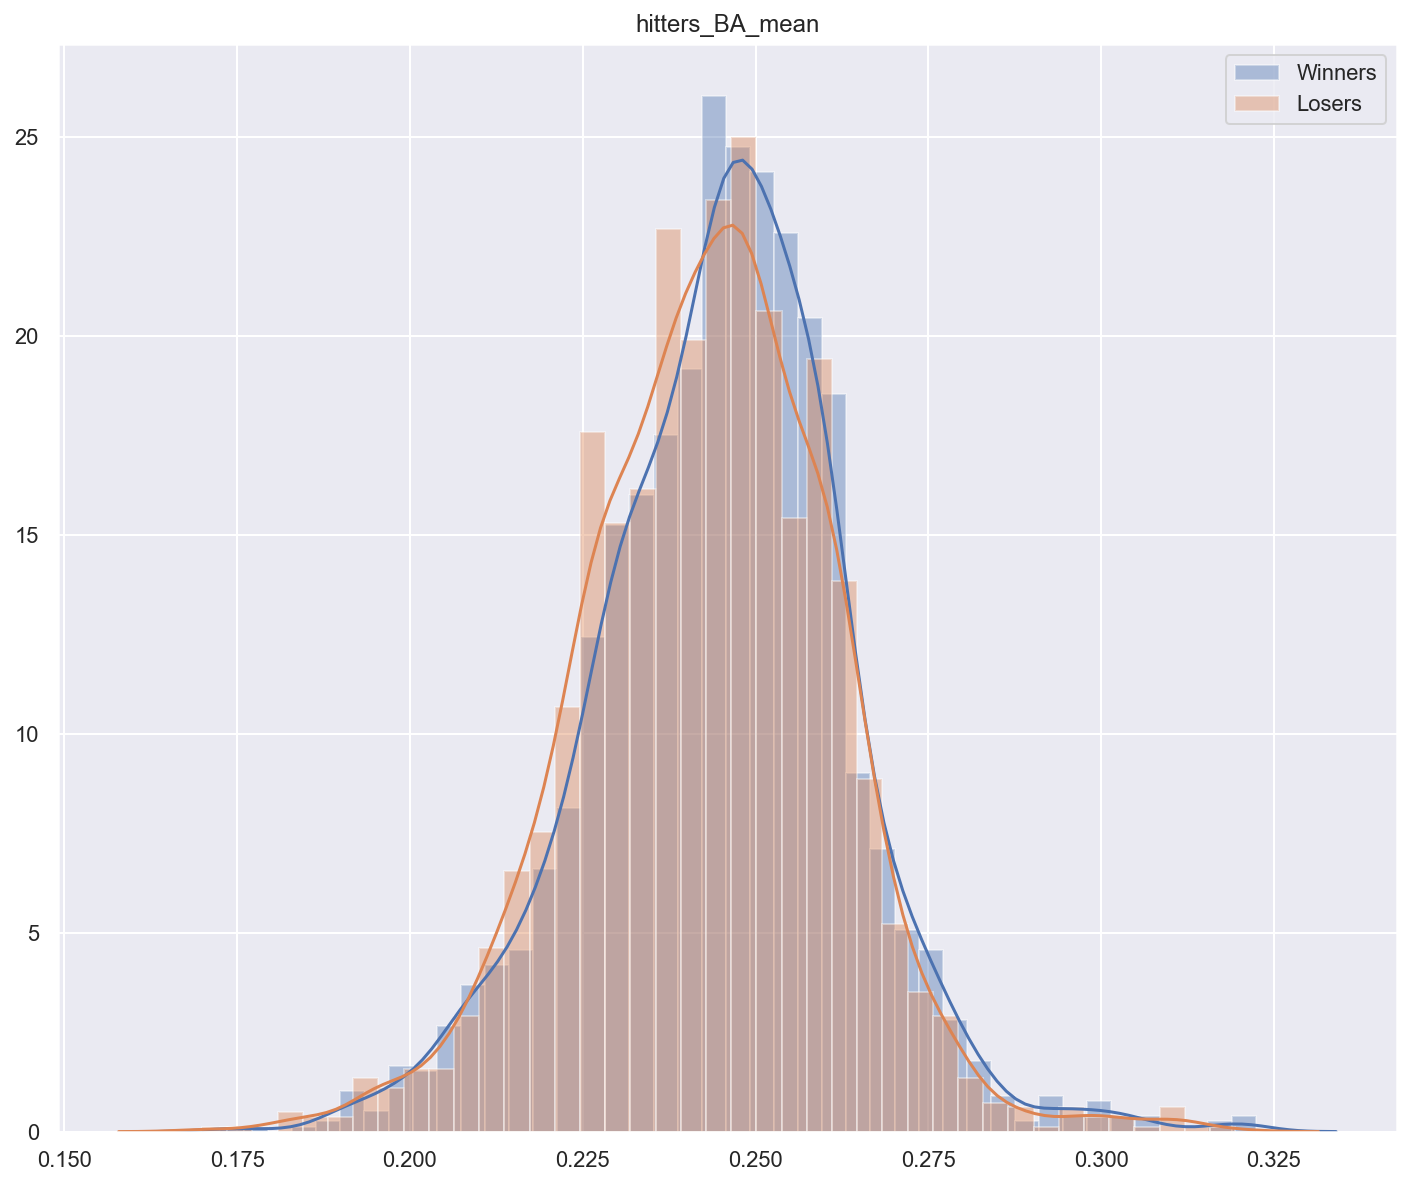

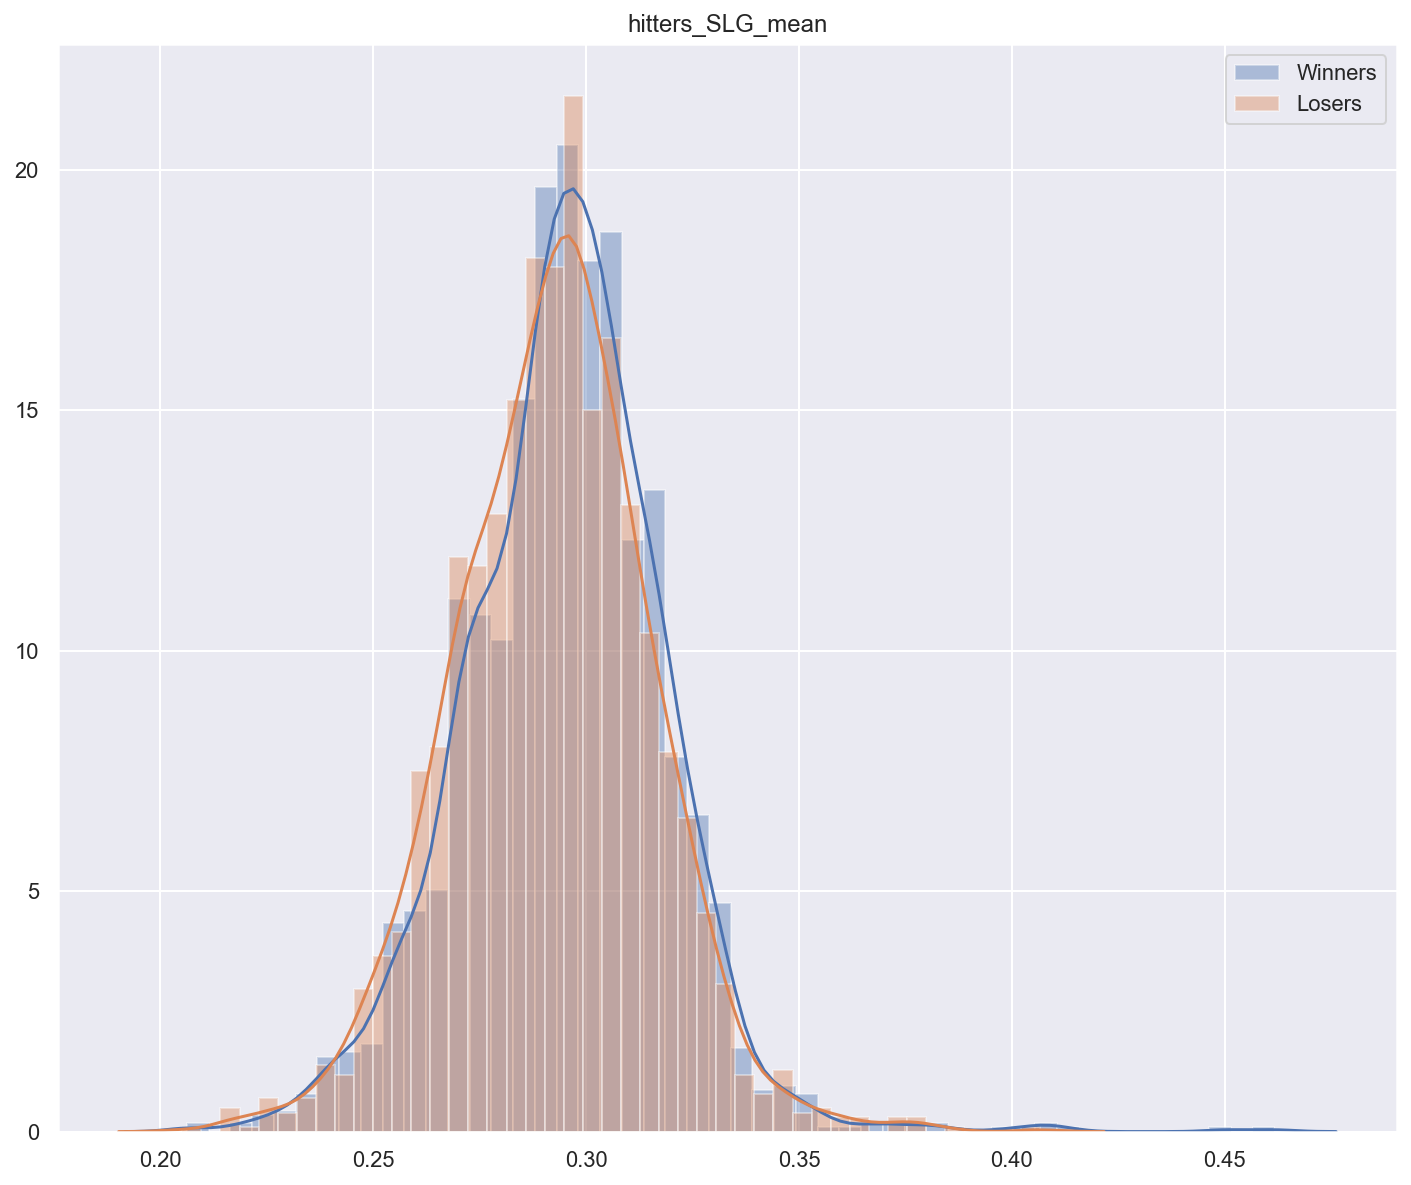

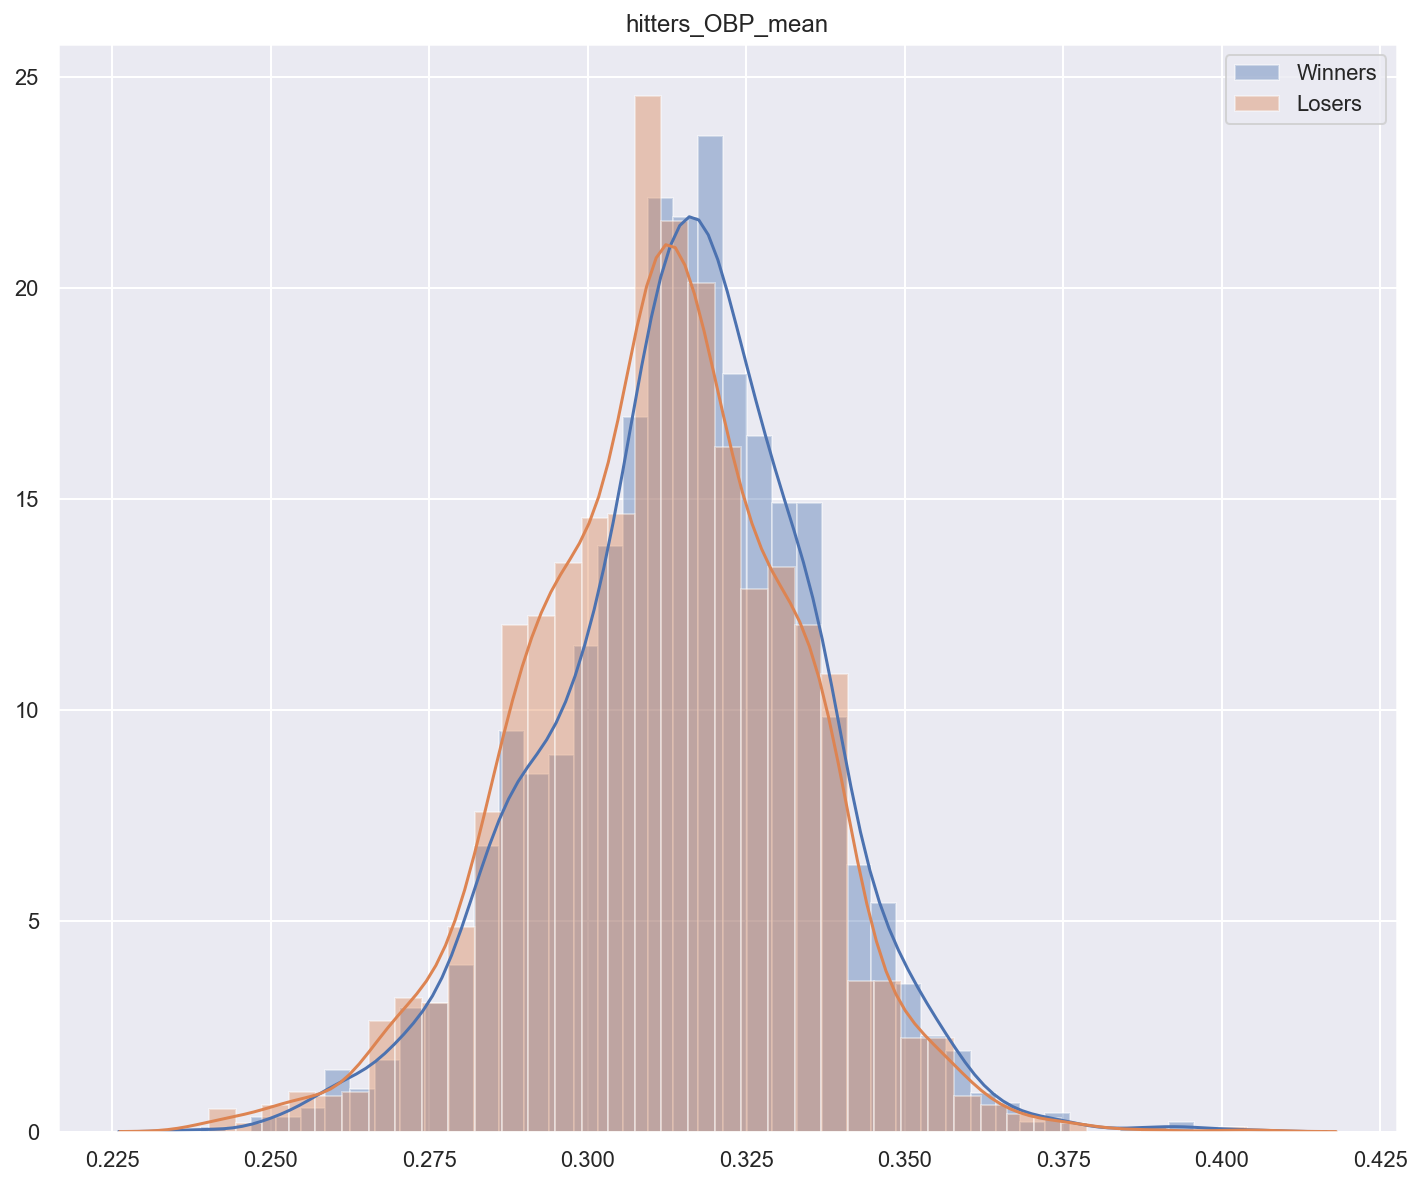

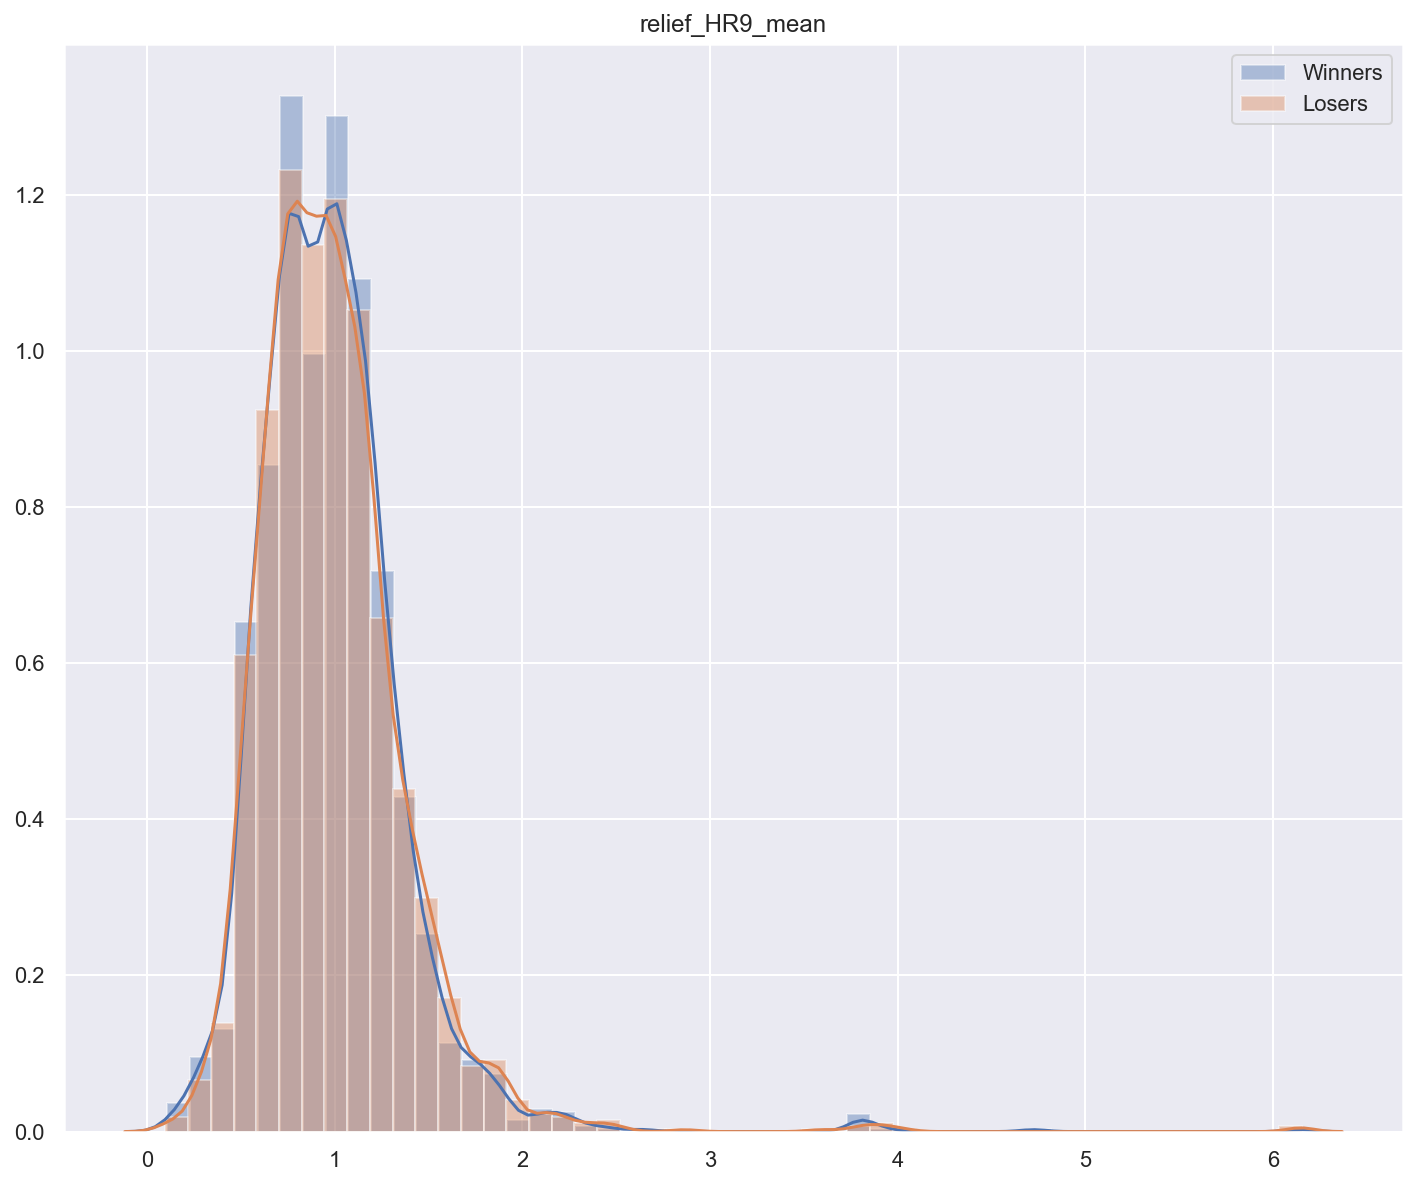

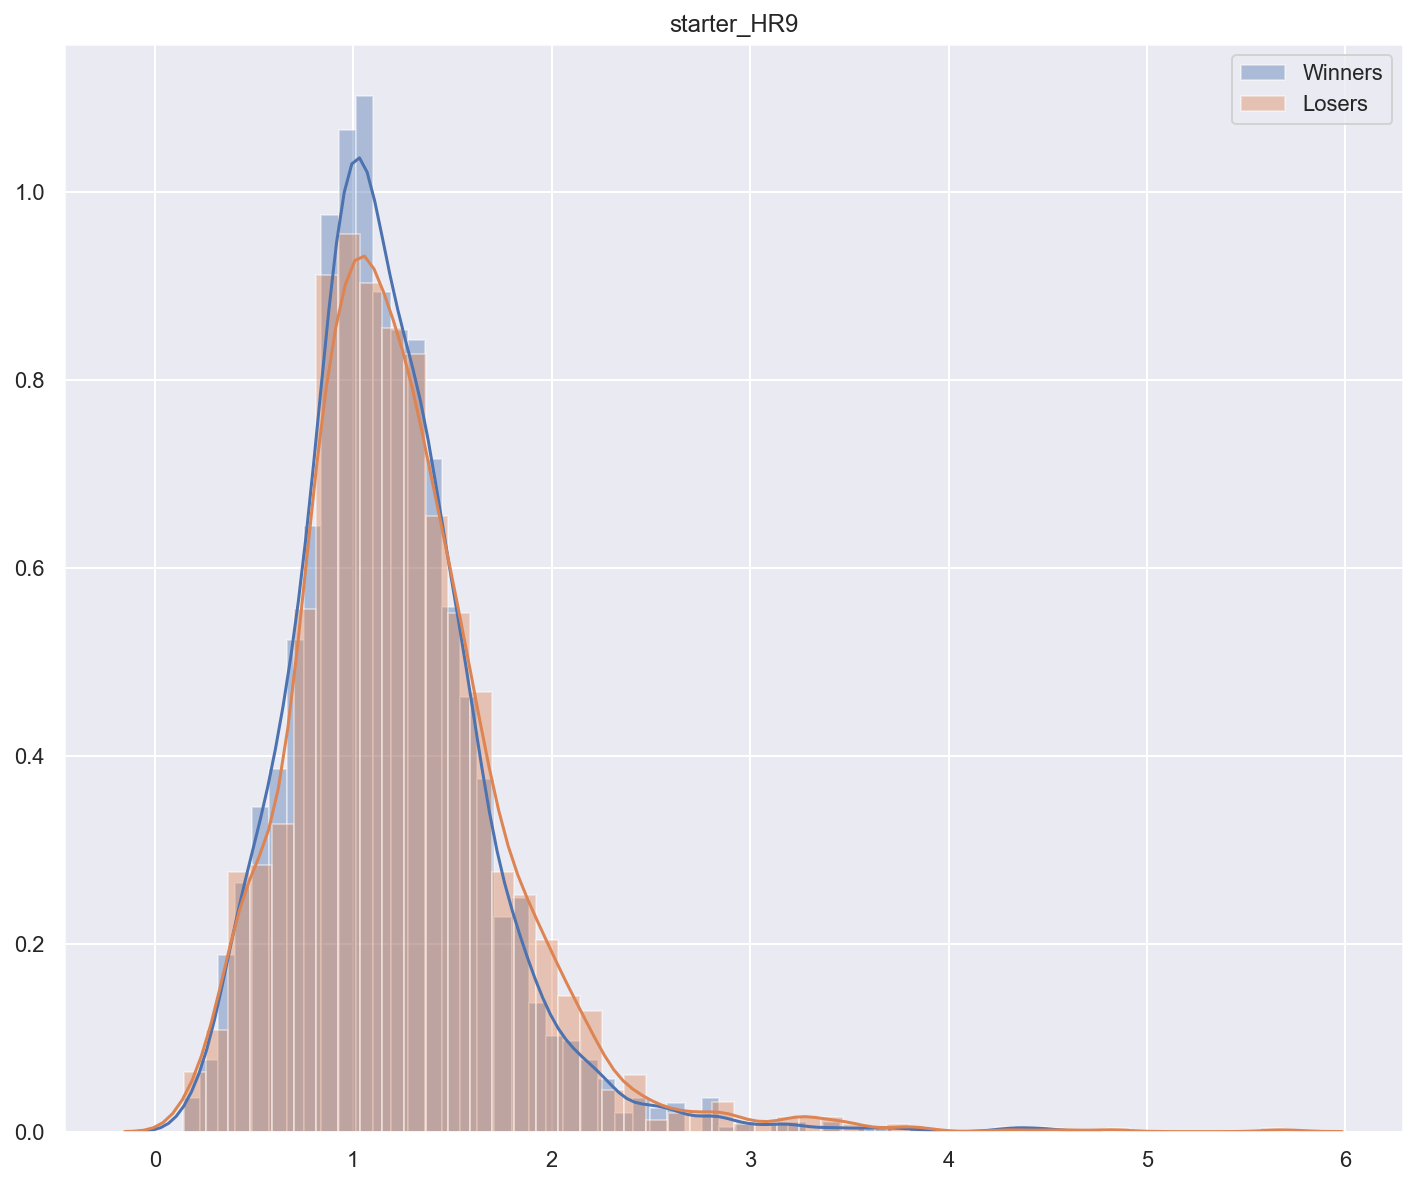

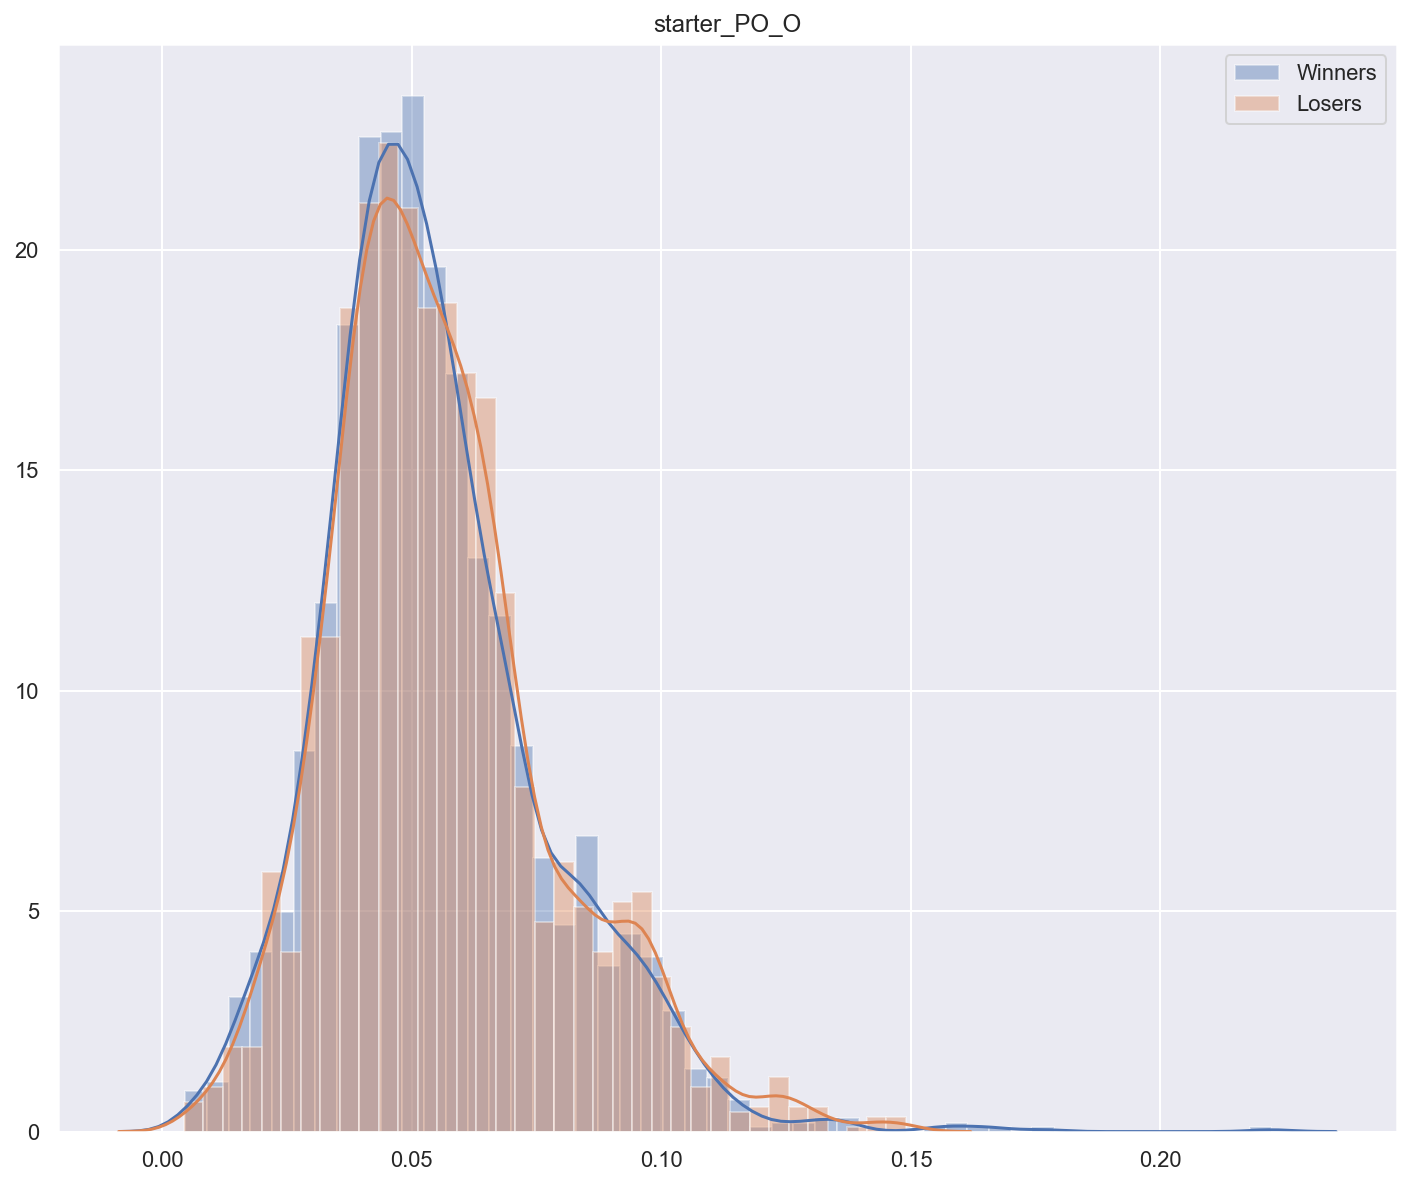

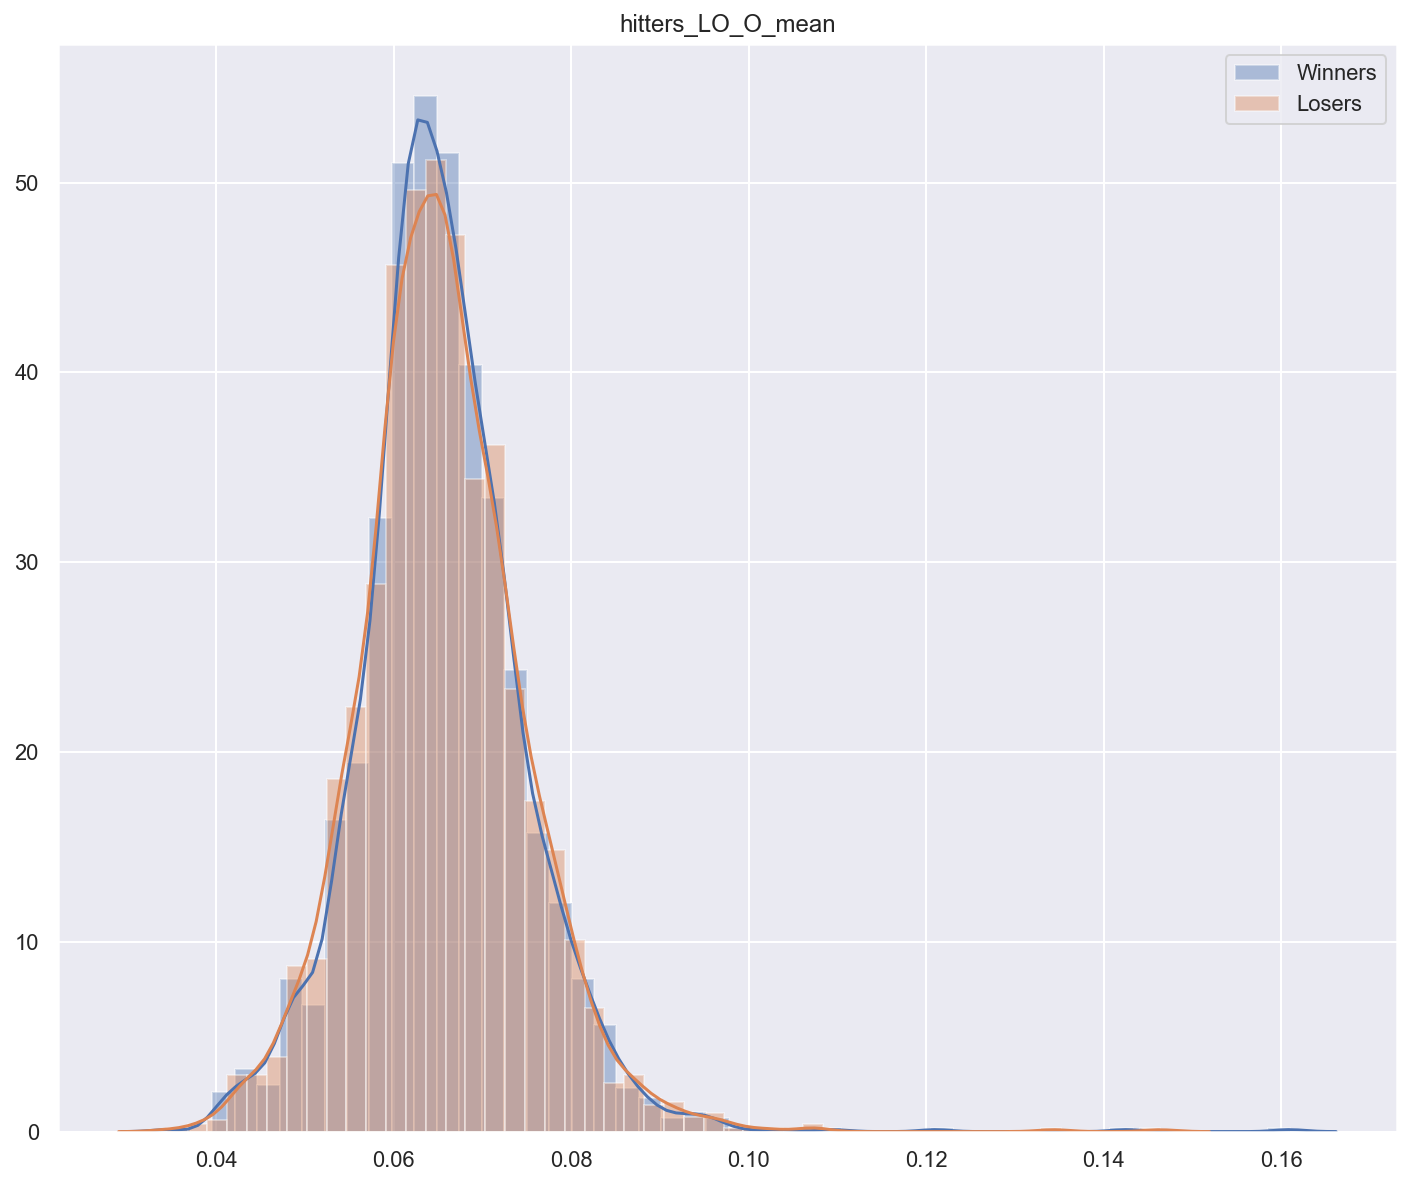

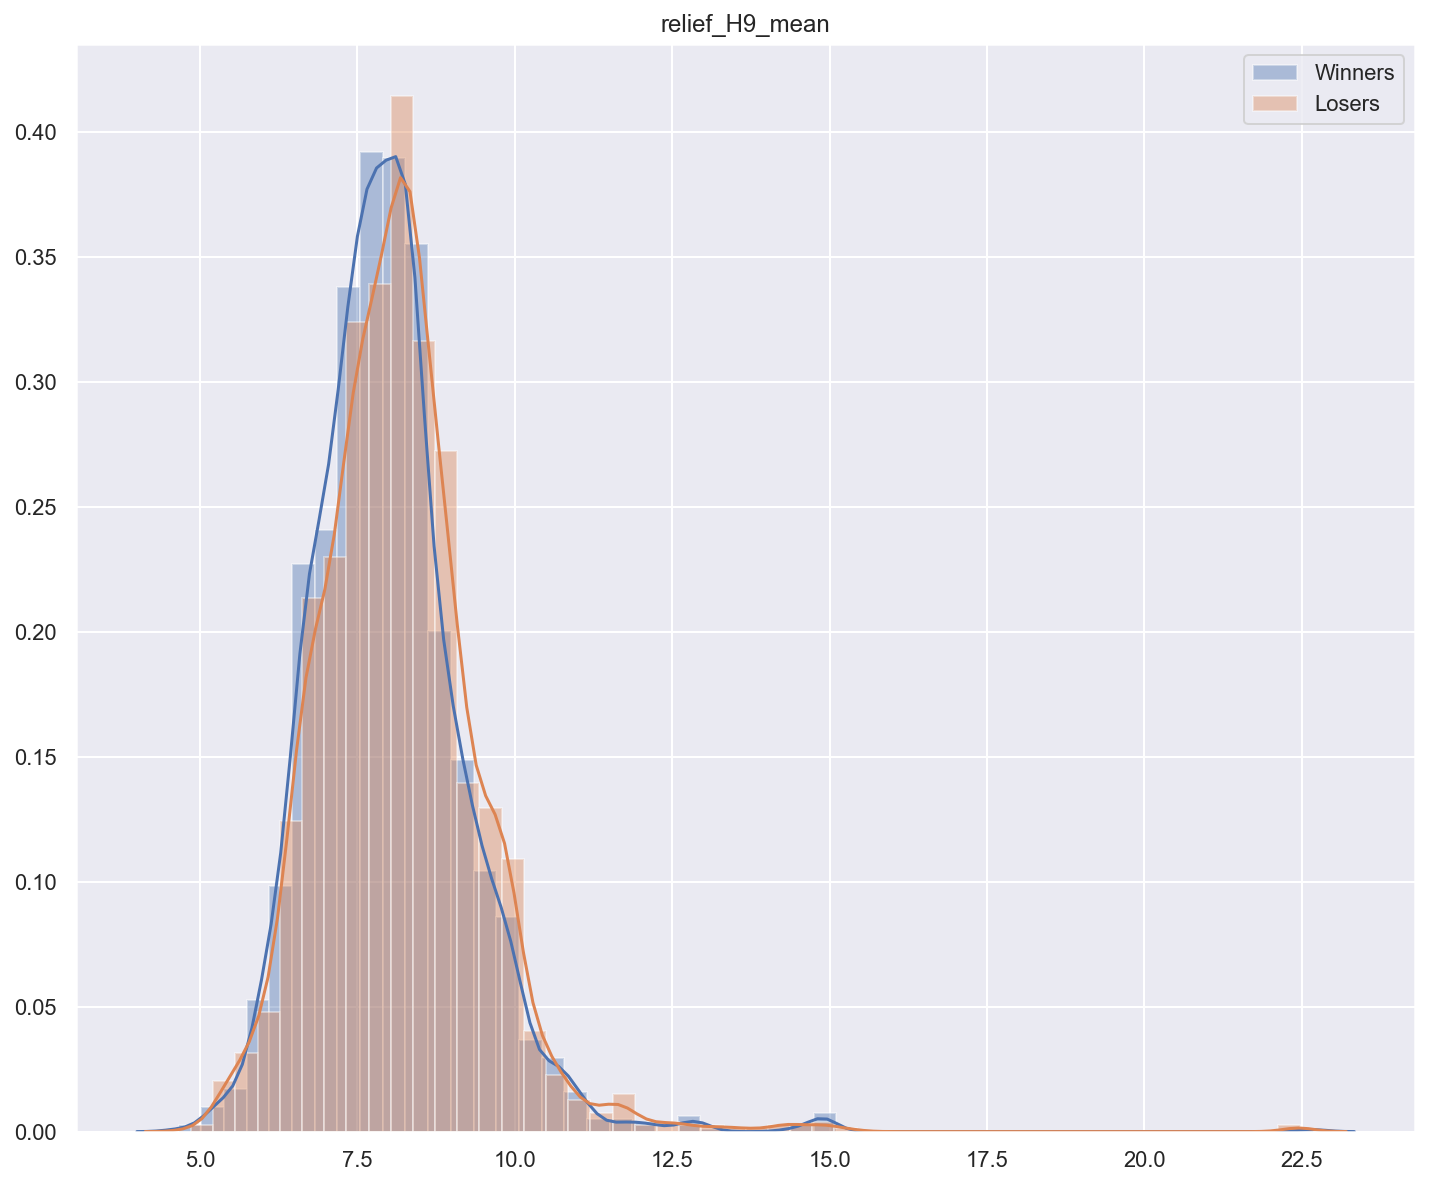

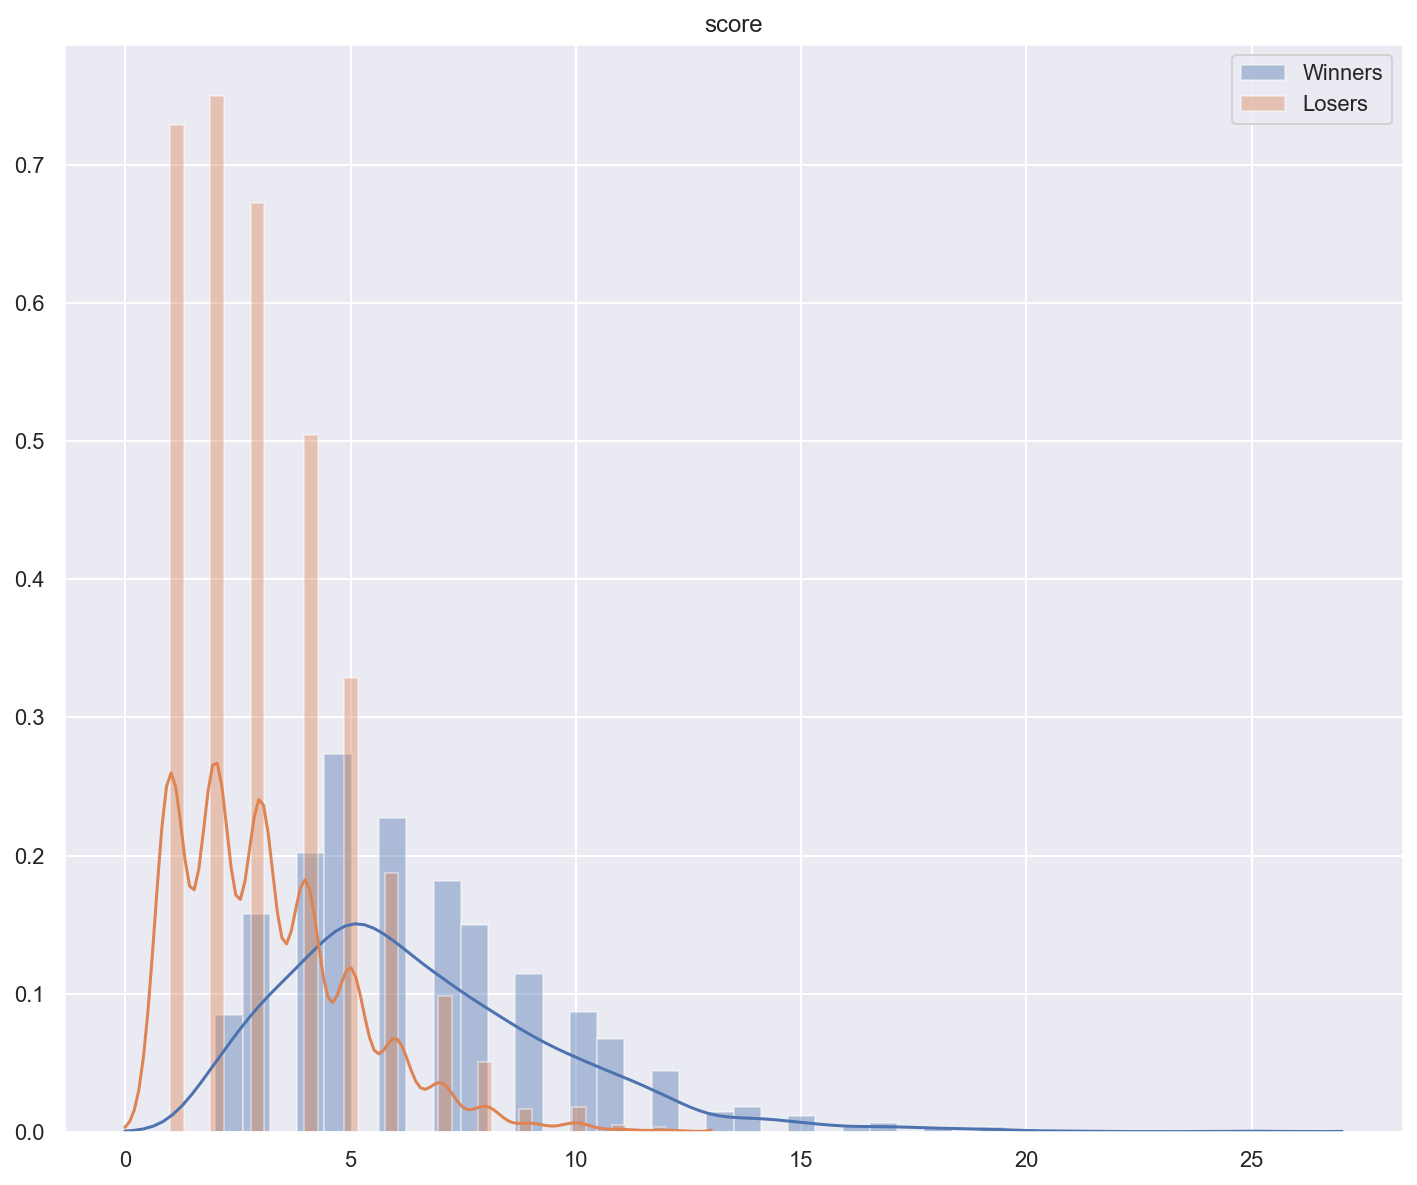

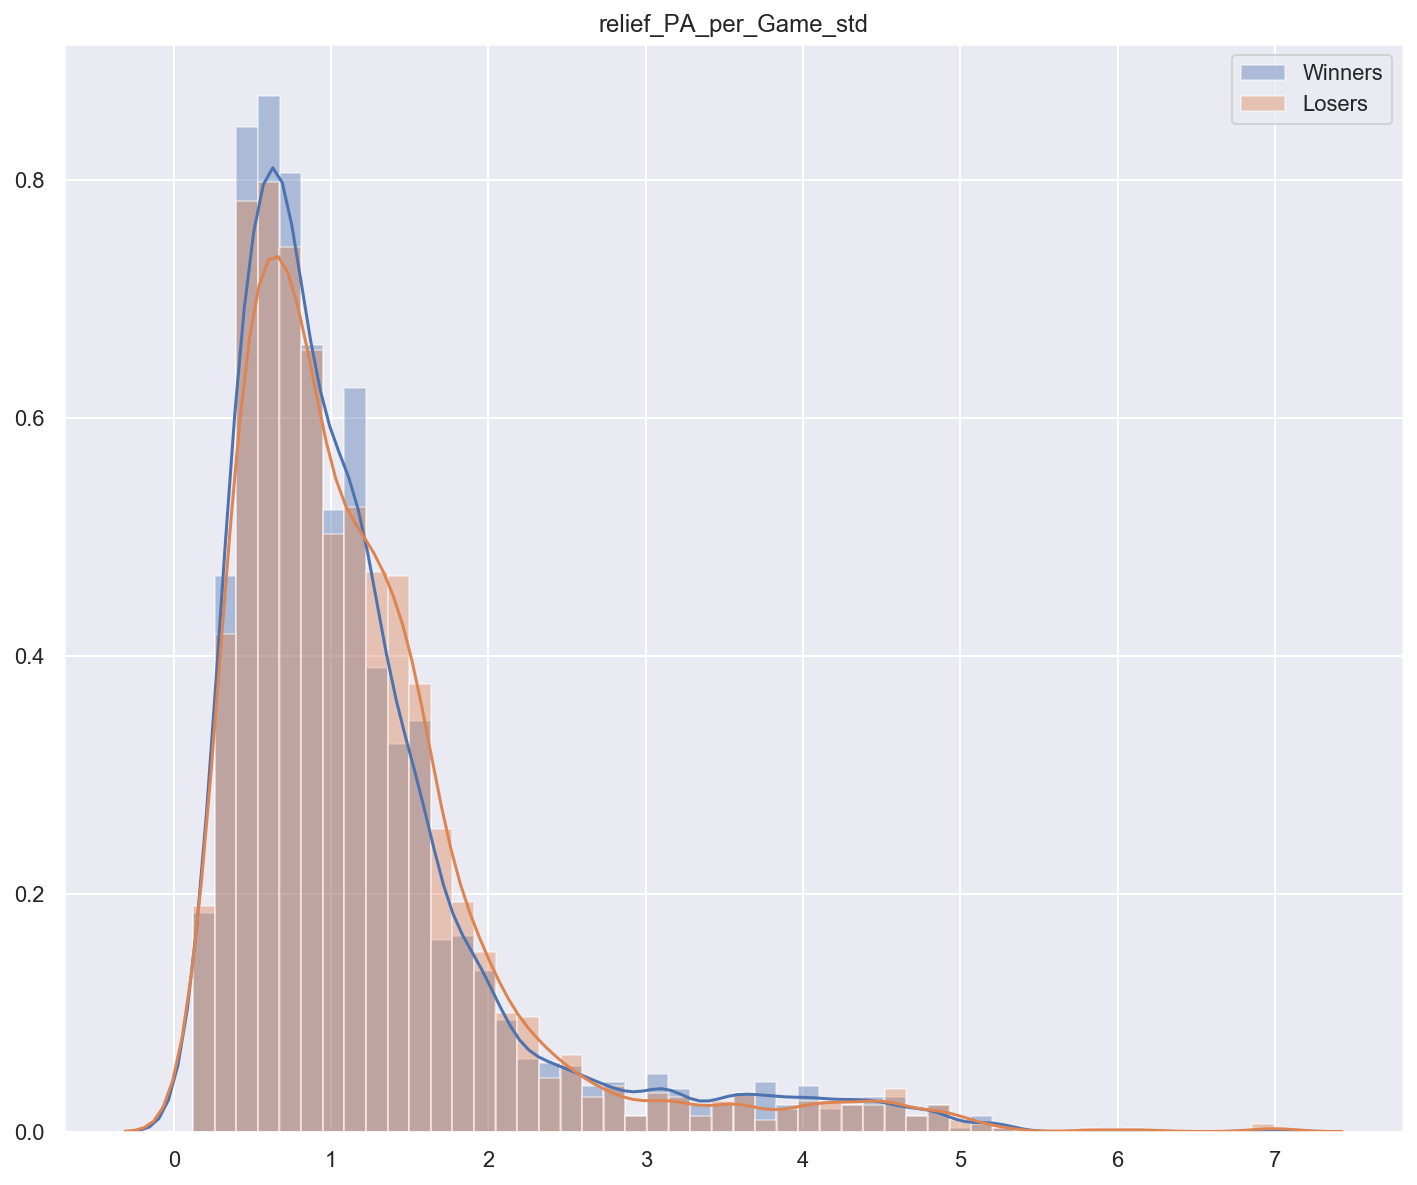

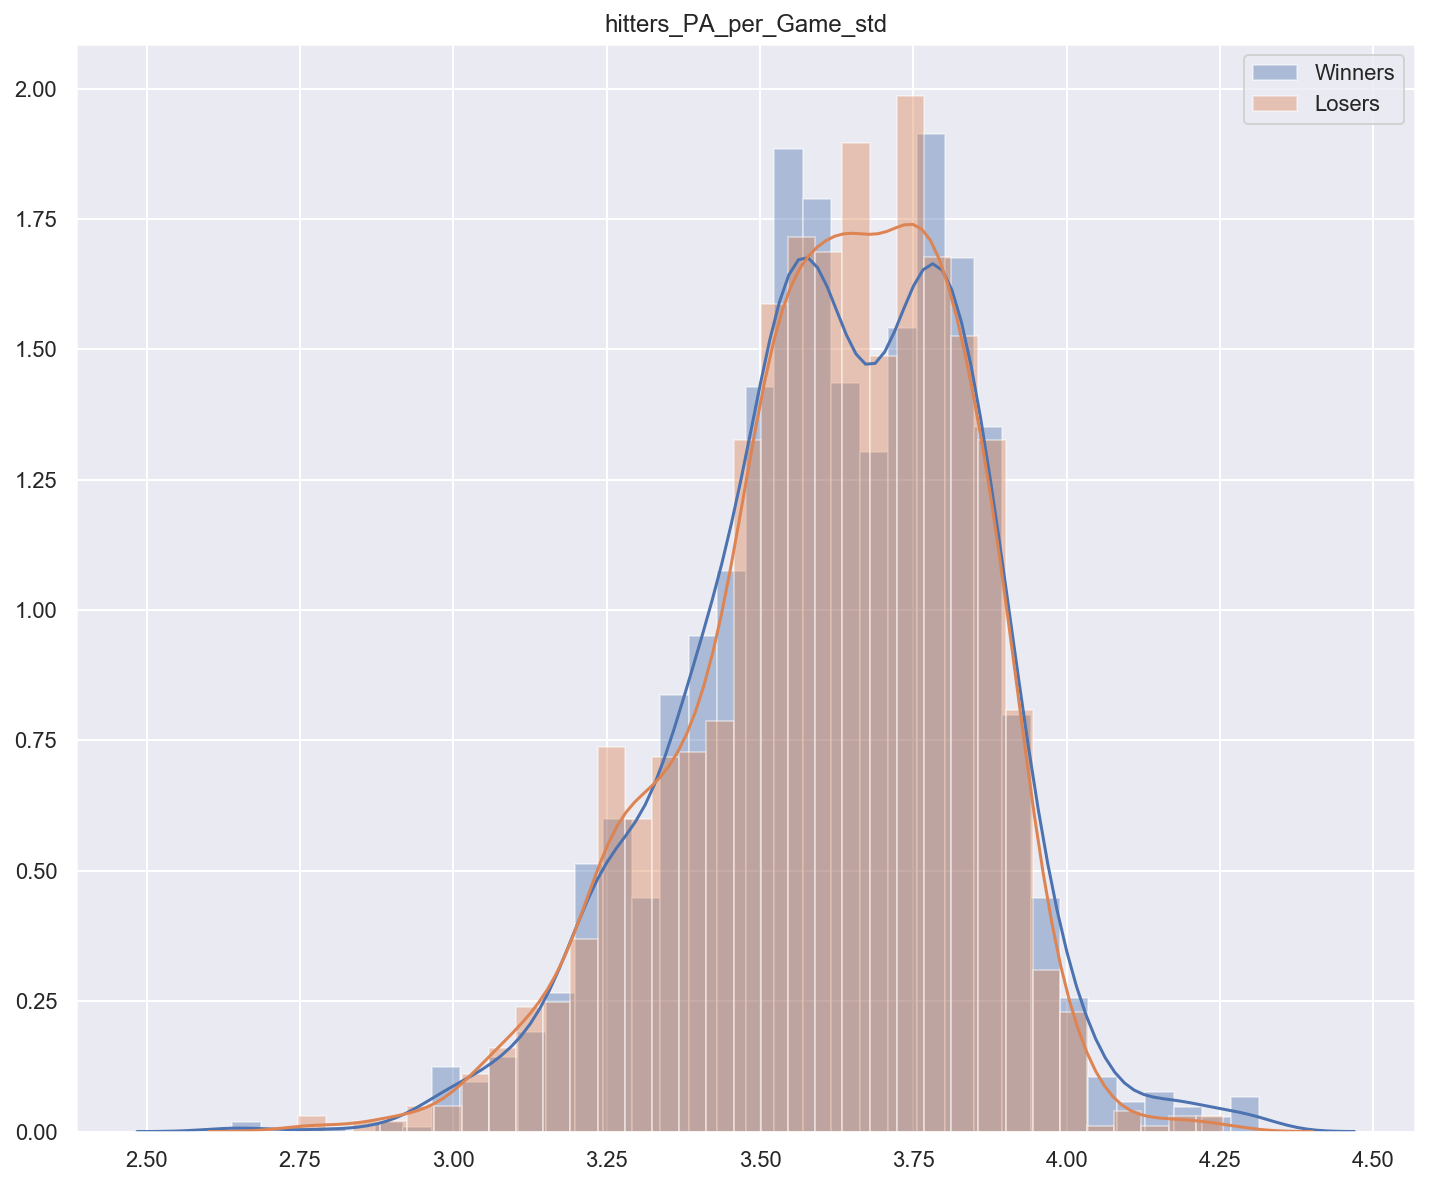

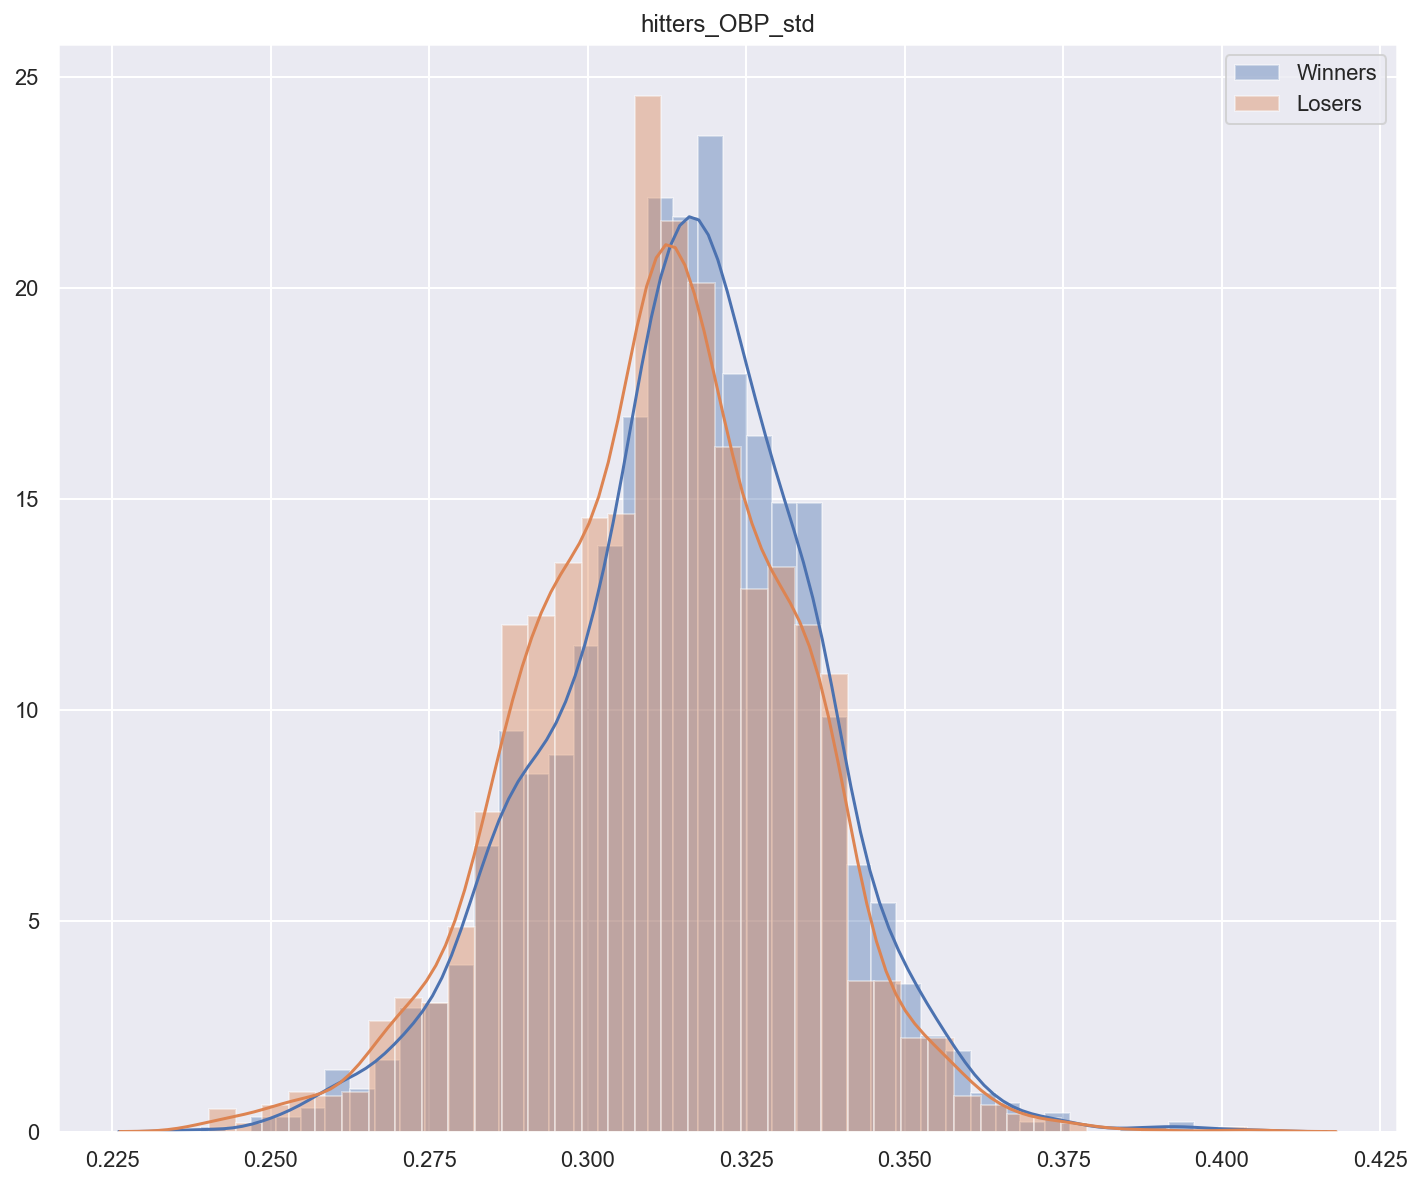

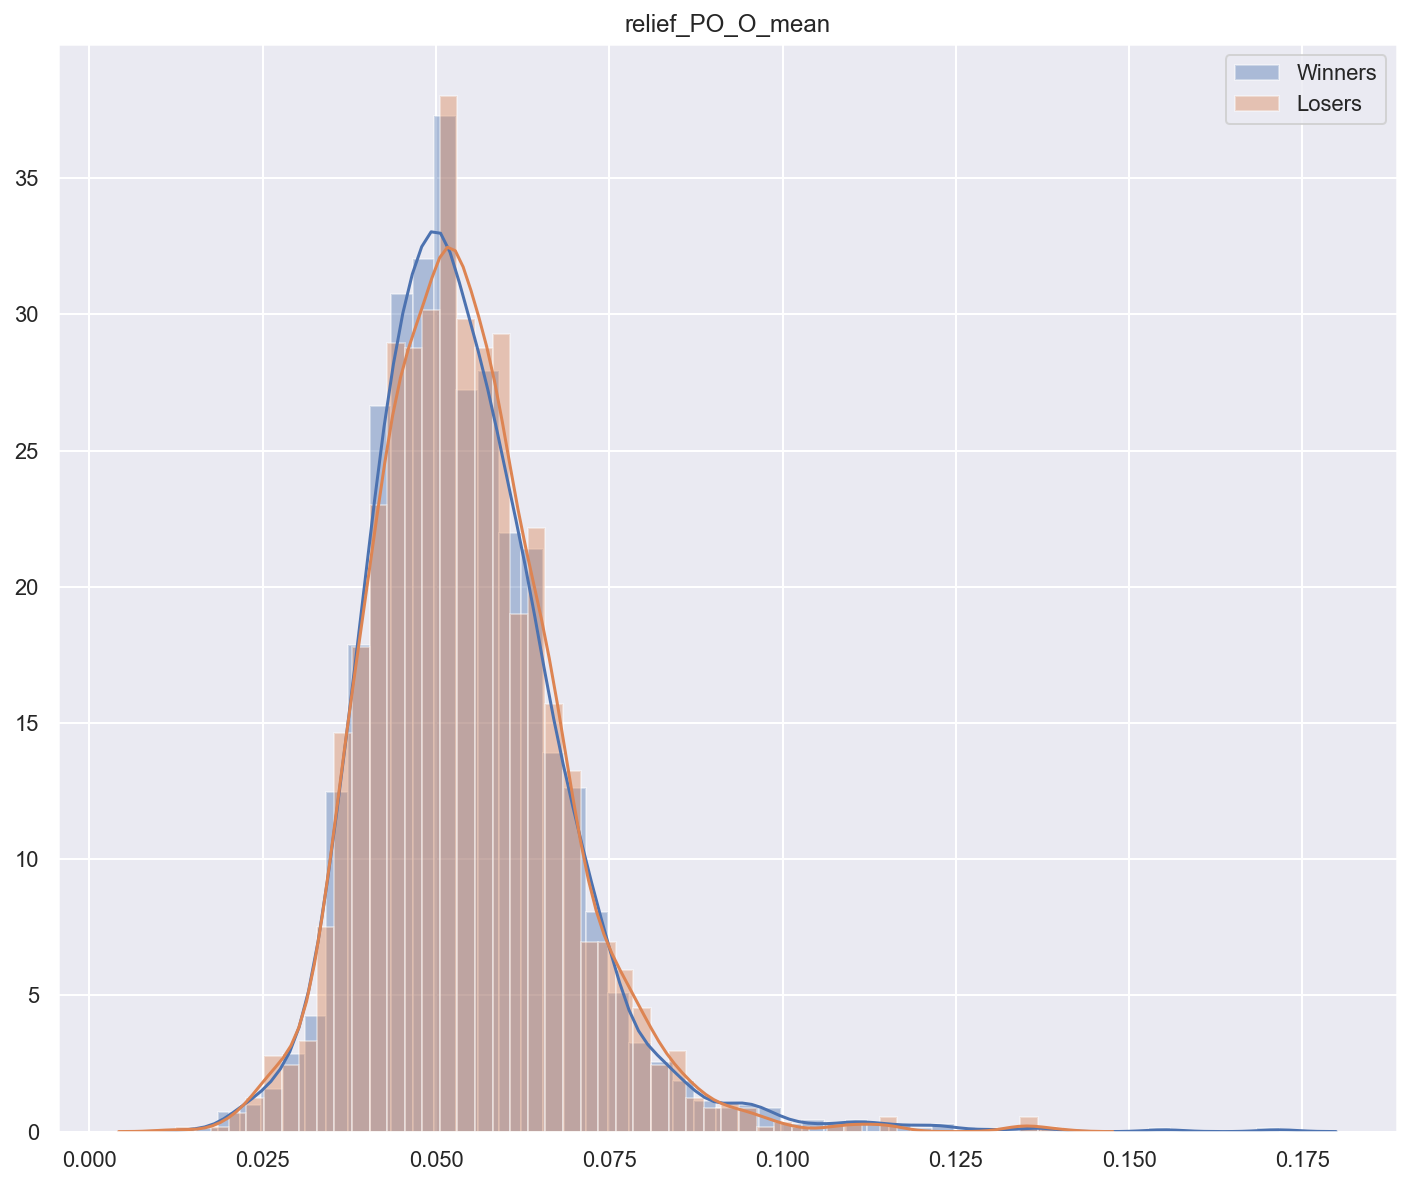

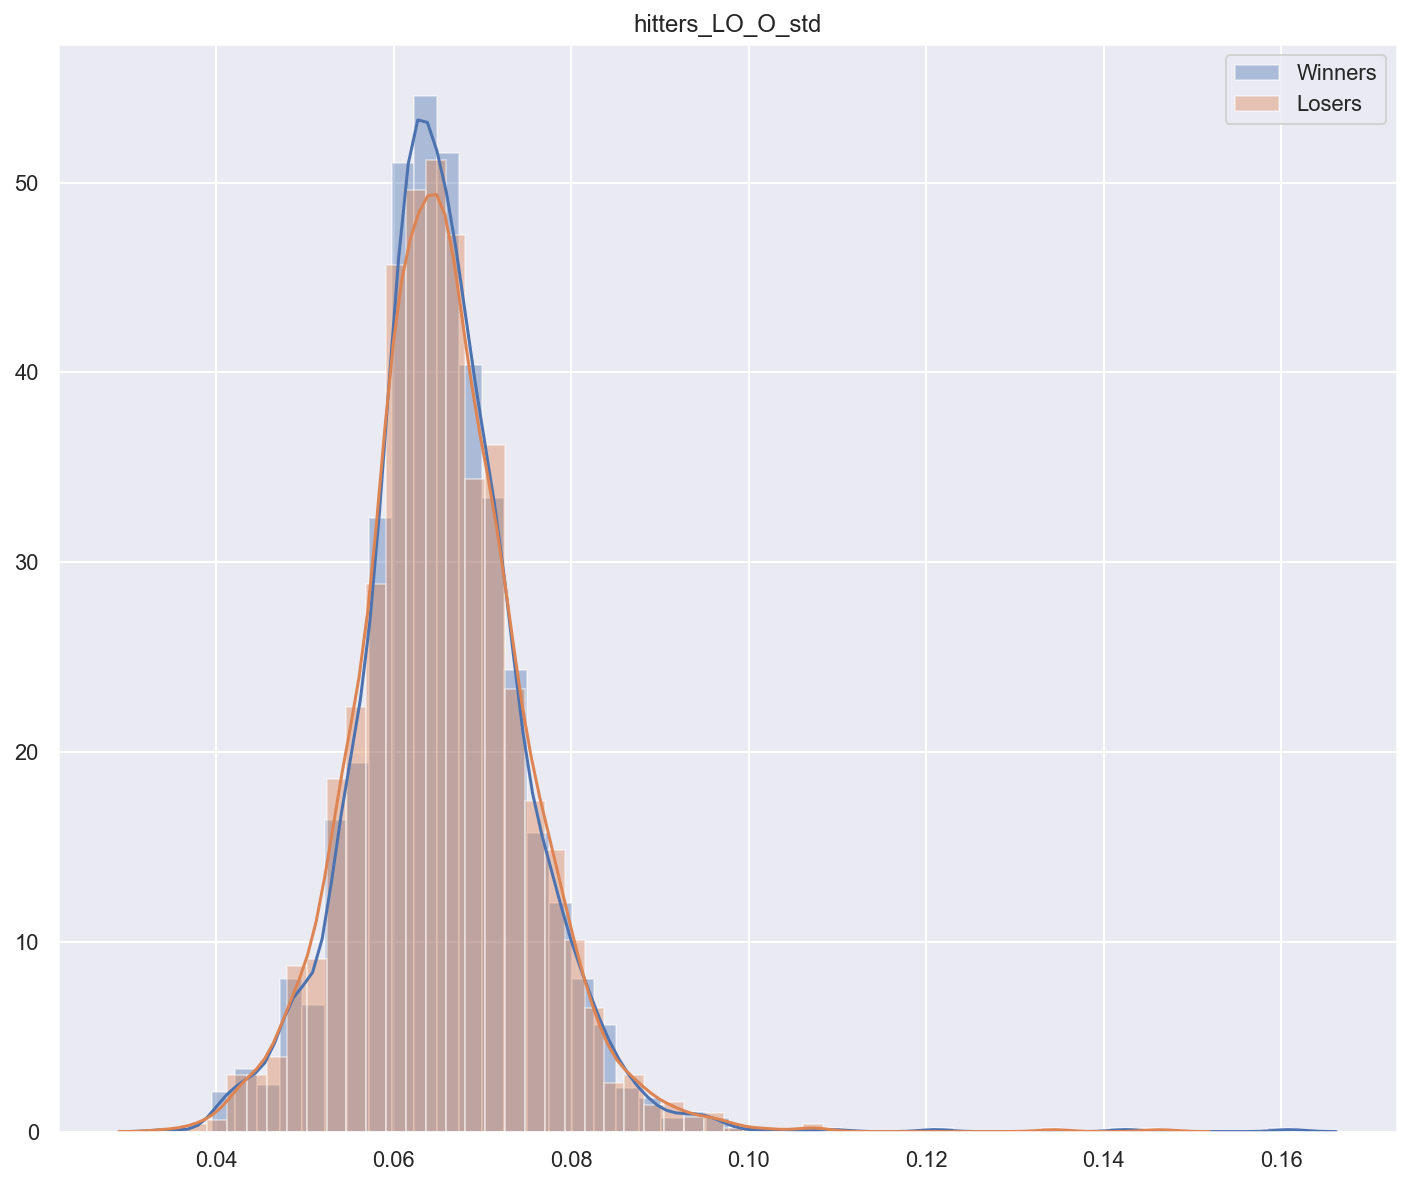

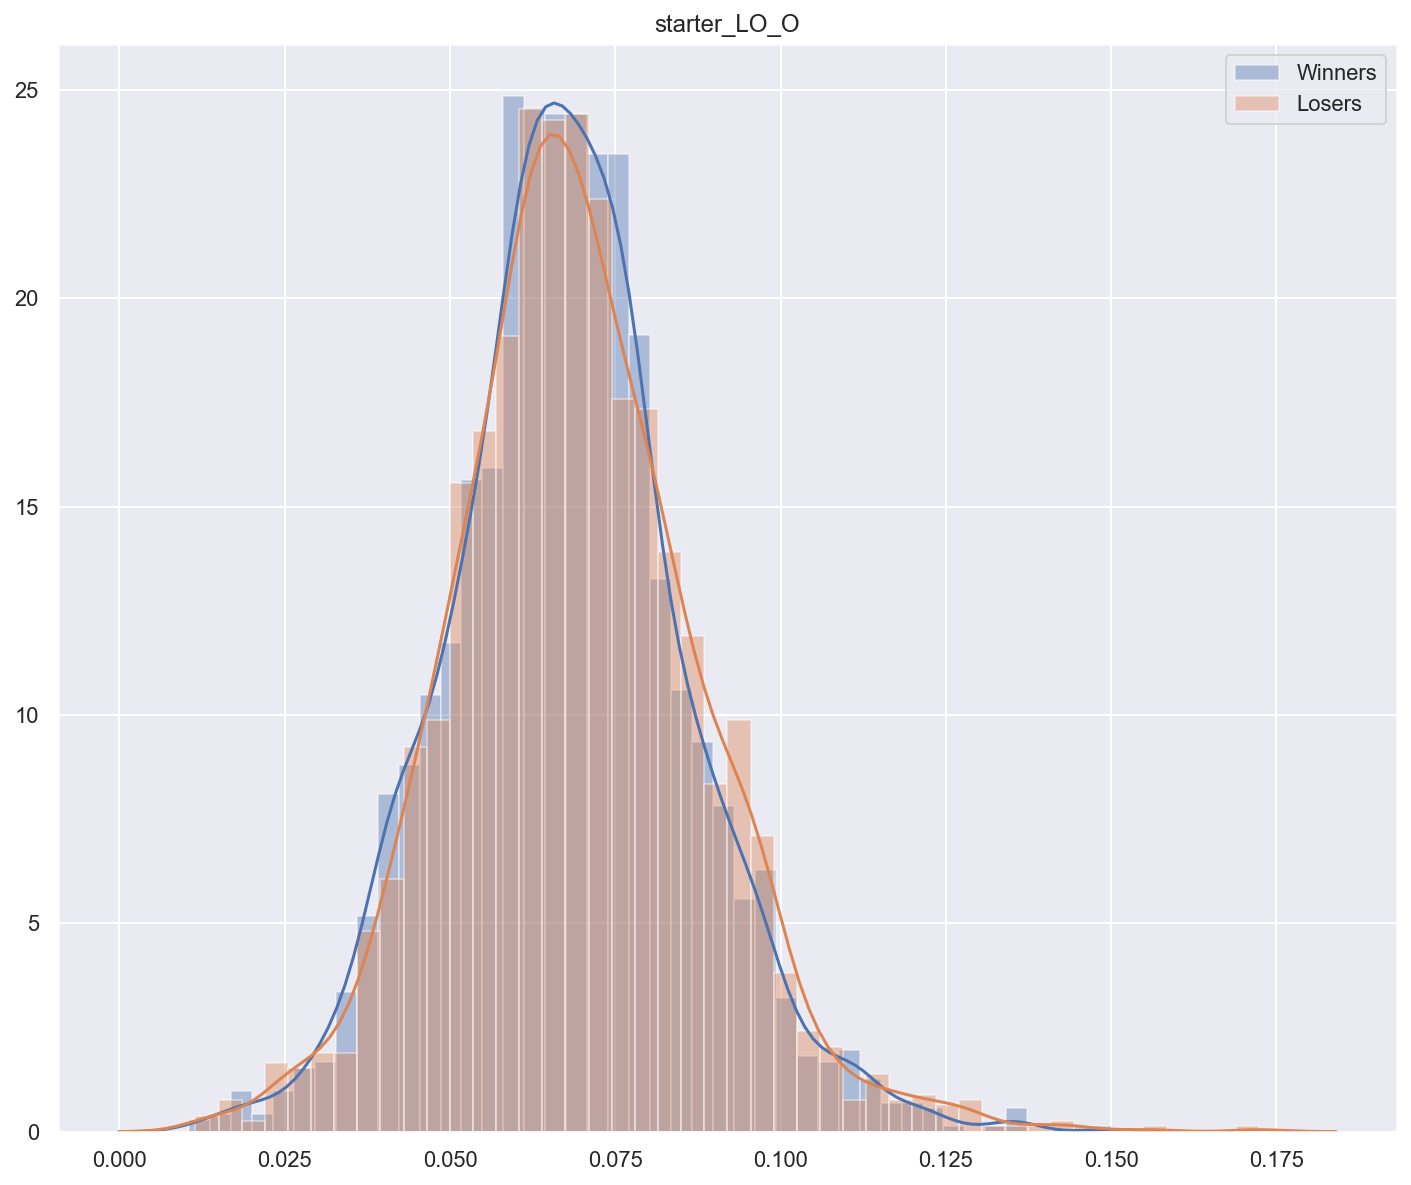

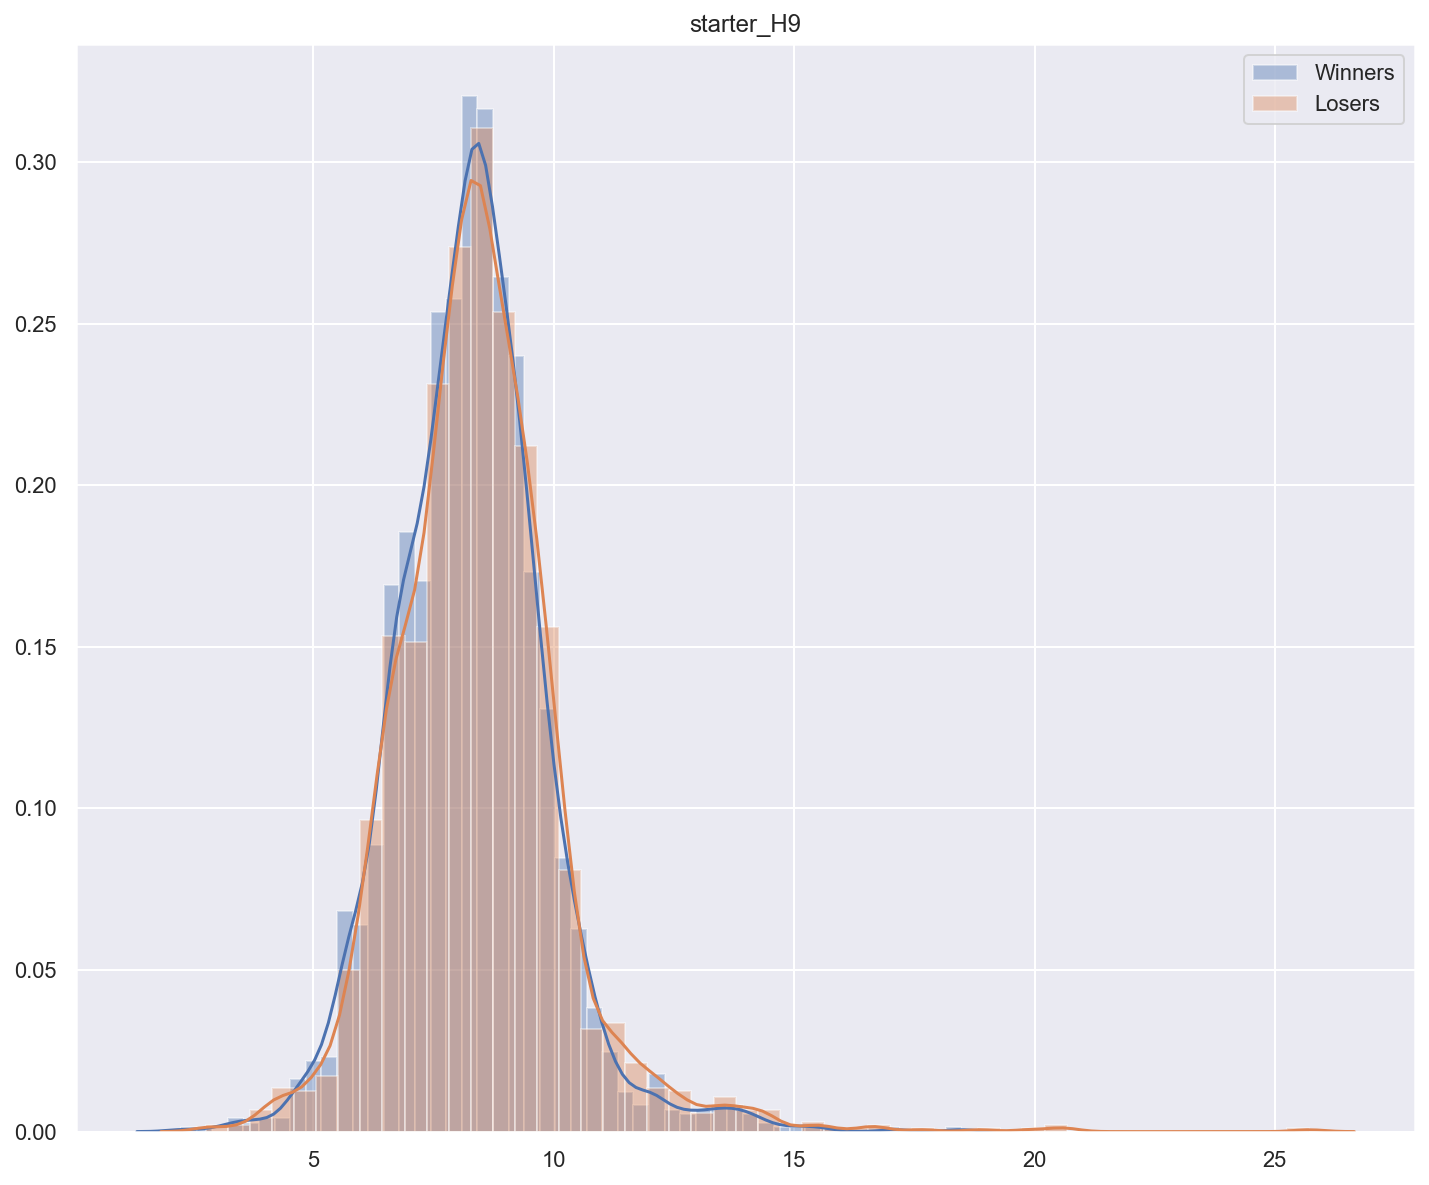

In [27]:
compare_stat_distro(df)

In [14]:
kershaw=session.query(Person).filter(Person.fullName=='Clayton Kershaw').one()

In [15]:
kershaw.id

477132

In [16]:
def player_curr_avgs(session,person_record):
    most_recent_game=session.query(Game).order_by(Game.dateTime.desc()).first()
    player=person_record.relevant_stats(most_recent_game,session)
    player_dict={}
    if player['games']==0:
        player['games']=-1
    player_dict['position'] = player['Position_type']

    player_dict['PA_per_Game'] = player['PA']/player['games']

    try:
        player_dict['BA'] = player['hits']/player['AB']
    except ZeroDivisionError:
        player_dict['BA']=0

    try:
        player_dict['OBP'] = (
                                (player['hits']+player['walks']+player['HBP']+player['IBB'])
                                /
                                (player['AB']+player['walks']+player['HBP']+player['IBB']+player['sac'])
                              )
    except ZeroDivisionError:
        player_dict['OBP']=0

    try:
        player_dict['SLG'] = (
                                ((player['singles']*1)+(player['doubles']*2)+
                                (player['triples']*1)+(player['home_runs']*1))
                                /
                                (player['AB'])
                              )
    except ZeroDivisionError:
        player_dict['SLG']=0

    if player['walks']+player['HBP']>0:
        player_dict['SOW'] = player['strikeouts']/(player['walks']+player['HBP'])
    else:
        player_dict['SOW'] = 0

    try:
        player_dict['H9'] = 9*player['hits']/player['IP']
        player_dict['HR9'] = 9*player['home_runs']/player['IP']
        player_dict['SO9'] = 9*player['strikeouts']/player['IP']
        player_dict['WHIP'] = player['walks']+player['HBP']+player['hits']/player['IP']
    except (ZeroDivisionError,KeyError):
        player_dict['H9'] = 0
        player_dict['HR9'] = 0
        player_dict['SO9'] = 0
        player_dict['WHIP'] = 0

    # proportion of groundouts, flyouts, popouts, lineouts to ABs
    if player['AB']>0:
        player_dict['GO_O'] = player['GO']/player['AB']
        player_dict['FO_O'] = player['FO']/player['AB']
        player_dict['PO_O'] = player['PO']/player['AB']
        player_dict['LO_O'] = player['LO']/player['AB']
    else:
        player_dict['GO_O'] = 0
        player_dict['FO_O'] = 0
        player_dict['PO_O'] = 0
        player_dict['LO_O'] = 0
    return player_dict

In [17]:
kershaw_avgs=player_curr_avgs(session,kershaw)

In [18]:
session.query(Game).order_by(Game.dateTime.desc()).first()

<Game(pk='599377',id='2019/10/30/wasmlb-houmlb-1')>

In [19]:
kershaw_stats=kershaw.relevant_stats(session.query(Game).first(),session)

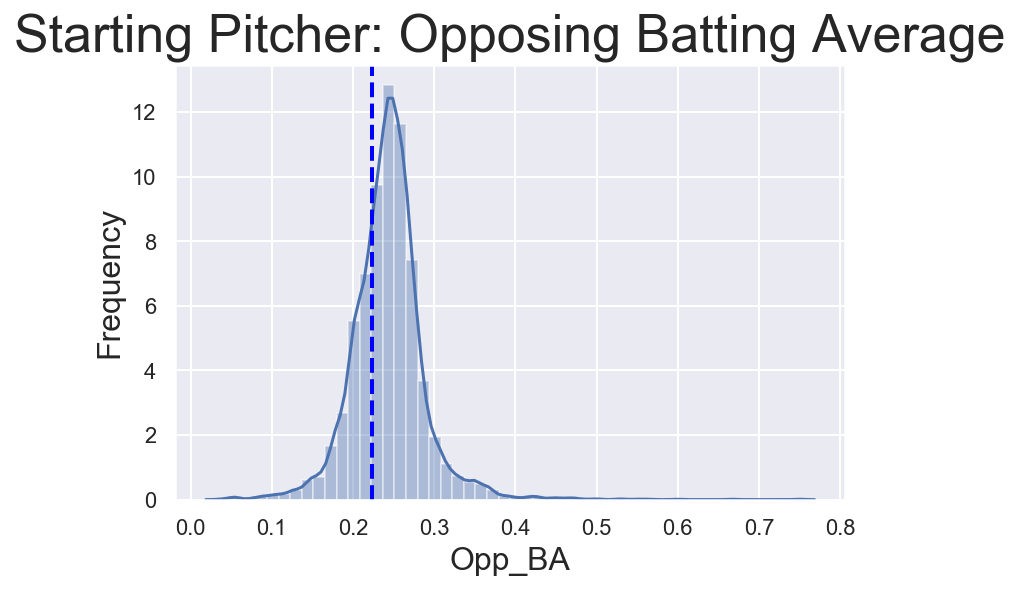

In [22]:
nonZero_homeStarterBa=[x for x in df['home_starter_BA'] if x>0]
nonZero_awayStarterBa=[x for x in df['away_starter_BA'] if x>0]
nonZero_starterBa=[item for sublist in [nonZero_awayStarterBa,nonZero_homeStarterBa] for item in sublist]

sns.distplot(nonZero_starterBa)
plt.title('Starting Pitcher: Opposing Batting Average',fontdict={'fontsize':26})
plt.xlabel('Opp_BA',fontdict={'fontsize':16})
plt.ylabel('Frequency',fontdict={'fontsize':16})
plt.savefig(image_dir+'SP_OBA.jpg')

plt.axvline(kershaw_avgs['BA'],color='blue', linestyle='--', lw=2)

plt.show()

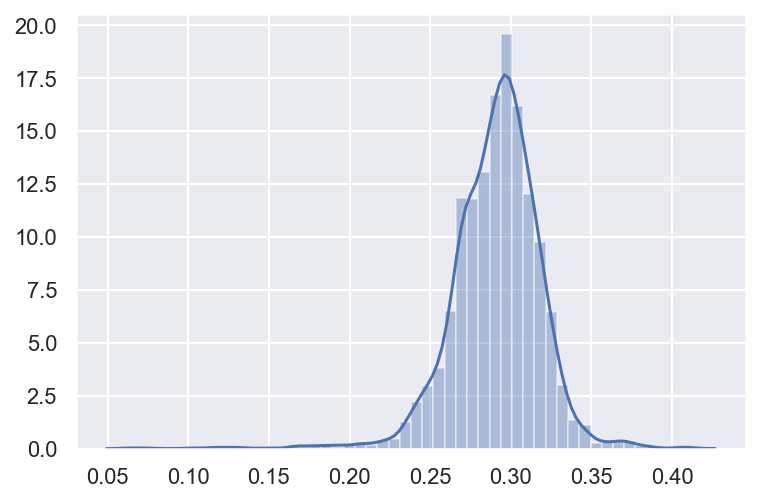

In [23]:
sns.distplot([x for x in df['home_hitters_SLG_mean'] if x>0])

In [ ]:
nonZero_homeStarterOBP=[x for x in df['home_starter_OBP'] if x>0]
nonZero_awayStarterOBP=[x for x in df['away_starter_OBP'] if x>0]
nonZero_starterOBP=[item for sublist in [nonZero_awayStarterOBP,nonZero_homeStarterOBP] for item in sublist]

sns.distplot(nonZero_starterOBP)
plt.title('Starting Pitcher: Opposing On Base',fontdict={'fontsize':26})
plt.xlabel('Opp_BA',fontdict={'fontsize':16})
plt.ylabel('Frequency',fontdict={'fontsize':16})
plt.savefig(image_dir+'SP_OBP.jpg')
plt.show()


sns.distplot([x for x in df['home_hitters_SLG_mean'] if x>0])

In [ ]:
home_starter_pag = [x for x in df['home_starter_PA_per_Game'] if x>0]
away_starter_pag = [x for x in df['away_starter_PA_per_Game'] if x>0]
starter_pag = [item for sublist in [home_starter_pag,away_starter_pag] for item in sublist]

home_rel_pag = [x for x in df['home_relief_PA_per_Game_mean'] if x>0]
away_rel_pag = [x for x in df['away_relief_PA_per_Game_mean'] if x>0]
rel_pag = [item for sublist in [away_rel_pag,home_rel_pag] for item in sublist]

In [ ]:
sns.distplot(starter_pag,label='Starters: avg hitters faced per game')
sns.distplot(rel_pag,label='Relievers: avg hitters faced per game')

plt.legend()
plt.savefig(image_dir+"pa_g.jpg")

In [ ]:
home_hitters_stats = [x for x in df.columns.tolist() if 'home_hitters' in x and 'std' not in x]

In [ ]:
home_hitters_stats

In [ ]:
df[home_hitters_stats].hist(bins=50,figsize=(12,10))
plt.savefig(image_dir+'hitter_stats.jpg')
plt.show()
